In [102]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
First created on July 30 2018
@author: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. TESTING_FOLDER will be filled during the run with images from the analysis analysis

3. (OPTIONAL) Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes somewhat large and possiblhy hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/brentbelland/Desktop/Version_028d/2d_PSF_code/'
############################################################
    
TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'

# create these directories if they do not exist
import os
for i in [PSF_DIRECTORY,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)    
    

In [101]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}


<IPython.core.display.Javascript object>

In [3]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

#Zernike_Module_lastOct15_beforeScatterChange
import Zernike_Module
from Zernike_Module import *

In [5]:
#general import statments
from __future__ import absolute_import, division, print_function
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

# lmfit 
# import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c

## Single example with dummy values to check that the code  is working

In [6]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  
"""
# zernike parameters that control the wavefront
@param z4                     defocus parameter 
@param z5-z11                 further Zernike coefficents describing the wavefront, following Noel convention

# first set of parameters describing the pupil
@param hscFrac                Value determining how much of the exit pupil obscured by the central obscuration(detector)  (name is relic of the code when it was used for Hyper Suprime cam project)
@param strutFrac              Value determining how much of the exit pupil is obscured by a single strut
@param dxFocal, dyFocal       Value determining the position of the central obscuration(detector) in the focal plane
@param slitFrac               Value determining how much of the exit pupil is obscured by slit 
@param slitFrac_dy            Value determining what is the vertical position of the slit in the exit pupil

# set of parameters change of illumination between the entrence pupil and the exit pupil
# June 04, 2019 - I am not sure if I need those!!!
@param radiometricEffect      parameter describing the change of the illumination (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param radiometricExponent    parameter describing the change of the illumination (1-params['radiometricEffect']**2*r**2)**(params['radiometricExponent'])
@param x_ilum, y_ilum         positions of the centrer of the nonuniform illumination

# illumination due to fiber, parameters
@param x_fiber                position of the fiber misaligment in the x direction
@param y_fiber                position of the fiber misaligment in the y direction
@param effective_ilum_radius  fraction of the maximal radius of the illumination of the exit pupil   
@param frd_sigma              sigma of Gaussian convolving only outer edge, mimicking FRD
@param frd_lorentz_factor     strength of the lorentzian factor describing wings of the pupil illumination - between 0 and 1

# further pupil parameters (second set of parameters describing the pupil)
@param det_vert                  multiplicative factor determining vertical size of the detector obscuration
@param slitHolder_frac_dx        dx position of slit holder

# convolving (postprocessing) parameters
@param grating_lines             number of effective lines in the grating
@param scattering_slope          slope of scattering
@param scattering_amplitude      amplitude of scattering compared to optical PSF
@param pixel_effect              sigma describing charge diffusion effect [in units of 15 microns]
@param fiber_r                   radius of perfect tophat fiber, as seen on the detector [in units of 15 microns]         
@param flux                      total flux in generated image compared to input image (it will probably be 1 or very close to 1)
"""


sci_image_unit=np.ones((50,50))*10
var_image_unit=np.ones((50,50))*10

# same rows holds parameters of the same group, as described in the comment above
allparameters_proposal=np.array([0,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0,1,1,
                                 0.2,-0.0,0.92,0.08,0.8,
                                 1.06,0.28,
                                 50000,2.5,0.027,0.37,1.85,1.0])

print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1,simulation_00=1)   

res=model(allparameters_proposal,return_Image=True)

# last value should be -1183627.3527894863
print('Likelihood is: '+str(res[0]))

version of the code is: 0.28b
npix_value:1280
Science image shape is: (50, 50)
Top left pixel value of the science image is: 10.0
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 10.0
Mask image shape is: (50, 50)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.        0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.        1.        1.        0.2      -0.        0.92
     0.08      0.8       1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolution
use_pupil_parameters: None
pupil_parameters if you use_pupil_parameters: None
[

In [7]:
model2 = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,zmax=22,verbosity=0,simulation_00=1)

import os
import shutil
from os import path

def savefile(FRD,Defocus,Position,Scaling):
    # copy the code's output to a separate file in an appropriate directory
    if path.exists(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy"): #It should
        src = path.realpath(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy") # get the path to the file in the current directory
        # rename the original file
        os.rename(src,path.join(TESTING_FINAL_IMAGES_FOLDER,'PlotImages/','{}_{}_{}_{}Image.npy'.format(Defocus,str(Position),str(int(10000*FRD)),str(Scaling))))
    else:
        print('Could not find the file!')
        
def savefile_sim(FRD,Defocus,Position,Scaling):
    # copy the code's output to a separate file in an appropriate directory
    if path.exists(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_grating_convolved_simulation_cut.npy"): #It should
        src = path.realpath(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_grating_convolved_simulation_cut.npy") # get the path to the file in the current directory
        # rename the original file
        os.rename(src,path.join(TESTING_FINAL_IMAGES_FOLDER,'PlotImages/','{}_{}_{}_{}_SimImage.npy'.format(Defocus,str(Position),str(int(10000*FRD)),str(Scaling)))) #Feels like a bad use of rename to copy over a file. I'll rewrite
    else:
        print('Could not find the file!')
    
def readfile_pupil():
    if path.exists(TESTING_PUPIL_IMAGES_FOLDER+"r_resize.npy"):
        optPsf=np.load(TESTING_PUPIL_IMAGES_FOLDER+"r_resize.npy")
        return optPsf
    else:
        print('Error finding pupil.')
        return None
    
def get_PSF_parameters(FRDval,Defocusval,Positionval,Scaling):
    testfile = pd.read_csv("testfile{}.csv".format(Defocusval))
    testfile = testfile.iloc[Positionval]
    testfile['z4':'z22']= testfile['z4':'z22']*Scaling 
    testfile['frd_sigma'] = FRDval
    PSF_parameters = testfile.values
    PSF_parameters = PSF_parameters[:-2]
    return PSF_parameters



npix_value:1280


In [16]:
print(get_PSF_parameters(0.0603,'0',64,1))
test_effective_radius = get_PSF_parameters(0.0603,'0',64,1)
test_effective_radius[31]

[    -0.20523856     -0.13051033     -0.40696088      0.49269223
     -0.20352304     -0.02156217     -0.27907336     -0.45236431
     -0.01872555     -0.0093775       0.01499897      0.03113486
     -0.01327669      0.00961027      0.00756683      0.00369767
     -0.02793966      0.01897347      0.03238685      0.65429129
      0.07520931     -0.00532374     -0.0384717       0.05800989
      0.01546288      0.00000329      0.00000329      0.97356155
      0.94833731     -0.03847311     -0.04676427      0.92342524
      0.0603          0.83126541      1.02338407      0.08416259
 100000.              2.38094123      0.00231293      0.37263006
      1.79574275      0.99825897]


0.9234252370351771

In [8]:
def compare_PSF_values(FRD1val,FRD2val,Defocusval,Positionval,Scalingval,SignalScale,sim):
    verbose = False
    #Preferably have FRD1val < FRD2val, defocus1val < defocus2val? Probably it's safest to assume that differences from 0 defocus are most valuable, right?
    #Do I even have to take two defocus values? I really just want to take the difference between two FRD images and say "is the residual large enough to be detected above the noise? What is signal/noise ratio of detection? What is FRD range one would calculated that is consistent?"
    
    if verbose:
        print("Detecting if image matching input parameters exists for first FRD value")
    
    if not sim:
        if not path.exists(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}Image.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD1val)),str(Scalingval))):
            res=model2(get_PSF_parameters(FRD1val,Defocusval,Positionval,Scalingval),return_Image=True)
            savefile(FRD1val,Defocusval,Positionval,Scalingval)
        optPsf1 = np.load(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}Image.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD1val)),str(Scalingval)))

    else:
        if not path.exists(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}_SimImage.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD1val)),str(Scalingval))):
            if verbose:
                print('No path to image detected. Creating...')
            res=model2(get_PSF_parameters(FRD1val,Defocusval,Positionval,Scalingval),return_Image=True)
            savefile_sim(FRD1val,Defocusval,Positionval,Scalingval)
            if verbose:
                print('Image created.')
        optPsf1 = np.load(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}_SimImage.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD1val)),str(Scalingval)))
    
    if verbose:
        print('Scaling image brightness based on SignalScale parameter')
    brightest1 = np.max(optPsf1)
    optPsf1 = SignalScale*60000/(brightest1)*optPsf1 
    if verbose:
        print('Brightest pixel in no-noise image has been scaled by ' + str(SignalScale*60000/(brightest1)) + ' to reach ' + str(SignalScale*60000) + ' counts.')
        print('In practice, such a scaling is impossible, which makes fitting to high-noise images more challenging.')
    
    #optPsf1 = SignalScale*optPsf1
    
    if verbose:
        print('Creating noise image of Poisson noise plus read noise (for first FRD image).')
    var_image1=optPsf1+40
    artificial_noise_data1=np.zeros((var_image1.shape[0],var_image1.shape[1]))
    for i in range(len(artificial_noise_data1)):
        for j in range(len(artificial_noise_data1)):
            artificial_noise_data1[i][j]=np.random.normal(0,np.sqrt(var_image1[i][j]))
    if verbose:
        print("Detecting if image matching input parameters exists for second FRD value")
            
    if not sim:        
        if not path.exists(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}Image.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD2val)),str(Scalingval))):
            res=model2(get_PSF_parameters(FRD2val,Defocusval,Positionval,Scalingval),return_Image=True)
            savefile(FRD2val,Defocusval,Positionval,Scalingval)
        optPsf2 = np.load(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}Image.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD2val)),str(Scalingval)))
    
    else:
        if not path.exists(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}_SimImage.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD2val)),str(Scalingval))):
            if verbose:
                print('No path to image detected. Creating...')
            res=model2(get_PSF_parameters(FRD2val,Defocusval,Positionval,Scalingval),return_Image=True)
            savefile_sim(FRD2val,Defocusval,Positionval,Scalingval)
            if verbose:
                print('Image created.')
        optPsf2 = np.load(TESTING_FINAL_IMAGES_FOLDER+'PlotImages/' + '{}_{}_{}_{}_SimImage.npy'.format(Defocusval,str(Positionval),str(int(10000*FRD2val)),str(Scalingval)))
    
    if verbose:
        print('Scaling image brightness based on SignalScale parameter')
    brightest2 = np.max(optPsf2)
    optPsf2 = SignalScale*60000/(brightest2)*optPsf2        
    #optPsf2 = SignalScale*optPsf2
    if verbose:
        print('Brightest pixel in no-noise image has been scaled by ' + str(SignalScale*60000/(brightest2)) + ' to reach ' + str(SignalScale*60000) + ' counts.')
        print('In practice, such a scaling is impossible, which makes fitting to high-noise images more challenging.')
        print('Notably, the scaling factor between images is different for different FRDs, which does need to be incorporated into the code.')
    
    if verbose:
        print('Creating noise image of Poisson noise plus read noise (for second FRD image).')
    var_image2=optPsf2+40
    artificial_noise_data2=np.zeros((var_image2.shape[0],var_image2.shape[1]))
    for i in range(len(artificial_noise_data2)):
        for j in range(len(artificial_noise_data2)):
            artificial_noise_data2[i][j]=np.random.normal(0,np.sqrt(var_image2[i][j]))    
            
##    print('Sum comparison = ' + str(np.sum(optPsf1)) + ' vs. ' + str(np.sum(optPsf2)) + ' for a ratio of ' + str(np.sum(optPsf1)/np.sum(optPsf2))) 
##    print('Ratio comparison of '  + str(brightest1) + ' vs. ' + str(brightest2) + ' for a ratio of ' + str(brightest1/brightest2))
            
    size = len(artificial_noise_data1)  
    
    image1 = optPsf1+artificial_noise_data1
    
#    imagecounts = np.zeros(len(range(int(np.min(image1)),int(np.max(image1)))))
#    flatimage1 = list(map(int,image1.flatten()))
#    print(int(np.min(image1)))
#    print(int(np.max(image1)))
#    #print(flatimage1)
#    for count in range(np.min(flatimage1),np.max(flatimage1)):
#        print(np.sum(flatimage1 == int(count)))
#        imagecounts[count-np.min(flatimage1)] = np.sum(flatimage1 == count)
#    plt.plot(range(int(np.min(image1)),int(np.max(image1))),imagecounts)
#    plt.show()

    #plt.hist(image1,50)
    #plt.xlim([0,20])
    #plt.show()
    
    if verbose:
        print('Creating masks to attempt to remove noise/non-signal pixels from later analysis. Currently take 2% of max brightness plus read noise (to scale up masking at low signal-to-noise)')
    
    image1_mask = (image1>(np.sqrt(40+(1200*SignalScale)**2)))
    image1_2 = np.multiply(image1,image1_mask)
    
    image2 = optPsf2+artificial_noise_data2
    
    image2_mask = (image2>(np.sqrt(40+(1200*SignalScale)**2)))
    image2_2 = np.multiply(image2,image2_mask)
    
    either_mask = np.logical_or(image1_mask,image2_mask)
    
    #np.multiply(image1_mask,np.sum(np.divide(np.square(artificial_noise_data2-artificial_noise_data1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1)))/((np.sum(image1_mask))**2))
    
    #plt.hist(np.ndarray.flatten(image1_2),bins=np.arange(7000*SignalScale, np.max(image1_2)+1)-0.5)
    #plt.show()
    
    if verbose:
        print('Showing the image for the first FRD value (log norm)')
        plt.imshow(image1,origin='lower',norm=LogNorm())
        plt.show()
        print('Showing the corresponding mask for the first FRD value')
        plt.imshow(image1_mask,origin='lower')
        plt.show()
    
        print('Plots of the noiseless FRD images, noise residual (assuming perfect modeling of the change in FRD), and image (with noise) residuals between FRDs')
        plt.figure(figsize=(30,16))
        plt.subplot(221)
        plt.imshow(optPsf1,origin='lower')#+artificial_noise_data1
        plt.colorbar()
        plt.title('Fiber 1, FRD of {}'.format(FRD1val), fontsize=18)
    
        plt.subplot(222)
        plt.imshow(optPsf2,origin='lower')#+artificial_noise_data2
        plt.colorbar()
        plt.title('Fiber 2, FRD of {}'.format(FRD2val), fontsize=18)
      
    chisquared_1masked =  np.sum(np.multiply(either_mask,np.divide(np.square(artificial_noise_data2-artificial_noise_data1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1))))/((np.sum(either_mask)))   

    if verbose:
        plt.subplot(223)
        residualrange = np.max(np.abs(artificial_noise_data2-artificial_noise_data1))
        plt.imshow(artificial_noise_data2-artificial_noise_data1,origin='lower',cmap='RdBu',vmin=-residualrange,vmax=residualrange)
        plt.colorbar()
        plt.title('Fiber Residual (Perfect Subtraction of FRD Change)\n Chi squared (Assuming difference in signal is subtracted out) = {}'.format(chisquared_1masked), fontsize=18)     

        print('Sum of errors in masked region, images subtracted from each other with no correction = ' + str(np.sum(np.multiply(np.logical_not(either_mask),image2-image1))))
        print('Compare to natural error from one image in masked region = ' + str(np.sum(np.multiply(np.logical_not(either_mask),image1))))



##.format(np.sum(np.divide(np.square(artificial_noise_data2-artificial_noise_data1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1)))/(size**2))
    
##.format(np.sum(np.multiply(either_mask,np.divide(np.square(artificial_noise_data2-artificial_noise_data1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1))))/((np.sum(either_mask))))

##.format(np.sum(np.multiply(either_mask,np.divide(np.square(image2-image1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1))))/((np.sum(either_mask))))    

##.format(np.sum(np.divide(np.square(optPsf2+artificial_noise_data2-image1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1)))/(size**2))

    chisquared_2masked = np.sum(np.multiply(either_mask,np.divide(np.square(image2-image1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1))))/((np.sum(either_mask)))           
    
    if verbose:
        plt.subplot(224)
        residualrange = np.max(np.abs(image2-image1))
        plt.imshow(image2-image1,origin='lower',cmap='RdBu',vmin=-residualrange,vmax=residualrange)
        plt.colorbar()
        plt.title('Fiber Residual (No FRD correction)\n Chi squared (Assuming no difference in signal, that is, below)= {}'.format(chisquared_2masked), fontsize=18)
    
        plt.show()
    
        print('Adding a pupil image (of FRD 2) to directly compare with the other images (to understand the residual structure)')
        plt.imshow(readfile_pupil())
        plt.show()
    
        print('Net error in flux match: ' + str(np.sum(np.abs(image2-image1))))
        print('Net fractional error in flux match: ' + str(np.sum(np.abs(image2-image1))/np.sum(np.abs(image2))))

        print('Net error in flux match: ' + str(np.sum(np.abs(image2-image1))))
        print('Net fractional error in flux match: ' + str(np.sum(np.abs(image2-image1))/np.sum(np.abs(image2))))    
    
        print('Approximate detectability of ' + str(np.max(np.abs(optPsf2-optPsf1))/np.sqrt(40+np.max(optPsf1))))
        print('Ideally detectability > 1 indicates that residual amplitude is larger than general noise amplitude')
    
#    plt.figure(figsize=(30,8))
#    plt.subplot(121)
#    plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(optPsf2-optPsf1)))**2))
#    plt.colorbar()
#    plt.title('Fiber Residual (Noiseless) FFT', fontsize=18)   
#    plt.subplot(122)
#    plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(optPsf2+artificial_noise_data2-optPsf1-artificial_noise_data1)))**2))
#    plt.colorbar()
#    plt.title('Fiber Residual (plus Noise) FFT', fontsize=18)   
#    plt.show()
    
        print('For sanity\'s sake : Chi squared for image 1 is ' + str(np.mean(np.divide(np.square(image1),var_image1))) + ', so chi squared of the residual should be less than that.')

##    print('Chisquared perfect subtraction, all ' +str(np.sum(np.divide(np.square(artificial_noise_data2-artificial_noise_data1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1)))/(size**2)))
##    print('Chisquared perfect subtraction, masked ' +str(chisquared_1masked))
##    print('Chisquared no subtraction, all ' +str(np.sum(np.divide(np.square(optPsf2+artificial_noise_data2-image1),np.square(artificial_noise_data2)+np.square(artificial_noise_data1)))/(size**2)))
##    print('Chisquared no subtraction, masked ' +str(chisquared_2masked))

    
    return chisquared_2masked
    #return image2-image1

In [15]:
compare_PSF_values(0.0603,0.0603,'0',64,1,1,True)

0.9993964520196077

# overview of the procedure 

## ilumination of the exit pupil

(3072, 3072)

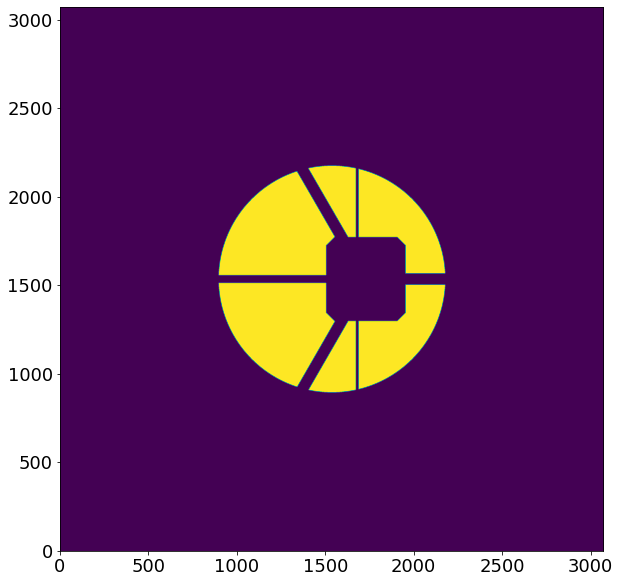

In [7]:
# this is the full pupil - just cutout of the pupil and all of the obstructions in - but without FRD

plt.figure(figsize=(10,10))
aperilluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'aperilluminated.npy') 
plt.imshow(aperilluminated,origin='lower')
aperilluminated.shape

Text(0.5,1,'1d plot of the illumination')

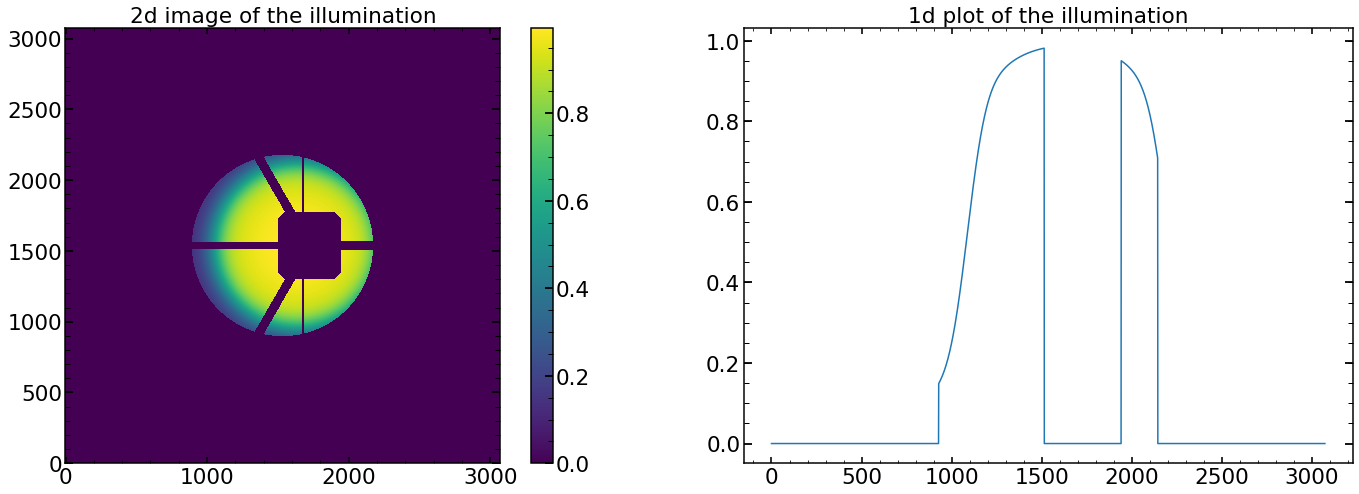

In [90]:
# after we have included the implementation of the FRD and the effective FRD

r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') 

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.imshow(r,origin='lower')
plt.colorbar()
plt.title('2d image of the illumination')

plt.subplot(122)
plt.plot(r[int(r.shape[0]/2+200)])
plt.title('1d plot of the illumination')

## wavefront on the exit pupil

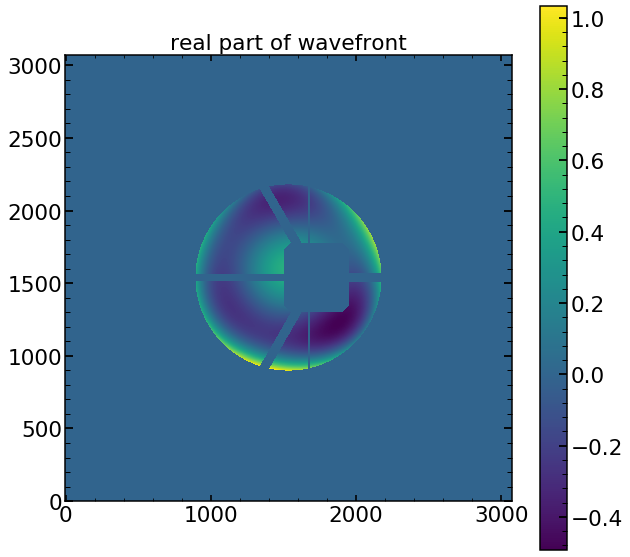

In [9]:
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
plt.figure(figsize=(10,10))
plt.imshow(np.real(wf_grid),origin='lower')
plt.title('real part of wavefront')
plt.colorbar()

(3072, 3072)

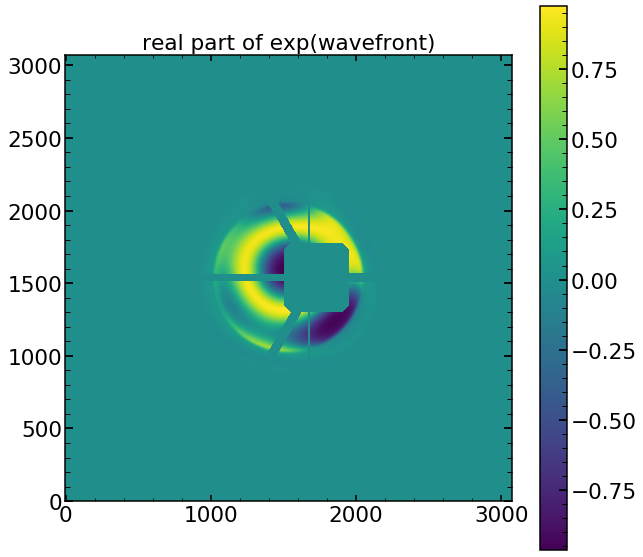

In [10]:
expwf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'expwf_grid.npy')  
plt.figure(figsize=(10,10))
plt.title('real part of exp(wavefront)')
plt.imshow(np.real(expwf_grid),origin='lower')
plt.colorbar()
np.real(expwf_grid).shape

## single spot 

Text(0.5,1,'result of FFT, zoomed in')

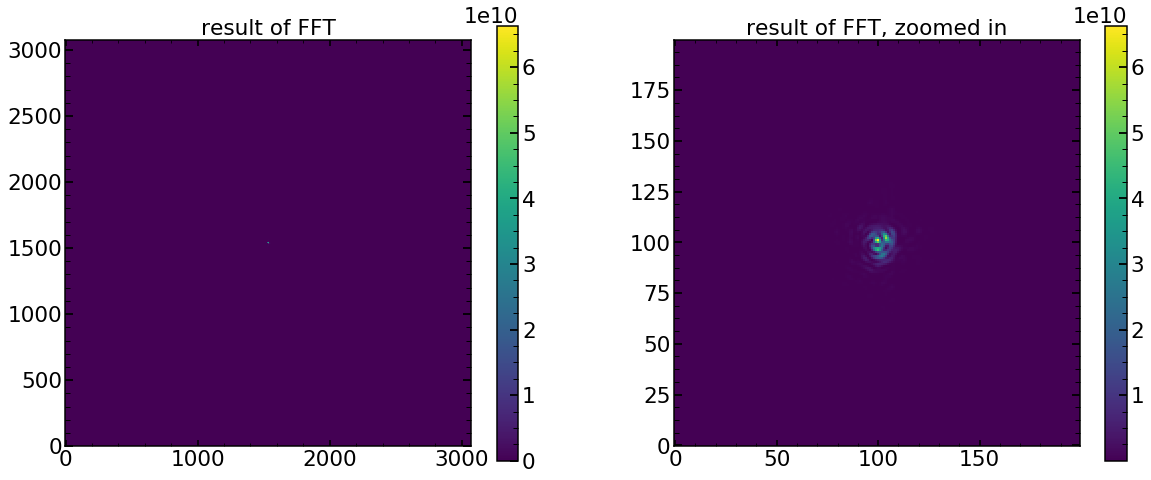

In [11]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower')
middleposition=int(optPsf.shape[0]/2)
cbar=plt.colorbar()

plt.title('result of FFT')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower')
cbar=plt.colorbar()

plt.title('result of FFT, zoomed in')

Text(0.5,1,'result of FFT, zoomed in, log')

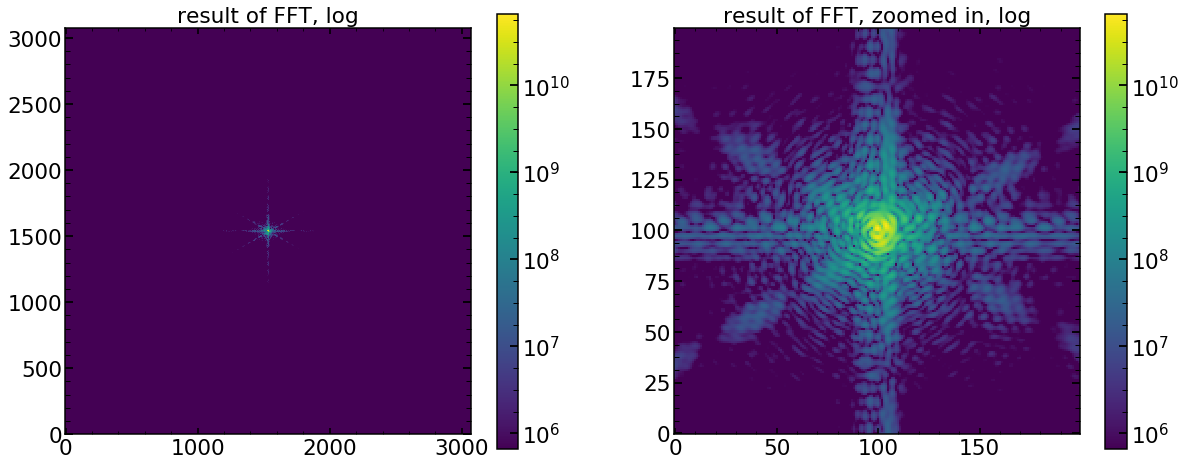

In [12]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

## spot convolved with fiber 

Text(0.5,1,'fiber convolved spot, zoomed in')

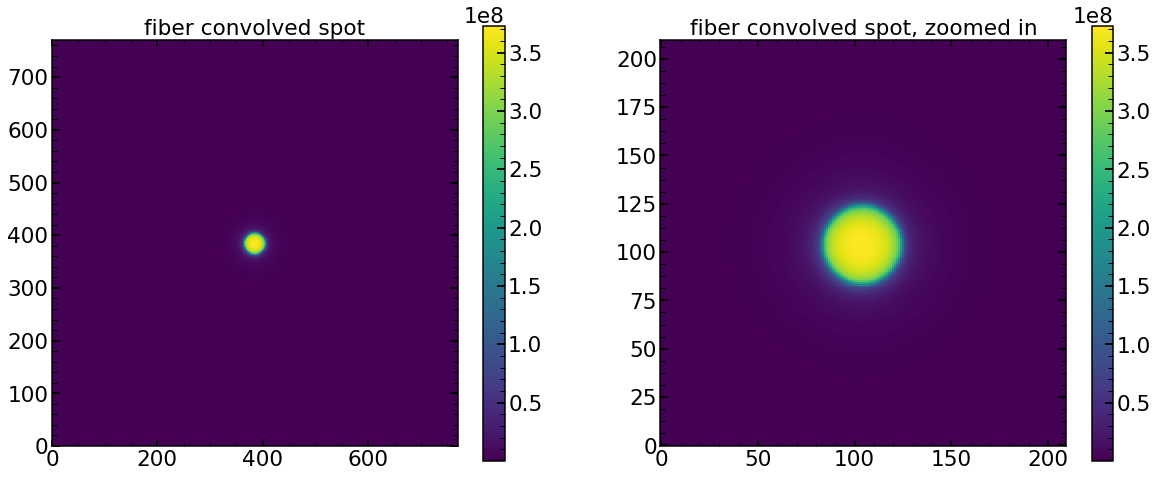

In [15]:
optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')    
middleposition=int(optPsf_cut_fiber_convolved.shape[0]/2)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower')
plt.colorbar()
plt.title('fiber convolved spot')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber convolved spot, zoomed in')

Text(0.5,1,'fiber convolved spot, zoomed in, log')

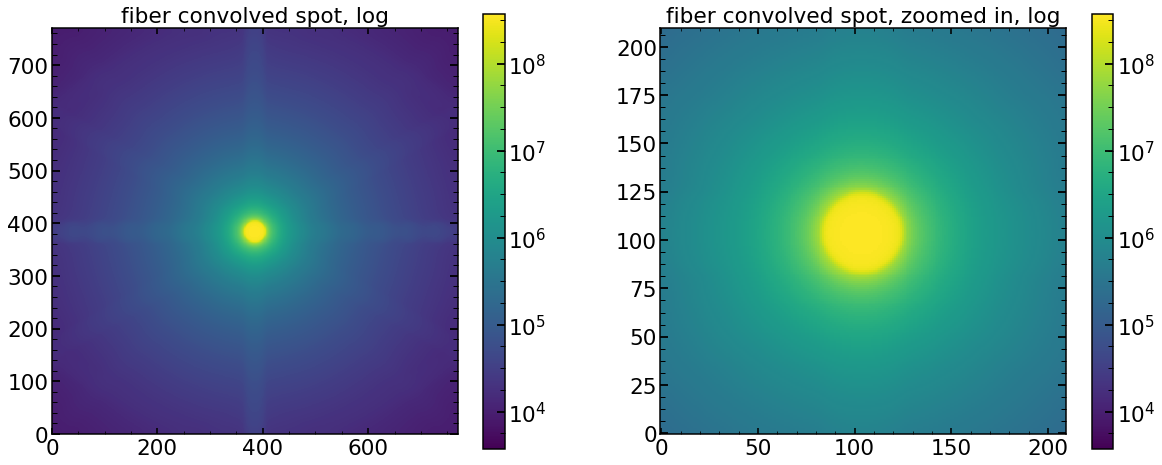

In [16]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber convolved spot, log')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber convolved spot, zoomed in, log')

## spot convolved with fiber and pixel reponse

Text(0.5,1,'fiber and pixel convolved spot, zoomed in')

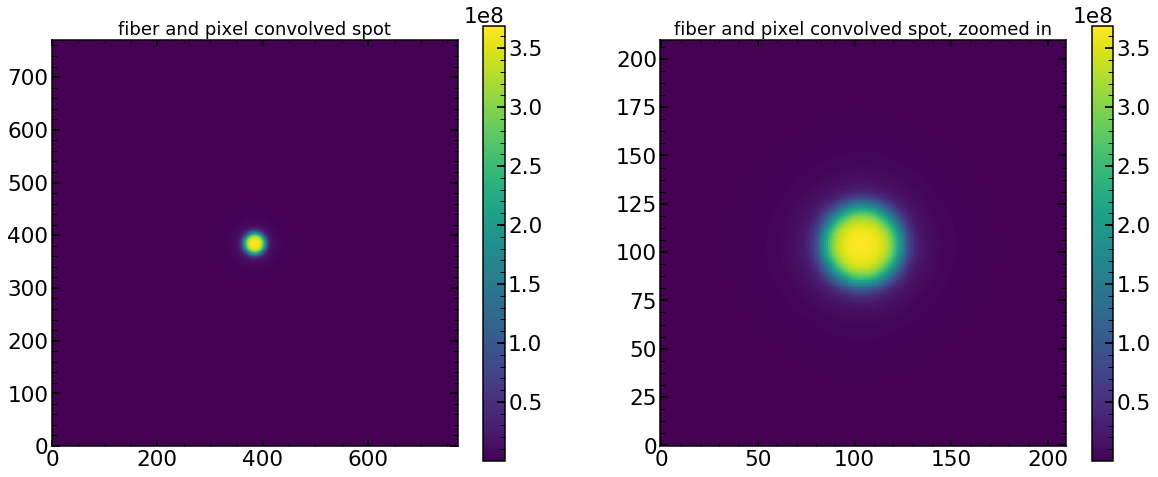

In [17]:
optPsf_cut_pixel_response_convolve=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')   
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber and pixel convolved spot, zoomed in', fontsize=18)

Text(0.5,1,'fiber and pixel convolved spot, zoomed in, log')

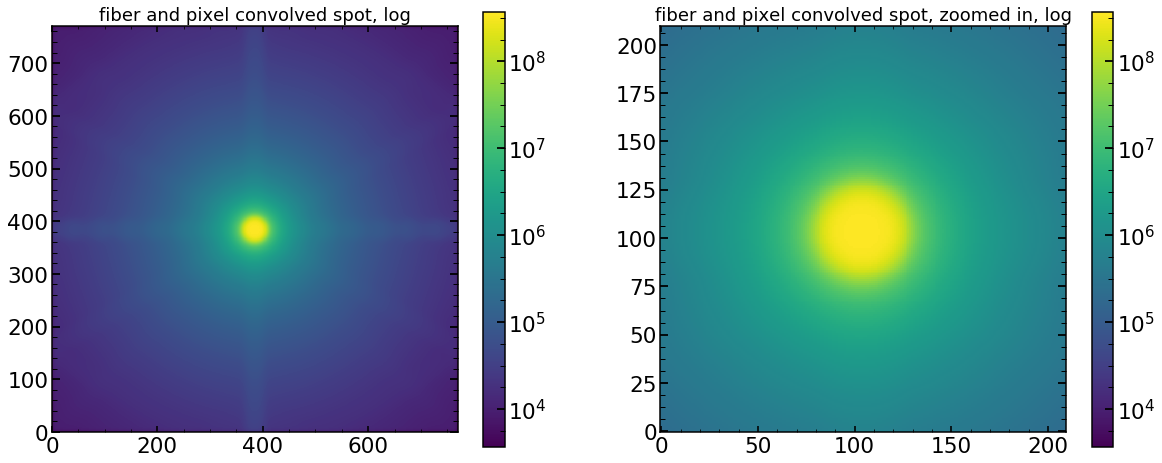

In [18]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_pixel_response_convolve,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber and pixel convolved spot, log', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_pixel_response_convolve[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_pixel_response_convolve)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('fiber and pixel convolved spot, zoomed in, log', fontsize=18)

## final result

Text(0.5,1,'final result, log scale')

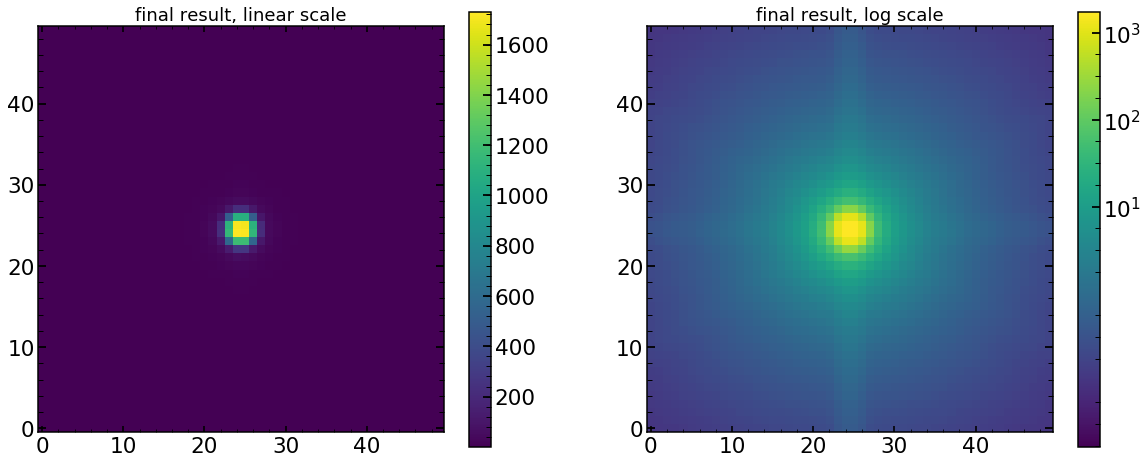

In [19]:
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')   

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved_downsampled,origin='lower')
plt.colorbar()
plt.title('final result, linear scale', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved_downsampled,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result, log scale', fontsize=18)

Text(0.5,1,'final result  with noise, log scale')

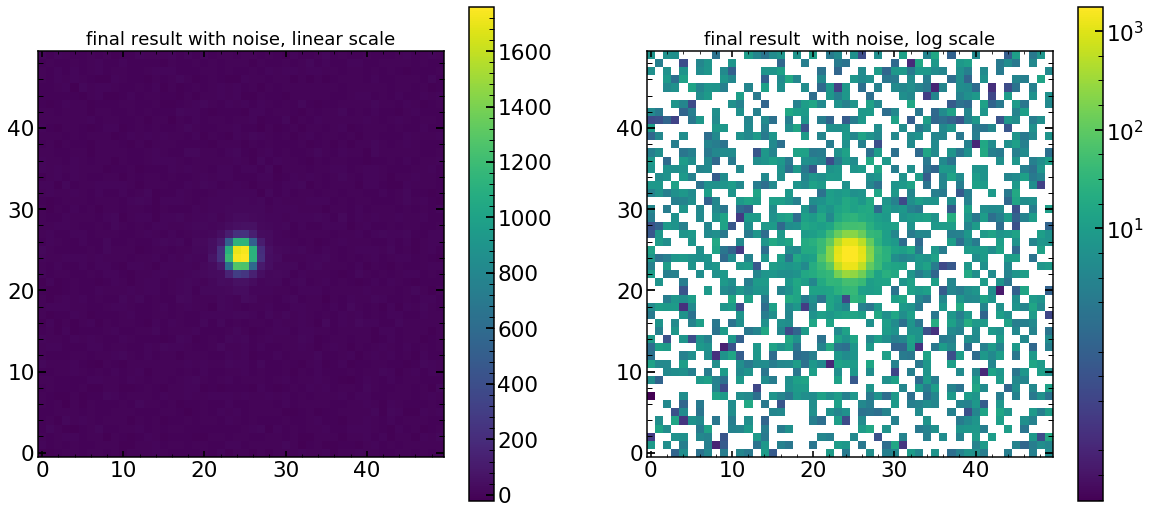

In [20]:
# this part adds noise to the perfect models

# as a very simplified model, assume that the variance images is the same as the science image + some read noise 
var_image=optPsf_cut_fiber_convolved_downsampled+40

artifical_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
for i in range(len(artifical_noise_data)):
    for j in range(len(artifical_noise_data)):
        artifical_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))
        

plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower')
plt.colorbar()
plt.title('final result with noise, linear scale', fontsize=18)
cbar.set_ticks([10,10**2,10**3,10**4,10**5])

plt.subplot(222)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower',norm=LogNorm(),vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
cbar=plt.colorbar()
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result  with noise, log scale', fontsize=18)        


## final result with arcsinh scaling 

In [23]:
# Create an ImageNormalize object
from astropy.visualization import ( AsinhStretch,
                                   ImageNormalize)

norm = ImageNormalize(optPsf_cut_fiber_convolved_downsampled, vmax=1000,
                      stretch=AsinhStretch())

Text(0.5,1,'final result  with noise, log scale')

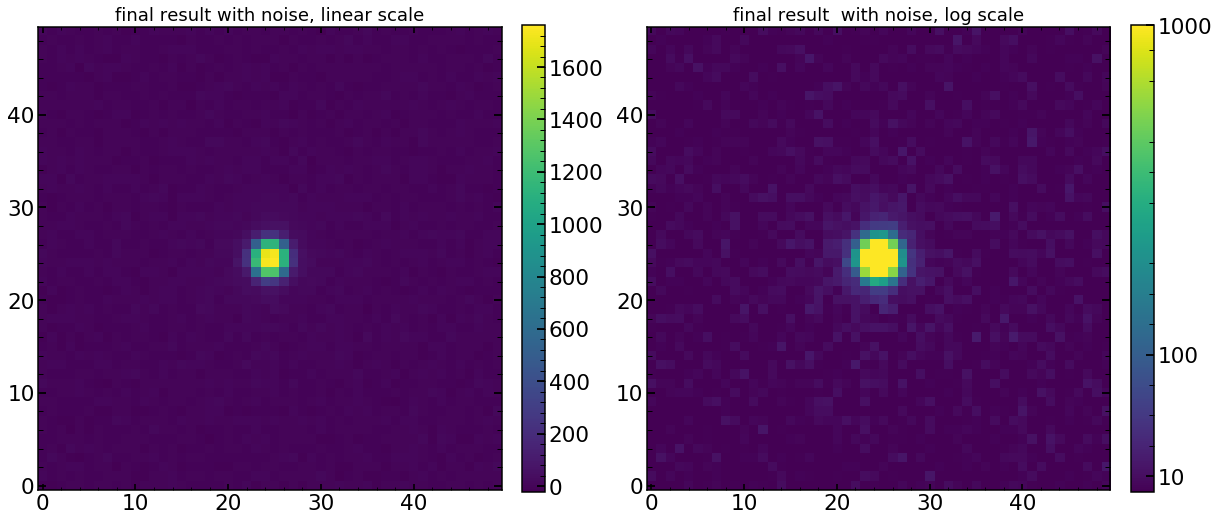

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('final result with noise, linear scale', fontsize=18)

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved_downsampled+artifical_noise_data,origin='lower',norm=norm,vmin=np.max(optPsf_cut_fiber_convolved_downsampled)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('final result  with noise, log scale', fontsize=18)        



# Few Images showing how optical PSF results change when changing parameters

In [44]:
# In the examples below, we have removed all the other abberations so that we can more clearly see the difference when adding specific abberations

## Adding astigmatism (Z5 and Z6)

In [38]:
allparameters_proposal=np.array([0,1,0,0,0,0,0,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


model(allparameters_proposal)

31


-1150009.1702820328

Text(0.5,1,'result of FFT, zoomed in, log')

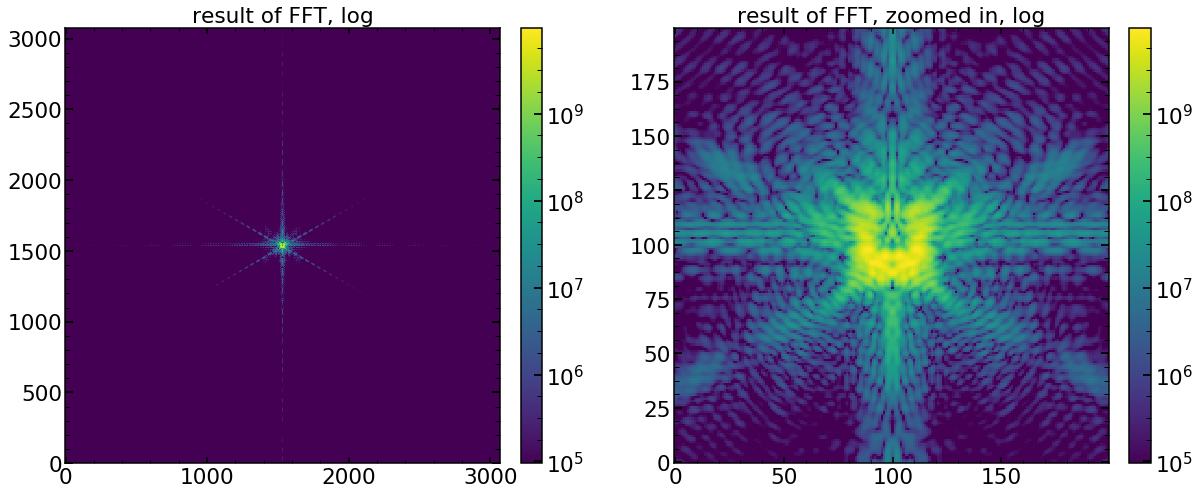

In [39]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
middleposition=int(optPsf.shape[0]/2)

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

## Adding coma (Z7 and Z8)

In [40]:
allparameters_proposal=np.array([0,0,0,1,0,0,0,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


model(allparameters_proposal)

31


-1102622.6961894836

Text(0.5,1,'result of FFT, zoomed in, log')

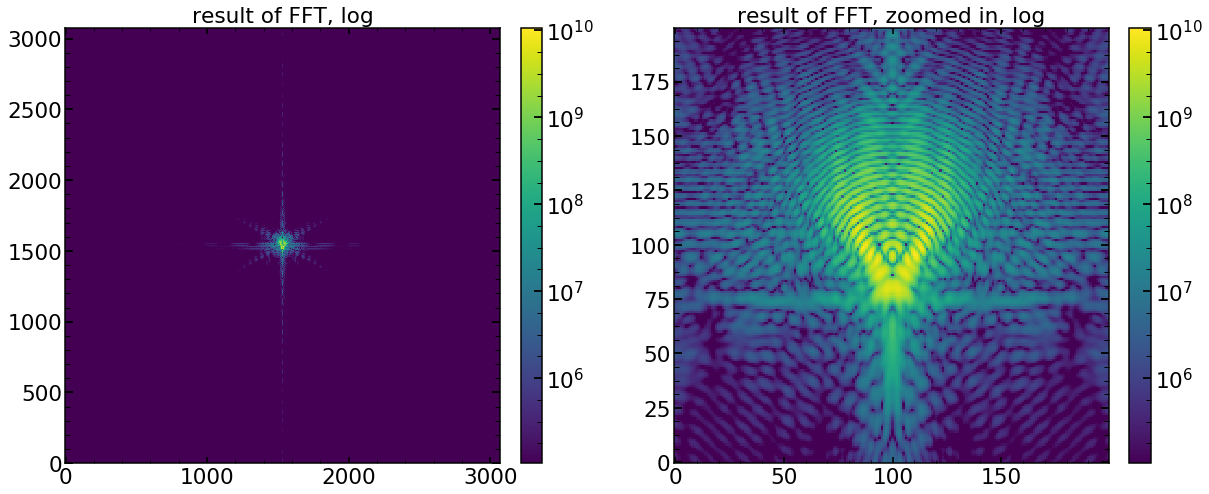

In [41]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

## Adding trefoil (Z9 and Z10)

In [42]:
allparameters_proposal=np.array([0,0,0,0,0,1,1,0,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])


model(allparameters_proposal)

31


-1088588.358730731

Text(0.5,1,'result of FFT, zoomed in, log')

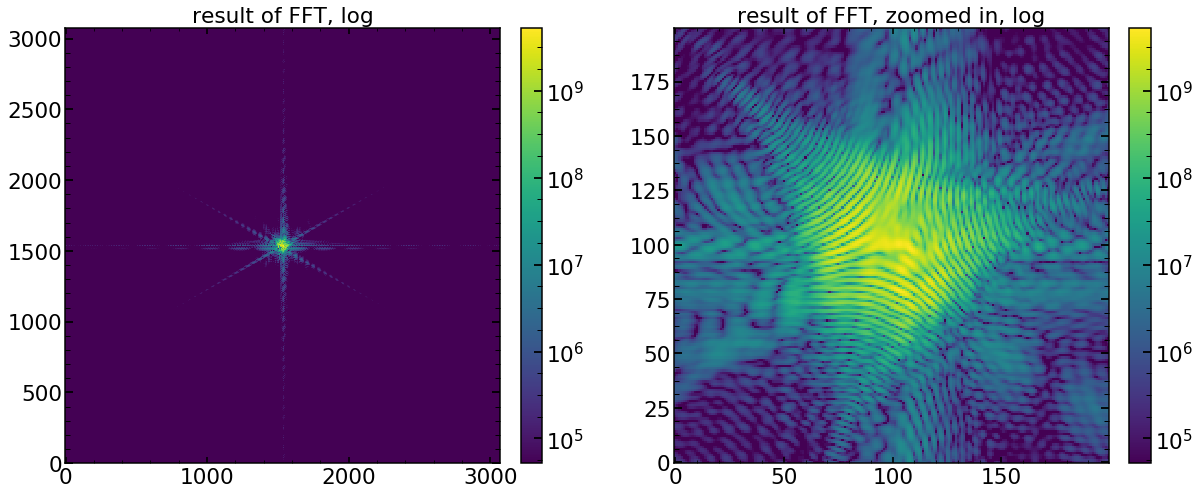

In [43]:
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

In [ ]:
r=np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') 

plt.figure(figsize=(24,8))
plt.subplot(121)
plt.imshow(r,origin='lower')
plt.colorbar()
plt.title('2d image of the illumination')

plt.subplot(122)
plt.plot(r[int(r.shape[0]/2+200)])
plt.title('1d plot of the illumination')

######

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')    
middleposition=int(optPsf_cut_fiber_convolved.shape[0]/2)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf_cut_fiber_convolved,origin='lower')
plt.colorbar()
plt.title('fiber convolved spot')

plt.subplot(122)
plt.imshow(optPsf_cut_fiber_convolved[middleposition-105:middleposition+105,middleposition-105:middleposition+105],origin='lower')
plt.colorbar()
plt.title('fiber convolved spot, zoomed in')

######

TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_grating_convolved_simulation_cut.npy"

#######

optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy') 
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.imshow(optPsf,origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, log')

plt.subplot(122)
plt.imshow(optPsf[middleposition-100:middleposition+100,middleposition-100:middleposition+100],origin='lower',norm=LogNorm(),vmax=np.max(optPsf),vmin=np.max(optPsf)/10**5)
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])
plt.title('result of FFT, zoomed in, log')

In [18]:
#res=model2(get_PSF_parameters(0.0603,'m4',64,1),return_Image=True)
#Base_out_of_focus = np.load(TESTING_PUPIL_IMAGES_FOLDER+"optPsf_cut_grating_convolved_simulation_cut.npy") 

res=model2(get_PSF_parameters(0.0603,'0',1,1),return_Image=True)
Base_out_of_focus = np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') #Technically this is the pupil, not the out-of-focus image
Base_in_focus = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy") 

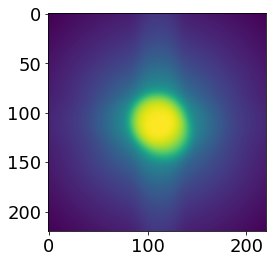

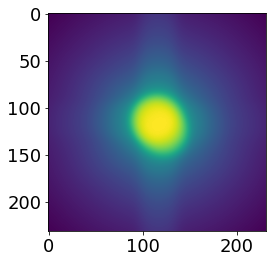

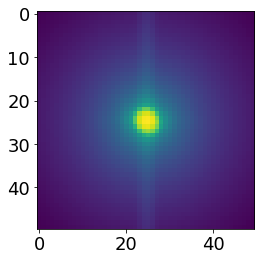

In [22]:
imagetest = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_grating_convolved_simulation_cut.npy")
plt.imshow(imagetest,norm=LogNorm())
plt.show()

imagetest = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_grating_convolved_simulation_cut_odd.npy") #What is the difference in odd?
plt.imshow(imagetest,norm=LogNorm())
plt.show()

imagetest = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy")
plt.imshow(imagetest,norm=LogNorm())
plt.show()

#optPsf_cut_fiber_convolved_downsampled

## as a very simplified model, assume that the variance images is the same as the science image + some read noise 
#var_image=optPsf_cut_fiber_convolved_downsampled+40
#
#artifical_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
#for i in range(len(artifical_noise_data)):
#    for j in range(len(artifical_noise_data)):
#        artifical_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))

In [13]:
res=model2(get_PSF_parameters(0.1206,'0',64,1),return_Image=True)
New_out_of_focus = np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') #Technically this is the pupil, not the out-of-focus image
New_in_focus = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy") 

In [196]:
import matplotlib.colors as mcolors

def EntryCreate(FRD,position):
    numbervalues = get_PSF_parameters(0.0603,'0',position,1) #The FRD component doesn't affect which data entry is read.
    effective_illum_radius = numbervalues[31]
    #effective_illum_radius = 0.92 #Simulate this effect for now...
    sigma_FRD_code = FRD/(np.sqrt(2))*effective_illum_radius*(2*2.8)
    res=model2(get_PSF_parameters(sigma_FRD_code,'0',position,1),return_Image=True)
    Out_of_focus = np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') #Technically this is the pupil, not the out-of-focus image
    In_focus = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy") 
    return Out_of_focus,In_focus

def EntryCreate_sim(FRD,position):
    numbervalues = get_PSF_parameters(0.0603,'0',position,1) #The FRD component doesn't affect which data entry is read.
    effective_illum_radius = numbervalues[31]
    #effective_illum_radius = 0.92 #Simulate this effect for now...
    sigma_FRD_code = FRD/(np.sqrt(2))*effective_illum_radius*(2*2.8)
    res=model2(get_PSF_parameters(sigma_FRD_code,'0',position,1),return_Image=True)
    Out_of_focus = np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') #Technically this is the pupil, not the out-of-focus image
    In_focus = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved.npy") 
    return Out_of_focus,In_focus

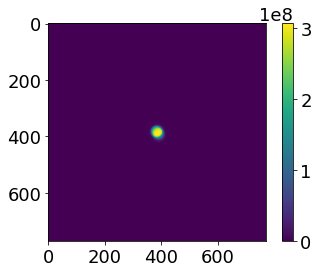

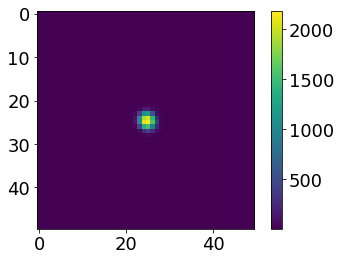

In [195]:
optpsf_test1 = np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optpsf_test2 = np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')
plt.imshow(optpsf_test1)#,norm=LogNorm()
plt.colorbar()
plt.show()
plt.imshow(optpsf_test2)
plt.colorbar()
plt.show()

<ipython-input-44-fa1252eb6a8d>:15: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min()-0.01, vmax = d.max()+0.01, vcenter=0)
<ipython-input-44-fa1252eb6a8d>:33: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


Text(0.5, 1.0, 'Difference from sigma_frd = 0.06')

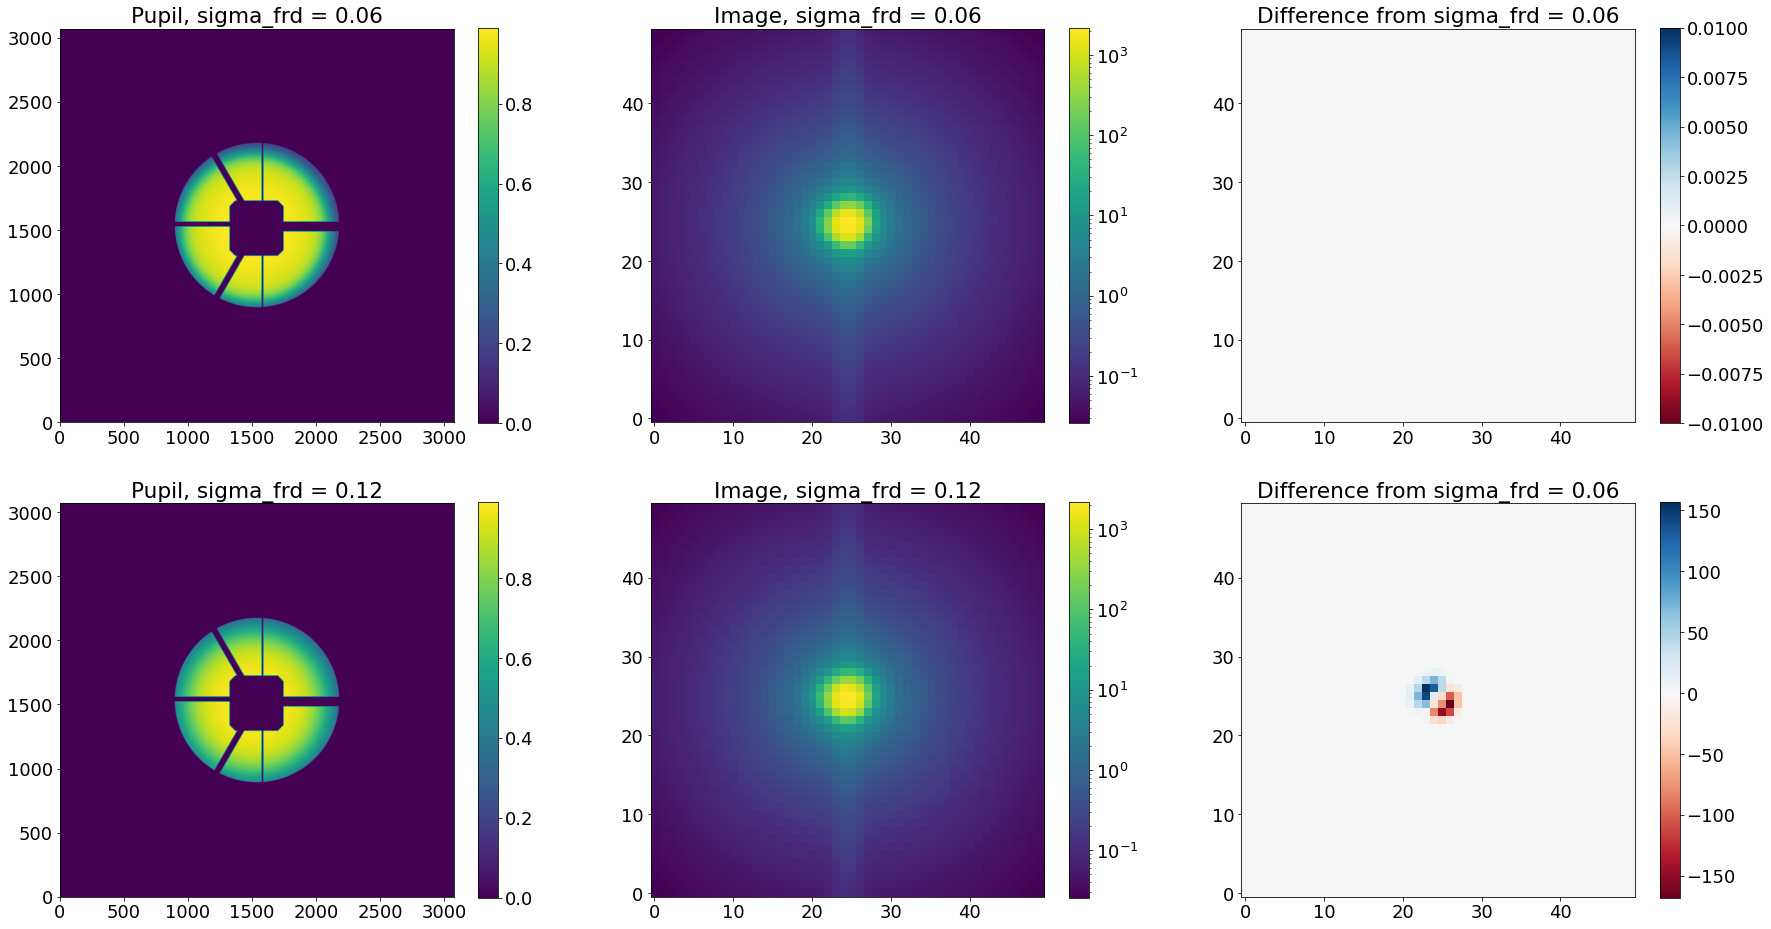

In [44]:
plt.figure(figsize=(30,16))
plt.subplot(231)
plt.imshow(Base_out_of_focus,origin='lower',vmax=np.max(Base_out_of_focus))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, sigma_frd = 0.06') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(232)
plt.imshow(Base_in_focus,origin='lower',norm=LogNorm(),vmax=np.max(Base_in_focus))
cbar=plt.colorbar()
plt.title('Image, sigma_frd = 0.06') 

plt.subplot(233)
d = Base_in_focus-Base_in_focus
norm = mcolors.DivergingNorm(vmin=d.min()-0.01, vmax = d.max()+0.01, vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference from sigma_frd = 0.06') 

plt.subplot(234)
plt.imshow(New_out_of_focus,origin='lower',vmax=np.max(Base_out_of_focus))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, sigma_frd = 0.12') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(235)
plt.imshow(New_in_focus,origin='lower',norm=LogNorm(),vmax=np.max(Base_in_focus))
cbar=plt.colorbar()
plt.title('Image, sigma_frd = 0.12') 

plt.subplot(236)
d=New_in_focus-Base_in_focus
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference from sigma_frd = 0.06') 

In [25]:
Out6,In6 = EntryCreate(0.006,64)
Out9,In9 = EntryCreate(0.009,64)
Out12,In12 = EntryCreate(0.012,64)
Out15,In15 = EntryCreate(0.015,64)
Out18,In18 = EntryCreate(0.018,64)
Out21,In21 = EntryCreate(0.021,64)
Out24,In24 = EntryCreate(0.024,64)
Out27,In27 = EntryCreate(0.027,64)
Out30,In30 = EntryCreate(0.030,64)

In [197]:
from scipy.ndimage.measurements import center_of_mass

Out6_sim,In6_sim = EntryCreate_sim(0.006,64)
Out9_sim,In9_sim = EntryCreate_sim(0.009,64)
Out12_sim,In12_sim = EntryCreate_sim(0.012,64)
Out15_sim,In15_sim = EntryCreate_sim(0.015,64)
Out18_sim,In18_sim = EntryCreate_sim(0.018,64)
Out21_sim,In21_sim = EntryCreate_sim(0.021,64)
Out24_sim,In24_sim = EntryCreate_sim(0.024,64)
Out27_sim,In27_sim = EntryCreate_sim(0.027,64)
Out30_sim,In30_sim = EntryCreate_sim(0.030,64)

print(center_of_mass(In6))
print(center_of_mass(In12))
print(center_of_mass(In18))
print(center_of_mass(In24))
print(center_of_mass(In30))

print(center_of_mass(In6_sim))
print(center_of_mass(In12_sim))
print(center_of_mass(In18_sim))
print(center_of_mass(In24_sim))
print(center_of_mass(In30_sim))

(24.714103682278896, 24.530310247421223)
(24.704029330489124, 24.526770647828688)
(24.698054239567014, 24.522206209433996)
(24.694649556769917, 24.517745736902967)
(24.693234604852965, 24.51348256536593)
(386.8595648231938, 384.8366038490235)
(386.7486292381171, 384.7976946013302)
(386.6828245909564, 384.74749107555493)
(386.64531727228666, 384.6984251417939)
(386.6297173433189, 384.6515249105603)


<ipython-input-133-9802146f3ba2>:15: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
<ipython-input-133-9802146f3ba2>:33: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-133-9802146f3ba2>:51: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-133-9802146f3ba2>:69: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNo

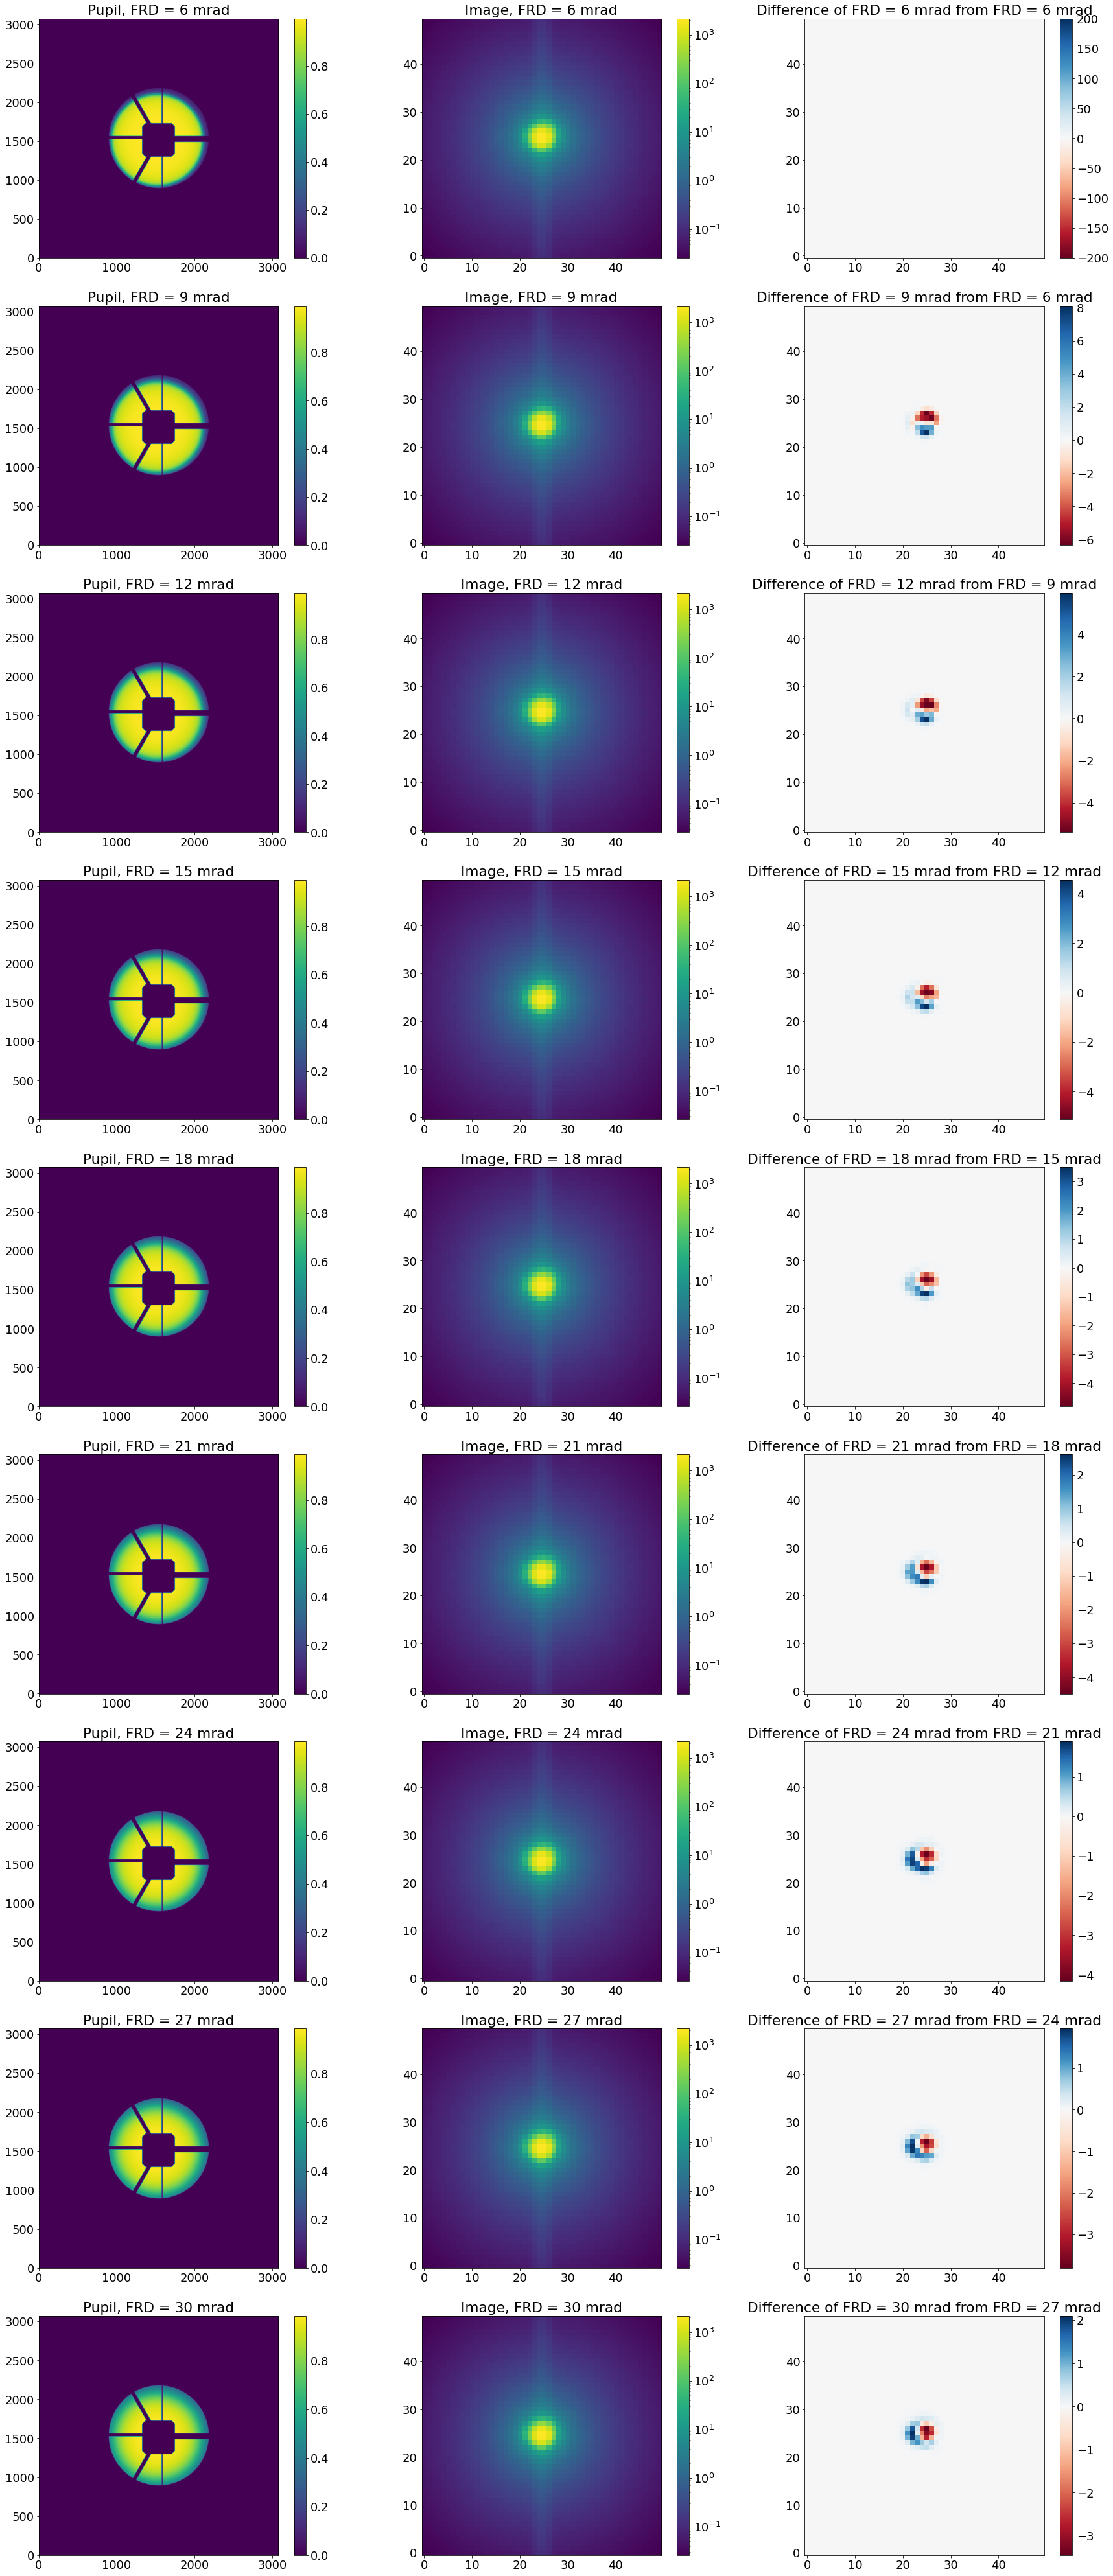

In [133]:
plt.figure(figsize=(30,72))
plt.subplot(9,3,1)
plt.imshow(Out6,origin='lower',vmax=np.max(Out6))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 6 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,2)
plt.imshow(In6,origin='lower',norm=LogNorm(),vmax=np.max(In6))
cbar=plt.colorbar()
plt.title('Image, FRD = 6 mrad') 

plt.subplot(9,3,3)
d = In6-In6
norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 6 mrad from FRD = 6 mrad') 

plt.subplot(9,3,4)
plt.imshow(Out9,origin='lower',vmax=np.max(Out9))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 9 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,5)
plt.imshow(In9,origin='lower',norm=LogNorm(),vmax=np.max(In9))
cbar=plt.colorbar()
plt.title('Image, FRD = 9 mrad') 

plt.subplot(9,3,6)
d=In9-In6
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 9 mrad from FRD = 6 mrad') 

plt.subplot(9,3,7)
plt.imshow(Out12,origin='lower',vmax=np.max(Out12))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 12 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,8)
plt.imshow(In12,origin='lower',norm=LogNorm(),vmax=np.max(In12))
cbar=plt.colorbar()
plt.title('Image, FRD = 12 mrad') 

plt.subplot(9,3,9)
d=In12-In9
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 12 mrad from FRD = 9 mrad') 

plt.subplot(9,3,10)
plt.imshow(Out15,origin='lower',vmax=np.max(Out15))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 15 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,11)
plt.imshow(In15,origin='lower',norm=LogNorm(),vmax=np.max(In15))
cbar=plt.colorbar()
plt.title('Image, FRD = 15 mrad') 

plt.subplot(9,3,12)
d=In15-In12
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 15 mrad from FRD = 12 mrad') 

plt.subplot(9,3,13)
plt.imshow(Out18,origin='lower',vmax=np.max(Out18))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 18 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,14)
plt.imshow(In18,origin='lower',norm=LogNorm(),vmax=np.max(In18))
cbar=plt.colorbar()
plt.title('Image, FRD = 18 mrad') 

plt.subplot(9,3,15)
d=In18-In15
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 18 mrad from FRD = 15 mrad') 

plt.subplot(9,3,16)
plt.imshow(Out21,origin='lower',vmax=np.max(Out21))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 21 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,17)
plt.imshow(In21,origin='lower',norm=LogNorm(),vmax=np.max(In21))
cbar=plt.colorbar()
plt.title('Image, FRD = 21 mrad') 

plt.subplot(9,3,18)
d=In21-In18
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 21 mrad from FRD = 18 mrad') 

plt.subplot(9,3,19)
plt.imshow(Out24,origin='lower',vmax=np.max(Out24))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 24 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,20)
plt.imshow(In24,origin='lower',norm=LogNorm(),vmax=np.max(In24))
cbar=plt.colorbar()
plt.title('Image, FRD = 24 mrad') 

plt.subplot(9,3,21)
d=In24-In21
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 24 mrad from FRD = 21 mrad') 

plt.subplot(9,3,22)
plt.imshow(Out27,origin='lower',vmax=np.max(Out27))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 27 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,23)
plt.imshow(In27,origin='lower',norm=LogNorm(),vmax=np.max(In27))
cbar=plt.colorbar()
plt.title('Image, FRD = 27 mrad') 

plt.subplot(9,3,24)
d=In27-In24
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 27 mrad from FRD = 24 mrad') 

plt.subplot(9,3,25)
plt.imshow(Out30,origin='lower',vmax=np.max(Out30))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 30 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,26)
plt.imshow(In30,origin='lower',norm=LogNorm(),vmax=np.max(In30))
cbar=plt.colorbar()
plt.title('Image, FRD = 30 mrad') 

plt.subplot(9,3,27)
d=In30-In27
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 30 mrad from FRD = 27 mrad') 

plt.savefig('CenterFRD_2.png',bbox_inches='tight')

<ipython-input-128-eca1f1bfeedb>:24: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min()-0.01, vmax = d.max()+0.01, vcenter=0)
<ipython-input-128-eca1f1bfeedb>:42: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


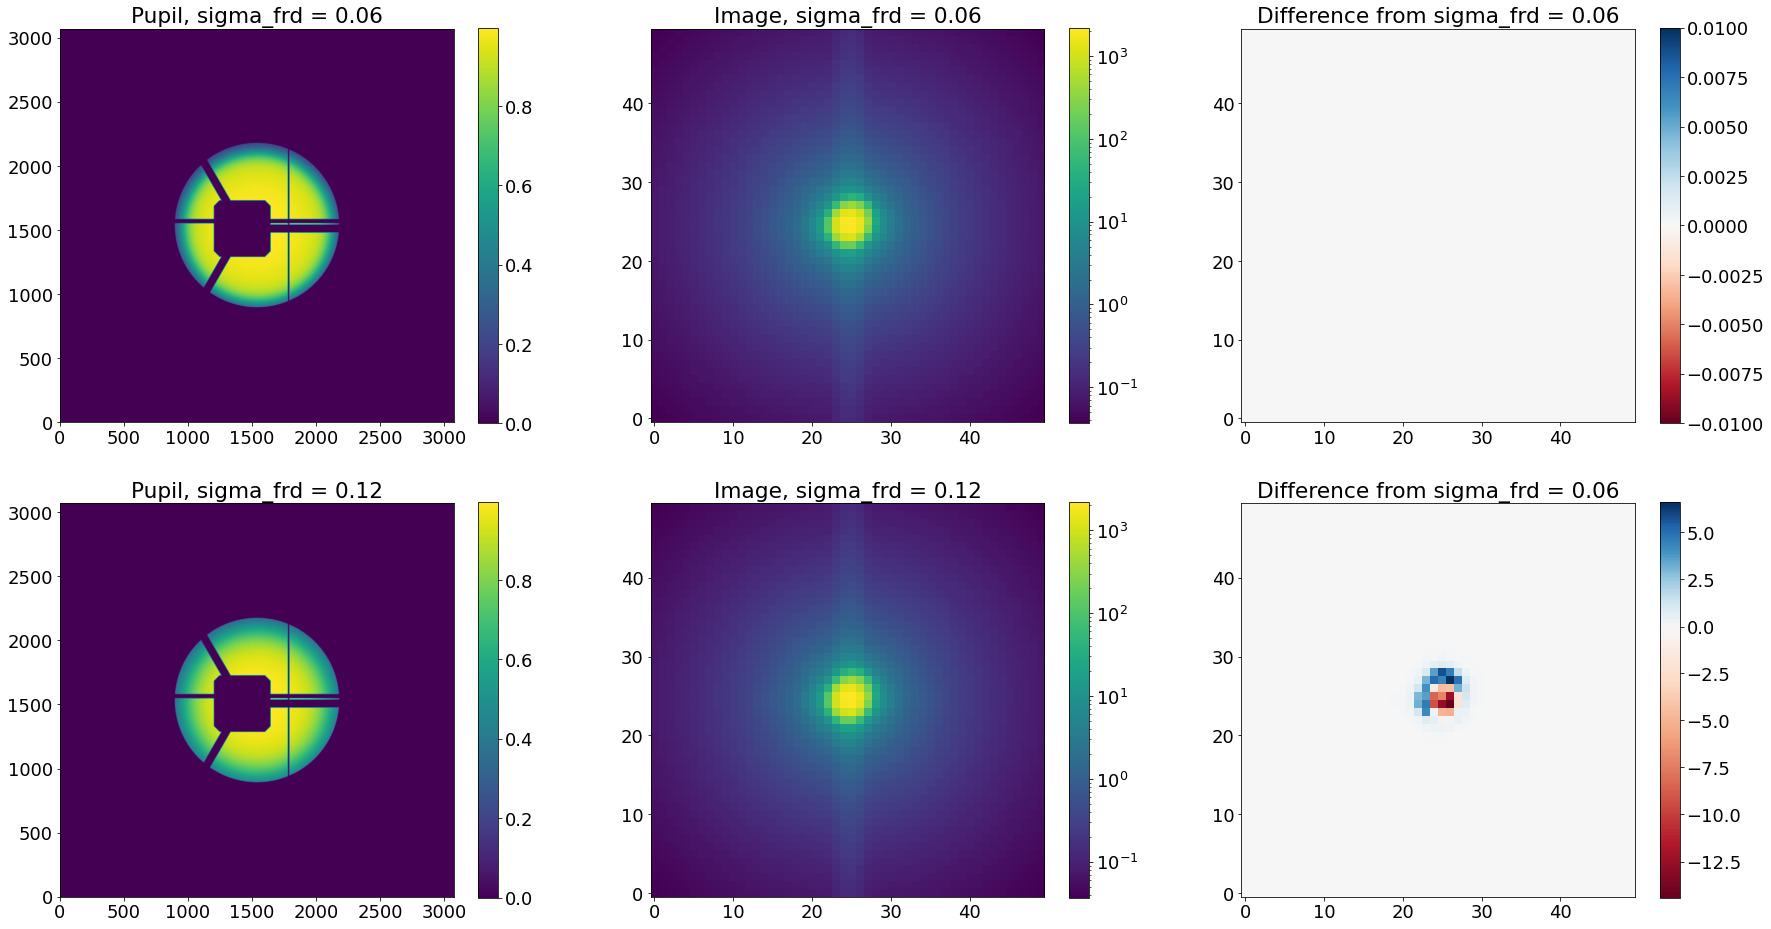

In [128]:
res=model2(get_PSF_parameters(0.0603,'0',1,1),return_Image=True)
Base_out_of_focus2 = np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') #Technically this is the pupil, not the out-of-focus image
Base_in_focus2 = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy") 

res=model2(get_PSF_parameters(0.1206,'0',1,1),return_Image=True)
New_out_of_focus2 = np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') #Technically this is the pupil, not the out-of-focus image
New_in_focus2 = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy") 


plt.figure(figsize=(30,16))
plt.subplot(231)
plt.imshow(Base_out_of_focus2,origin='lower')
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, sigma_frd = 0.06') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(232)
plt.imshow(Base_in_focus2,origin='lower',norm=LogNorm())
cbar=plt.colorbar()
plt.title('Image, sigma_frd = 0.06') 

plt.subplot(233)
d = Base_in_focus2-Base_in_focus2
norm = mcolors.DivergingNorm(vmin=d.min()-0.01, vmax = d.max()+0.01, vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference from sigma_frd = 0.06') 

plt.subplot(234)
plt.imshow(New_out_of_focus2,origin='lower')
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, sigma_frd = 0.12') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(235)
plt.imshow(New_in_focus2,origin='lower',norm=LogNorm())
cbar=plt.colorbar()
plt.title('Image, sigma_frd = 0.12') 

plt.subplot(236)
d=New_in_focus2-Base_in_focus2
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference from sigma_frd = 0.06') 

plt.savefig('EdgeFRD_1.png')

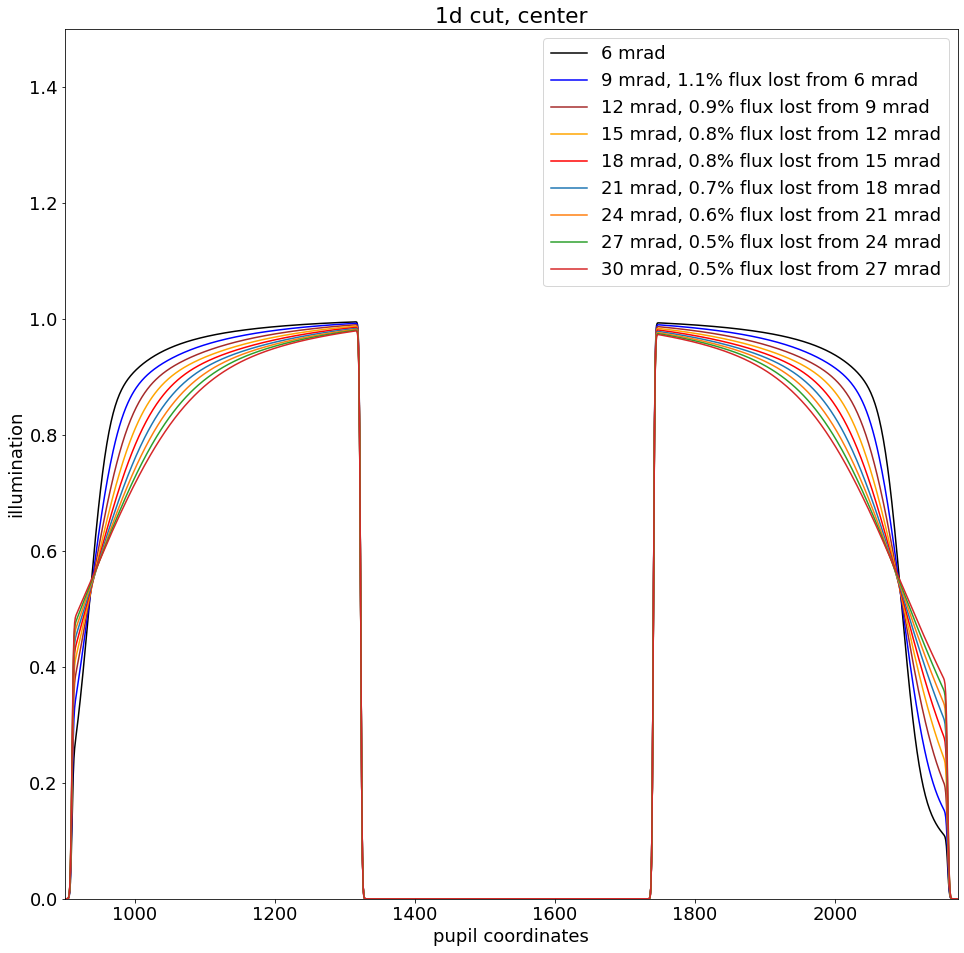

In [151]:
plt.figure(figsize=(16,16))

plt.plot(Out6[1400],color='black',label='6 mrad')
plt.plot(Out9[1400],color='blue',label='9 mrad, '+"{:1.1f}".format((((1-(np.sum(Out9)/np.sum(Out6)))*100)))+'% flux lost from 6 mrad')
plt.plot(Out12[1400],color='brown',label='12 mrad, '+"{:1.1f}".format((((1-(np.sum(Out12)/np.sum(Out9)))*100)))+'% flux lost from 9 mrad')
plt.plot(Out15[1400],color='orange',label='15 mrad, '+"{:1.1f}".format((((1-(np.sum(Out15)/np.sum(Out12)))*100)))+'% flux lost from 12 mrad')
plt.plot(Out18[1400],color='red',label='18 mrad, '+"{:1.1f}".format((((1-(np.sum(Out18)/np.sum(Out15)))*100)))+'% flux lost from 15 mrad')
plt.plot(Out21[1400],label='21 mrad, '+"{:1.1f}".format((((1-(np.sum(Out21)/np.sum(Out18)))*100)))+'% flux lost from 18 mrad')
plt.plot(Out24[1400],label='24 mrad, '+"{:1.1f}".format((((1-(np.sum(Out24)/np.sum(Out21)))*100)))+'% flux lost from 21 mrad')
plt.plot(Out27[1400],label='27 mrad, '+"{:1.1f}".format((((1-(np.sum(Out27)/np.sum(Out24)))*100)))+'% flux lost from 24 mrad')
plt.plot(Out30[1400],label='30 mrad, '+"{:1.1f}".format((((1-(np.sum(Out30)/np.sum(Out27)))*100)))+'% flux lost from 27 mrad')
plt.ylabel('illumination')
plt.xlabel('pupil coordinates')
plt.title('1d cut, center')
plt.xlim(900,2175)
plt.ylim(0,1.5)

plt.legend()

plt.savefig('Center_1DCut.png')

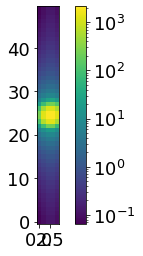

In [29]:
plt.imshow(In6[:,22:27],origin='lower',norm=LogNorm())
plt.colorbar()

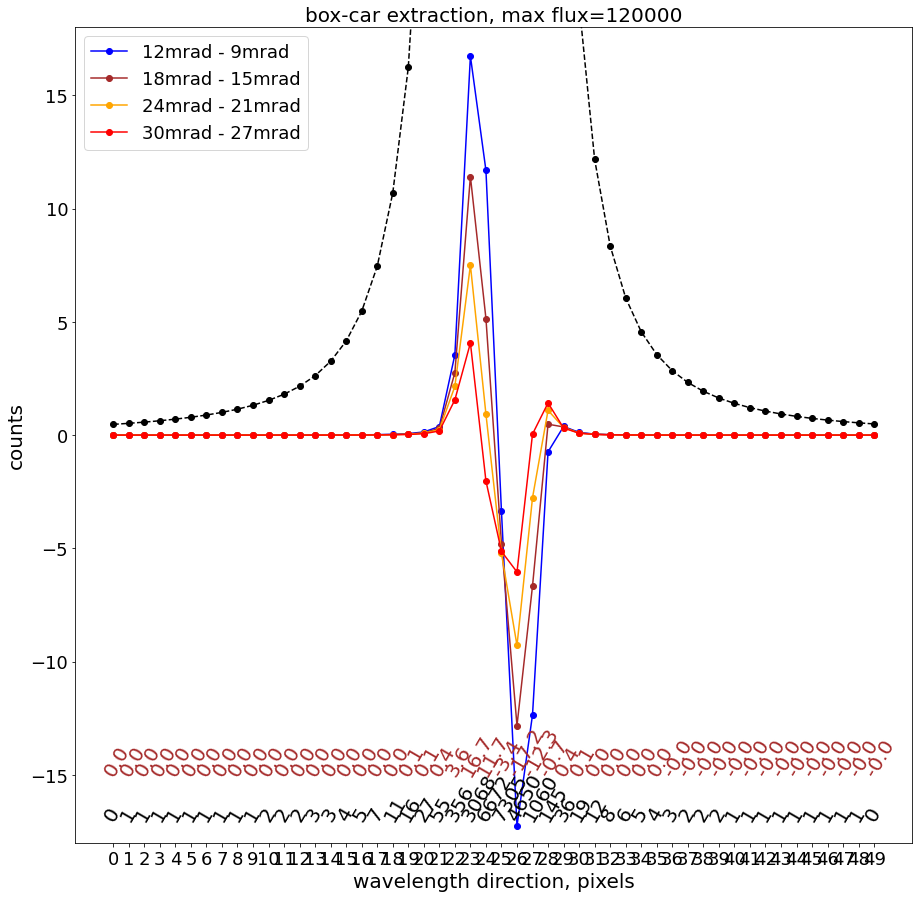

In [190]:
plt.figure(figsize=(15,15))

#plt.plot(np.sum(In9[:,22:27],axis=1)-np.sum(In6[:,22:27],axis=1),marker='o',color='blue',label='9mrad - 6mrad')
plt.plot(np.sum(In12[:,22:27],axis=1)-np.sum(In9[:,22:27],axis=1),marker='o',color='blue',label='12mrad - 9mrad')
#plt.plot(np.sum(In15[:,22:27],axis=1)-np.sum(In12[:,22:27],axis=1),marker='o',color='orange',label='15mrad - 12mrad')
plt.plot(np.sum(In18[:,22:27],axis=1)-np.sum(In15[:,22:27],axis=1),marker='o',color='brown',label='18mrad - 15mrad')
#plt.plot(np.sum(In21[:,22:27],axis=1)-np.sum(In18[:,22:27],axis=1),marker='o',label='21mrad - 18mrad')
plt.plot(np.sum(In24[:,22:27],axis=1)-np.sum(In21[:,22:27],axis=1),marker='o',color='orange',label='24mrad - 21mrad')
#plt.plot(np.sum(In27[:,22:27],axis=1)-np.sum(In24[:,22:27],axis=1),marker='o',label='27mrad - 24mrad')
plt.plot(np.sum(In30[:,22:27],axis=1)-np.sum(In27[:,22:27],axis=1),marker='o',color='red',label='30mrad - 27mrad')
plt.plot(np.sum(In6[:,22:27],axis=1),marker='o',color='black',ls='--')
#plt.plot(np.sum(sci_image[:,8:14],axis=1),marker='o',color='black',ls=':')
plt.ylabel("counts", fontsize=20)
plt.xlabel("wavelength direction, pixels", fontsize=20)
plt.title("box-car extraction, max flux=120000", fontsize=20)
plt.xticks(np.arange(0, len(In9[:,22]), step=1))
#plt.yticks(np.arange(-600,700, step=100))
plt.ylim(-18,18)
plt.legend(loc=2)
for i in range(50):
    plt.text(-0.8+i, -17, str("{:1.0f}".format(np.sum(In6[i,22:27]))), fontsize=20,rotation=60.)
    
for i in range(50):
    plt.text(-0.8+i, -15, str("{:0.1f}".format(np.sum(In12[:,22:27],axis=1)[i]-np.sum(In9[:,22:27],axis=1)[i])), fontsize=20,rotation=60.,color='brown')

plt.savefig('CenterFRD_boxcar.png')

In [28]:
OutE6,InE6 = EntryCreate(0.006,1)
OutE9,InE9 = EntryCreate(0.009,1)
OutE12,InE12 = EntryCreate(0.012,1)
OutE15,InE15 = EntryCreate(0.015,1)
OutE18,InE18 = EntryCreate(0.018,1)
OutE21,InE21 = EntryCreate(0.021,1)
OutE24,InE24 = EntryCreate(0.024,1)
OutE27,InE27 = EntryCreate(0.027,1)
OutE30,InE30 = EntryCreate(0.030,1)

<ipython-input-134-1679b031411c>:15: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
<ipython-input-134-1679b031411c>:33: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-134-1679b031411c>:51: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-134-1679b031411c>:69: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNo

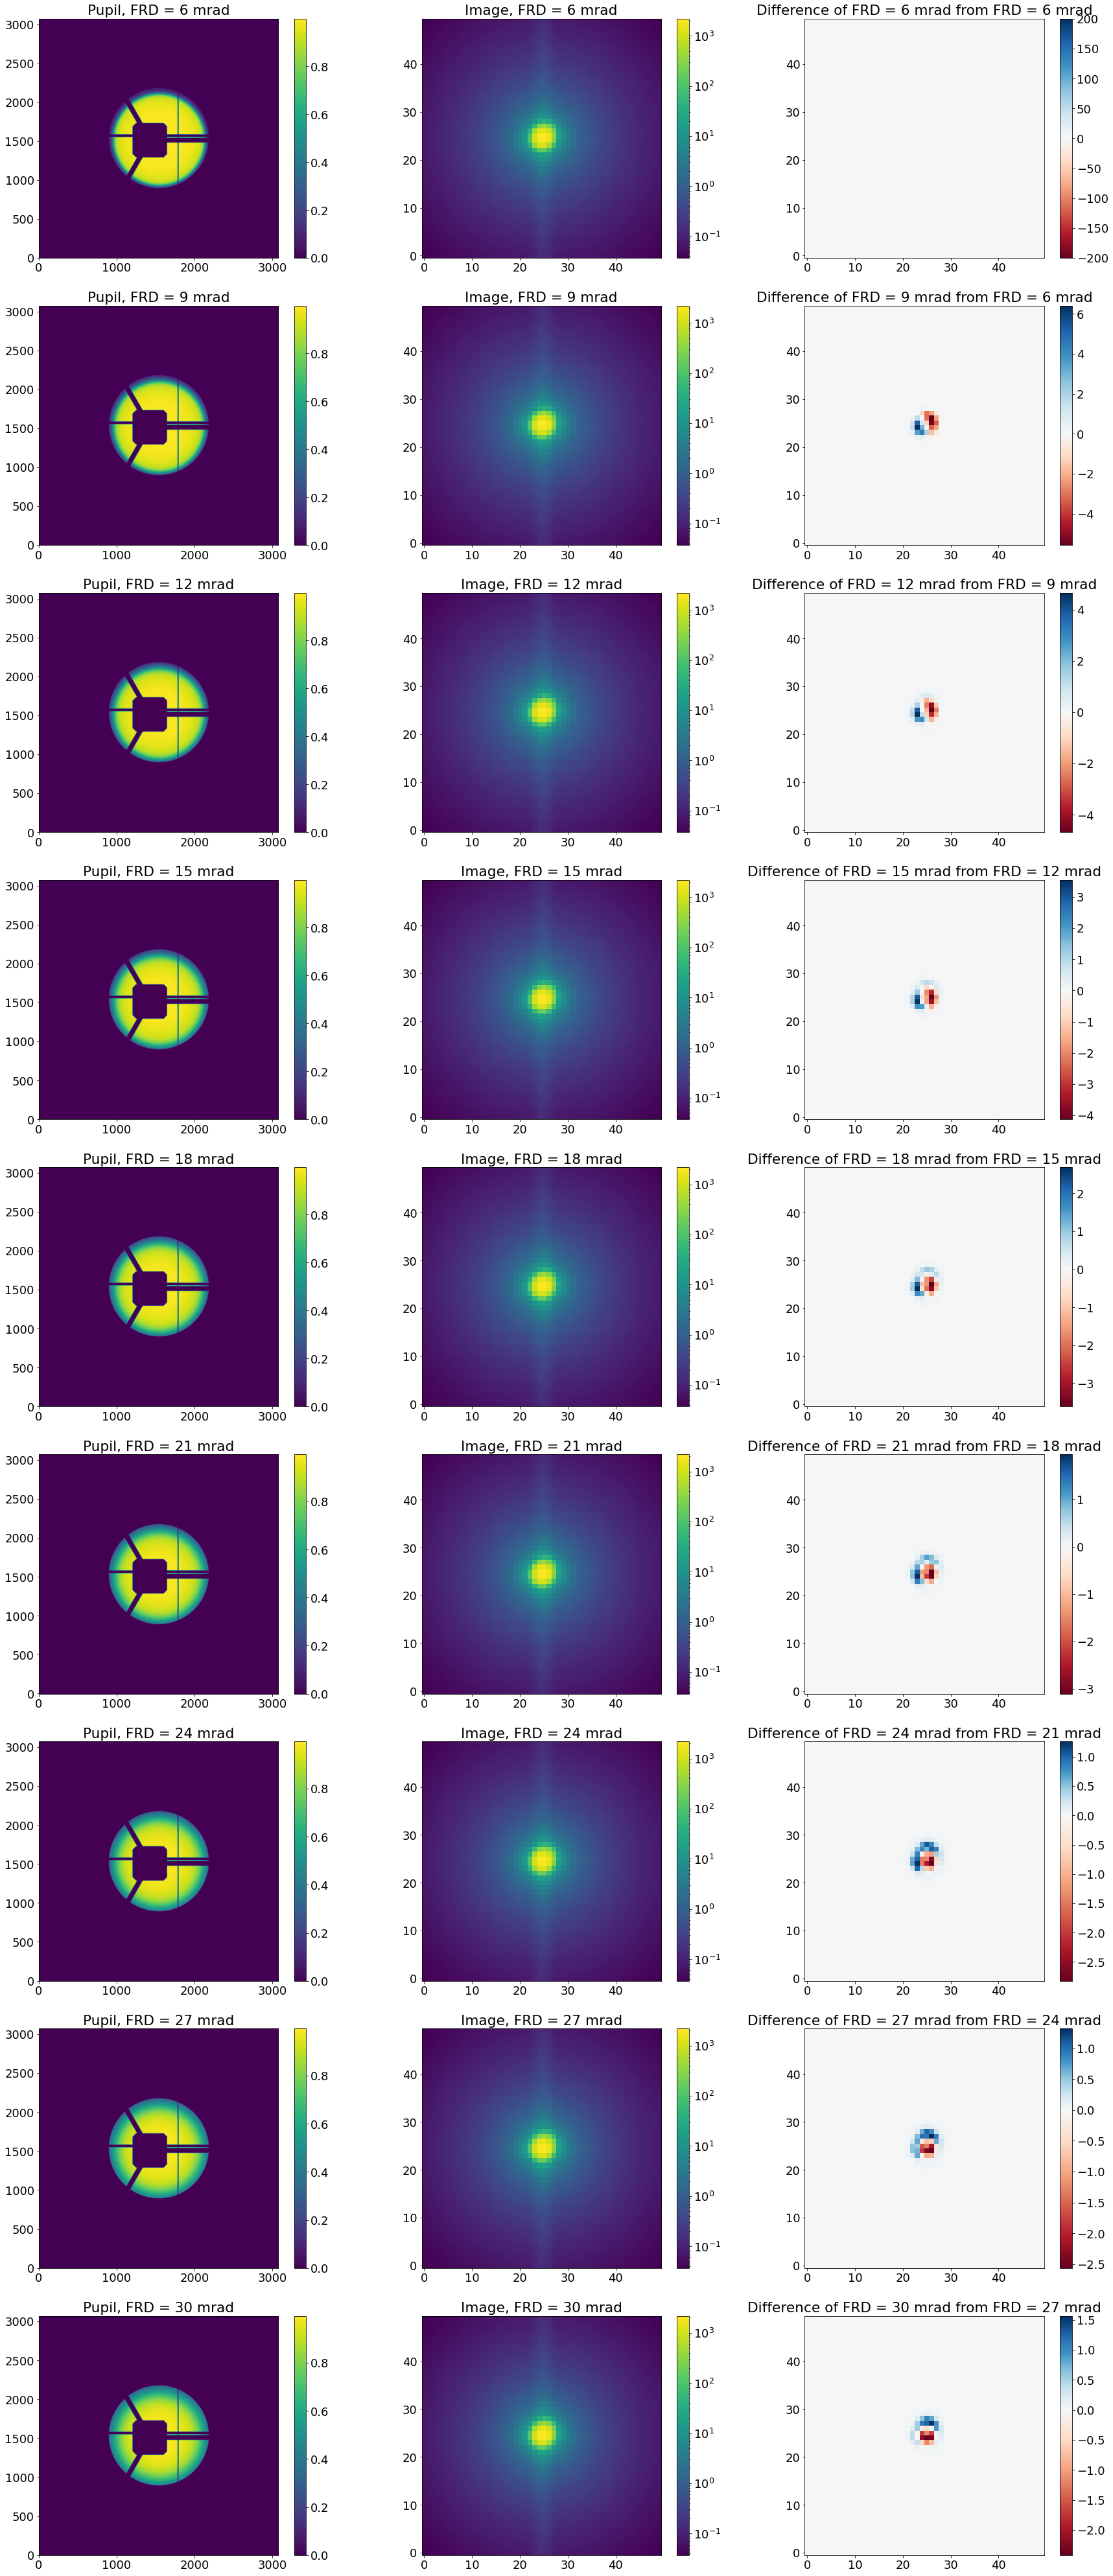

In [134]:
plt.figure(figsize=(30,72))
plt.subplot(9,3,1)
plt.imshow(OutE6,origin='lower',vmax=np.max(OutE6))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 6 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,2)
plt.imshow(InE6,origin='lower',norm=LogNorm(),vmax=np.max(InE6))
cbar=plt.colorbar()
plt.title('Image, FRD = 6 mrad') 

plt.subplot(9,3,3)
d = InE6-InE6
norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 6 mrad from FRD = 6 mrad') 

plt.subplot(9,3,4)
plt.imshow(OutE9,origin='lower',vmax=np.max(OutE9))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 9 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,5)
plt.imshow(InE9,origin='lower',norm=LogNorm(),vmax=np.max(InE9))
cbar=plt.colorbar()
plt.title('Image, FRD = 9 mrad') 

plt.subplot(9,3,6)
d=InE9-InE6
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 9 mrad from FRD = 6 mrad') 

plt.subplot(9,3,7)
plt.imshow(OutE12,origin='lower',vmax=np.max(OutE12))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 12 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,8)
plt.imshow(InE12,origin='lower',norm=LogNorm(),vmax=np.max(InE12))
cbar=plt.colorbar()
plt.title('Image, FRD = 12 mrad') 

plt.subplot(9,3,9)
d=InE12-InE9
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 12 mrad from FRD = 9 mrad') 

plt.subplot(9,3,10)
plt.imshow(OutE15,origin='lower',vmax=np.max(OutE15))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 15 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,11)
plt.imshow(InE15,origin='lower',norm=LogNorm(),vmax=np.max(InE15))
cbar=plt.colorbar()
plt.title('Image, FRD = 15 mrad') 

plt.subplot(9,3,12)
d=InE15-InE12
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 15 mrad from FRD = 12 mrad') 

plt.subplot(9,3,13)
plt.imshow(OutE18,origin='lower',vmax=np.max(OutE18))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 18 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,14)
plt.imshow(InE18,origin='lower',norm=LogNorm(),vmax=np.max(InE18))
cbar=plt.colorbar()
plt.title('Image, FRD = 18 mrad') 

plt.subplot(9,3,15)
d=InE18-InE15
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 18 mrad from FRD = 15 mrad') 

plt.subplot(9,3,16)
plt.imshow(OutE21,origin='lower',vmax=np.max(OutE21))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 21 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,17)
plt.imshow(InE21,origin='lower',norm=LogNorm(),vmax=np.max(InE21))
cbar=plt.colorbar()
plt.title('Image, FRD = 21 mrad') 

plt.subplot(9,3,18)
d=InE21-InE18
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 21 mrad from FRD = 18 mrad') 

plt.subplot(9,3,19)
plt.imshow(OutE24,origin='lower',vmax=np.max(OutE24))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 24 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,20)
plt.imshow(InE24,origin='lower',norm=LogNorm(),vmax=np.max(InE24))
cbar=plt.colorbar()
plt.title('Image, FRD = 24 mrad') 

plt.subplot(9,3,21)
d=InE24-InE21
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 24 mrad from FRD = 21 mrad') 

plt.subplot(9,3,22)
plt.imshow(OutE27,origin='lower',vmax=np.max(OutE27))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 27 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,23)
plt.imshow(InE27,origin='lower',norm=LogNorm(),vmax=np.max(InE27))
cbar=plt.colorbar()
plt.title('Image, FRD = 27 mrad') 

plt.subplot(9,3,24)
d=InE27-InE24
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 27 mrad from FRD = 24 mrad') 

plt.subplot(9,3,25)
plt.imshow(OutE30,origin='lower',vmax=np.max(OutE30))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 30 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,26)
plt.imshow(InE30,origin='lower',norm=LogNorm(),vmax=np.max(InE30))
cbar=plt.colorbar()
plt.title('Image, FRD = 30 mrad') 

plt.subplot(9,3,27)
d=InE30-InE27
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 30 mrad from FRD = 27 mrad') 

plt.savefig('EdgeFRD_2.png',bbox_inches='tight')

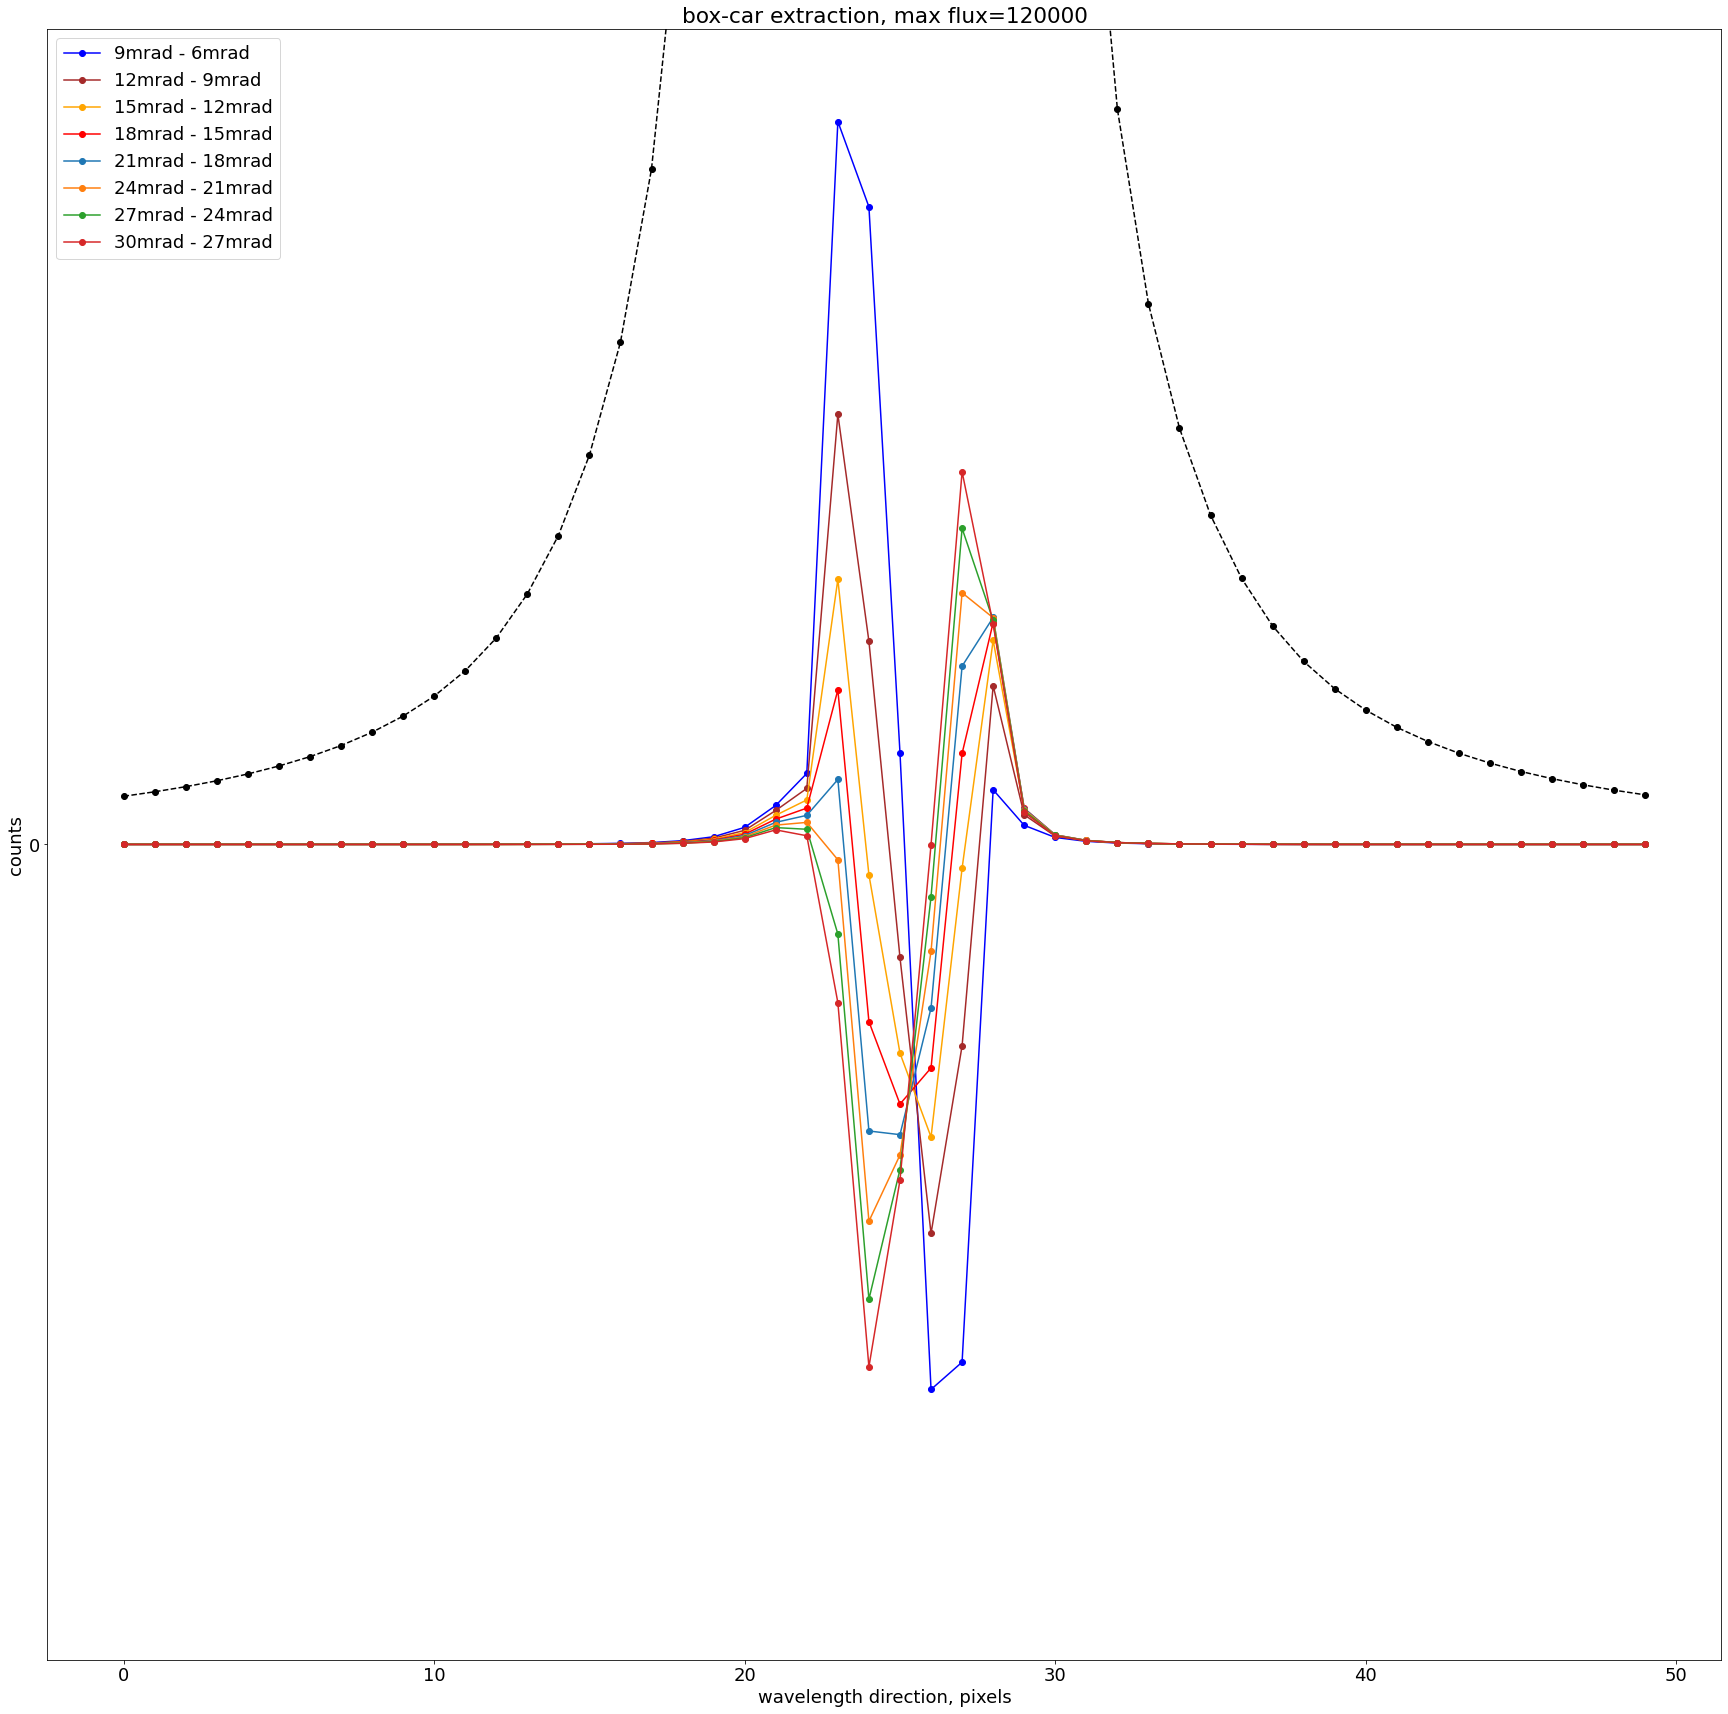

In [33]:
plt.figure(figsize=(30,30))

plt.plot(np.sum(InE9[:,22:27],axis=1)-np.sum(InE6[:,22:27],axis=1),marker='o',color='blue',label='9mrad - 6mrad')
plt.plot(np.sum(InE12[:,22:27],axis=1)-np.sum(InE9[:,22:27],axis=1),marker='o',color='brown',label='12mrad - 9mrad')
plt.plot(np.sum(InE15[:,22:27],axis=1)-np.sum(InE12[:,22:27],axis=1),marker='o',color='orange',label='15mrad - 12mrad')
plt.plot(np.sum(InE18[:,22:27],axis=1)-np.sum(InE15[:,22:27],axis=1),marker='o',color='red',label='18mrad - 15mrad')
plt.plot(np.sum(InE21[:,22:27],axis=1)-np.sum(InE18[:,22:27],axis=1),marker='o',label='21mrad - 18mrad')
plt.plot(np.sum(InE24[:,22:27],axis=1)-np.sum(InE21[:,22:27],axis=1),marker='o',label='24mrad - 21mrad')
plt.plot(np.sum(InE27[:,22:27],axis=1)-np.sum(InE24[:,22:27],axis=1),marker='o',label='27mrad - 24mrad')
plt.plot(np.sum(InE30[:,22:27],axis=1)-np.sum(InE27[:,22:27],axis=1),marker='o',label='30mrad - 27mrad')
plt.plot(np.sum(InE6[:,22:27],axis=1),marker='o',color='black',ls='--')
#plt.plot(np.sum(sci_image[:,8:14],axis=1),marker='o',color='black',ls=':')
plt.ylabel("counts")
plt.xlabel("wavelength direction, pixels")
plt.title("box-car extraction, max flux=120000")
#plt.xticks(np.arange(0, 20, step=1))
plt.yticks(np.arange(-600,700, step=100))
#plt.ylim(-610,610)
plt.ylim(-10,10)
plt.legend(loc=2)
#for i in range(20):
#    plt.text(-0.8+i, -250, str("{:1.0f}".format(list_of_sums[i])), fontsize=20,rotation=60.)
#    
#for i in range(20):
#    plt.text(-0.8+i, -450, str("{:1.0f}".format(np.sum(res_iapetus2[:,8:14],axis=1)[i]-np.sum(res_iapetus1[:,8:14],axis=1)[i])), fontsize=20,rotation=60.,color='brown')




In [47]:
def addnoise(image):
    var_image=image+40 #40 accounts for read noise, but keep in mind that the input images must be scaled properly too...
    artificial_noise_data=np.zeros((var_image.shape[0],var_image.shape[1]))
    for i in range(len(artificial_noise_data)):
        for j in range(len(artificial_noise_data)):
            artificial_noise_data[i][j]=np.random.normal(0,np.sqrt(var_image[i][j]))
    return image+artificial_noise_data
 

60000.0


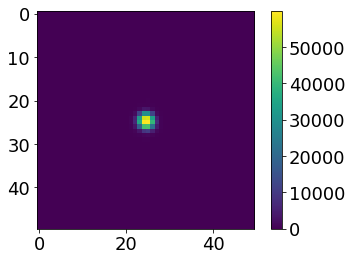

In [121]:
#Testing out PCA

from sklearn.preprocessing import StandardScaler

x = []
x1 = In6 
x1 = 60000/np.max(x1)*x1 #To get a proper SNR
print(np.max(x1))
y = []

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x1))) #Adding some uncertainty to the SNR
    y.append('6mrad')

x2 = In30 #First I'll try two different populations with wildly varying FRD
x2 = 60000/np.max(x2)*x2 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x2)))
    y.append('30mrad')

x3 = In12 #First I'll try two different populations with wildly varying FRD
x3 = 60000/np.max(x3)*x3 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x3)))
    y.append('12mrad')


x4 = In18 #First I'll try two different populations with wildly varying FRD
x4 = 60000/np.max(x4)*x4 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x4)))
    y.append('18mrad')
    
x5 = In24 #First I'll try two different populations with wildly varying FRD
x5 = 60000/np.max(x5)*x5 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x5)))
    y.append('24mrad')
    
#x = StandardScaler().fit_transform(x) #Reduces the weight on the core, which is bad when the noisy low-signal pixels don't contribute to what we want to measure

plt.imshow(np.resize(x[10],(50,50)))
plt.colorbar()
plt.show()

In [183]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Component1', 'Component2'])

finalDf = pd.concat([principalDf, pd.DataFrame(data=y,columns = ['target'])], axis = 1)
#principalDf['target'] = y

first_component = pd.concat([principalDf['Component1'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component2'])],axis = 1)
second_component = pd.concat([pd.DataFrame(data=np.zeros(len(y)),columns = ['Component1']),principalDf['Component2']],axis = 1)
#first_component_bad = pd.concat([(principalDf['Component2']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3'])],axis = 1)
#first_component_bad.rename(columns={"Component2" : "Component1","Component3" : "Component2"})
#second_component = pd.concat([pd.DataFrame(data=np.zeros(len(y)),columns = ['Component1']),principalDf['Component2'],pd.DataFrame(data=y,columns = ['target'])],axis = 1)

print(finalDf)

print(first_component)

print(second_component)

#print(first_component_bad)

print(principalDf)

        Component1    Component2  target
0     91179.192433  12685.032498   6mrad
1    -52625.903025  15306.014946   6mrad
2    -61497.321653  16981.685090   6mrad
3    -30643.797169  14416.766967   6mrad
4    114449.089183  12627.177302   6mrad
..             ...           ...     ...
145   -7918.591840  -6911.358377  24mrad
146    8919.501992  -7911.856703  24mrad
147  -33782.123382  -6281.483076  24mrad
148   39336.391617  -7747.985105  24mrad
149   22938.136214  -7410.366446  24mrad

[150 rows x 3 columns]
        Component1  Component2
0     91179.192433         0.0
1    -52625.903025         0.0
2    -61497.321653         0.0
3    -30643.797169         0.0
4    114449.089183         0.0
..             ...         ...
145   -7918.591840         0.0
146    8919.501992         0.0
147  -33782.123382         0.0
148   39336.391617         0.0
149   22938.136214         0.0

[150 rows x 2 columns]
     Component1    Component2
0           0.0  12685.032498
1           0.0  15306.01494

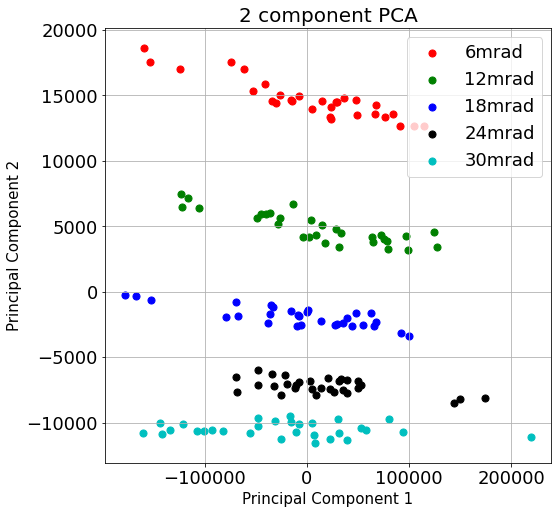

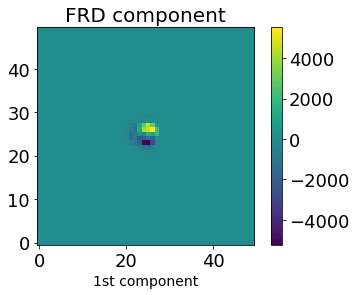

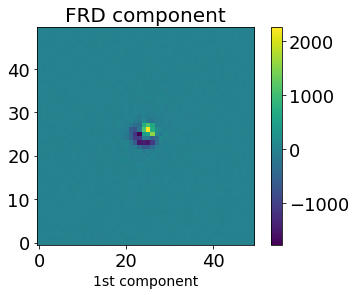

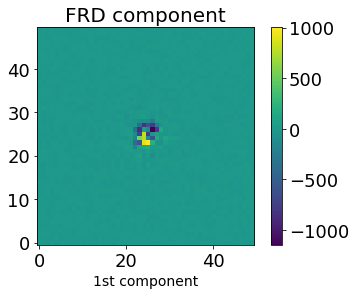

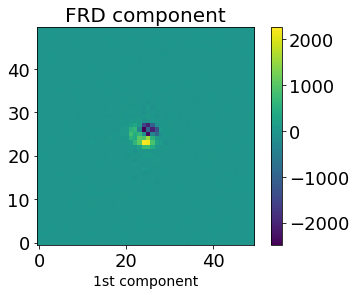

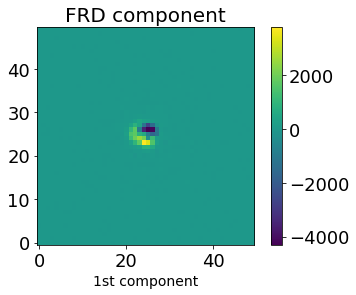

In [187]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['6mrad','12mrad','18mrad','24mrad','30mrad']
colors = ['r', 'g','b','k','c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Component1']
               , finalDf.loc[indicesToKeep, 'Component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()
#plt.savefig('PCA2comp.png')

approximation1 = pca.inverse_transform(first_component)
approximation2 = pca.inverse_transform(second_component)
#approximation_bad = pca.inverse_transform(first_component_bad)

#plt.figure(figsize=(8,4));

## Original Image
#plt.subplot(1, 2, 1);
#plt.imshow(mnist.data[1].reshape(28,28),
#              cmap = plt.cm.gray, interpolation='nearest',
#              clim=(0, 255));
#plt.xlabel('784 components', fontsize = 14)
#plt.title('Original Image', fontsize = 20);
#
## 154 principal components
#plt.subplot(1, 2, 2);

total = np.resize(x[10],(50,50))
FRDcomp = approximation1[10].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
plt.xlabel('1st component', fontsize = 14)
plt.title('FRD component', fontsize = 20);
plt.show()

total = np.resize(x[70],(50,50))
FRDcomp = approximation1[70].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
plt.xlabel('1st component', fontsize = 14)
plt.title('FRD component', fontsize = 20);
plt.show()

total = np.resize(x[100],(50,50))
FRDcomp = approximation1[100].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
plt.xlabel('1st component', fontsize = 14)
plt.title('FRD component', fontsize = 20);
plt.show()


total = np.resize(x[130],(50,50))
FRDcomp = approximation1[130].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
plt.xlabel('1st component', fontsize = 14)
plt.title('FRD component', fontsize = 20);
plt.show()

total = np.resize(x[40],(50,50))
FRDcomp = approximation1[40].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
plt.xlabel('1st component', fontsize = 14)
plt.title('FRD component', fontsize = 20);
plt.show()

In [106]:
pca = PCA()
pca.fit(principalDf)
print(pca.n_components_)
tot = sum(pca.explained_variance_) #It seems like this implicitly assumes all variance is incorporated in the components created (i.e., 2 here)
tot
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])

2
[98.68994072872678, 1.3100592712732224]


In [76]:
#Exciting that the PCA, even the first component alone,
#seems to be able to account for the FRD variation for a known position (fixed),
#SNR (event with a few percent variation introduced), and defocus (fixed at 0)
#I wonder how much of the total data variance is incorporated into these two components? (Note: in reality we'd want
#plenty more components, but that gets increasingly harder to visualize in a plot like the one above)
#Can we improve the FRD extraction from the

600000.0
        Component1    Component2   Component3   Component4  target
0   -125495.423393  17573.994165 -1353.646108  -499.785270   6mrad
1     89703.008708  13686.513920 -2436.216403  1290.673871   6mrad
2    -33372.075406  16278.088589 -1738.935881  -423.606308   6mrad
3    110333.817213  12995.413526  -671.384173 -1598.593553   6mrad
4    -20697.936180  14242.633123  -997.495247  -201.729133   6mrad
..             ...           ...          ...          ...     ...
145  120749.495164  -7887.169646   523.672300   742.346586  24mrad
146  -86515.114508  -6757.078139  -303.102212 -1144.854694  24mrad
147  -88598.998099  -6871.990827  -698.592967  -628.243170  24mrad
148  -40734.758668  -7258.810226   821.543587 -1565.857678  24mrad
149 -103854.350219  -6192.364049   252.272291 -1015.807318  24mrad

[150 rows x 5 columns]


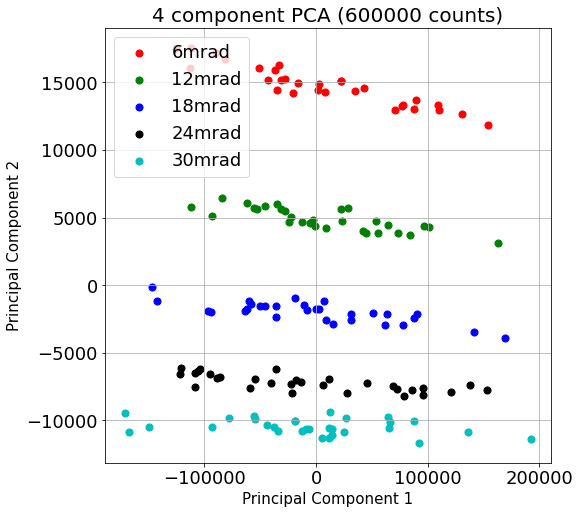

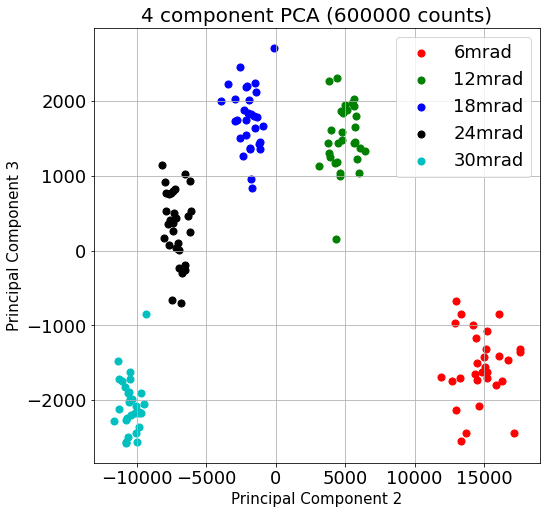

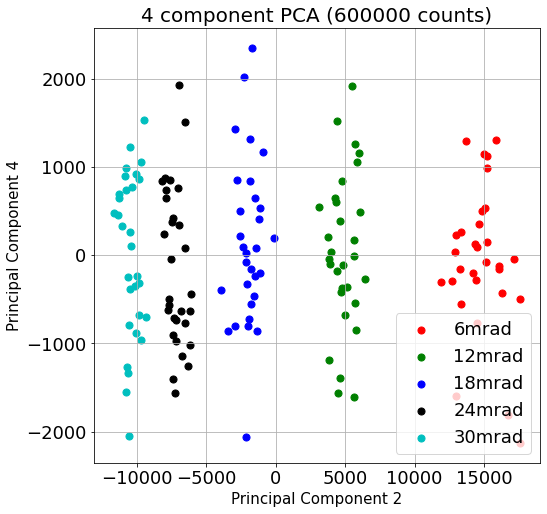

In [343]:
SNR = 600000
x = []
x1 = In6 
x1 = SNR/np.max(x1)*x1 #To get a proper SNR
print(np.max(x1))
y = []

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x1))) #Adding some uncertainty to the SNR
    y.append('6mrad')

x2 = In30 #First I'll try two different populations with wildly varying FRD
x2 = SNR/np.max(x2)*x2 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x2)))
    y.append('30mrad')

x3 = In12 #First I'll try two different populations with wildly varying FRD
x3 = SNR/np.max(x3)*x3 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x3)))
    y.append('12mrad')


x4 = In18 #First I'll try two different populations with wildly varying FRD
x4 = SNR/np.max(x4)*x4 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x4)))
    y.append('18mrad')
    
x5 = In24 #First I'll try two different populations with wildly varying FRD
x5 = SNR/np.max(x5)*x5 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x5)))
    y.append('24mrad')
    
#from sklearn.decomposition import PCA

#x = StandardScaler().fit_transform(x)
"""pca = PCA()
pca.fit(x)
print(pca.n_components_)
tot = sum(pca.explained_variance_)
print(tot)
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])


# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.step(range(1, 1+pca.n_components_), cum_var_exp, where='mid',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='r', linestyle='--', label = '85% Explained Variance')
plt.legend(loc='best')
plt.show()
"""


pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Component1', 'Component2','Component3','Component4'])

principalDf['target'] = y

print(principalDf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('4 component PCA ({} counts)'.format(SNR), fontsize = 20)
targets = ['6mrad','12mrad','18mrad','24mrad','30mrad']
colors = ['r', 'g','b','k','c']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'Component1']
               , principalDf.loc[indicesToKeep, 'Component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('4 component PCA ({} counts)'.format(SNR), fontsize = 20)
targets = ['6mrad','12mrad','18mrad','24mrad','30mrad']
colors = ['r', 'g','b','k','c']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'Component2']
               , principalDf.loc[indicesToKeep, 'Component3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('2nd3rd_Components.png')

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 4', fontsize = 15)
ax.set_title('4 component PCA ({} counts)'.format(SNR), fontsize = 20)
targets = ['6mrad','12mrad','18mrad','24mrad','30mrad']
colors = ['r', 'g','b','k','c']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'Component2']
               , principalDf.loc[indicesToKeep, 'Component4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('2nd4th_Components.png')

First-order Components
Second-order Components






 Third-order Components






 Fourth-order Components


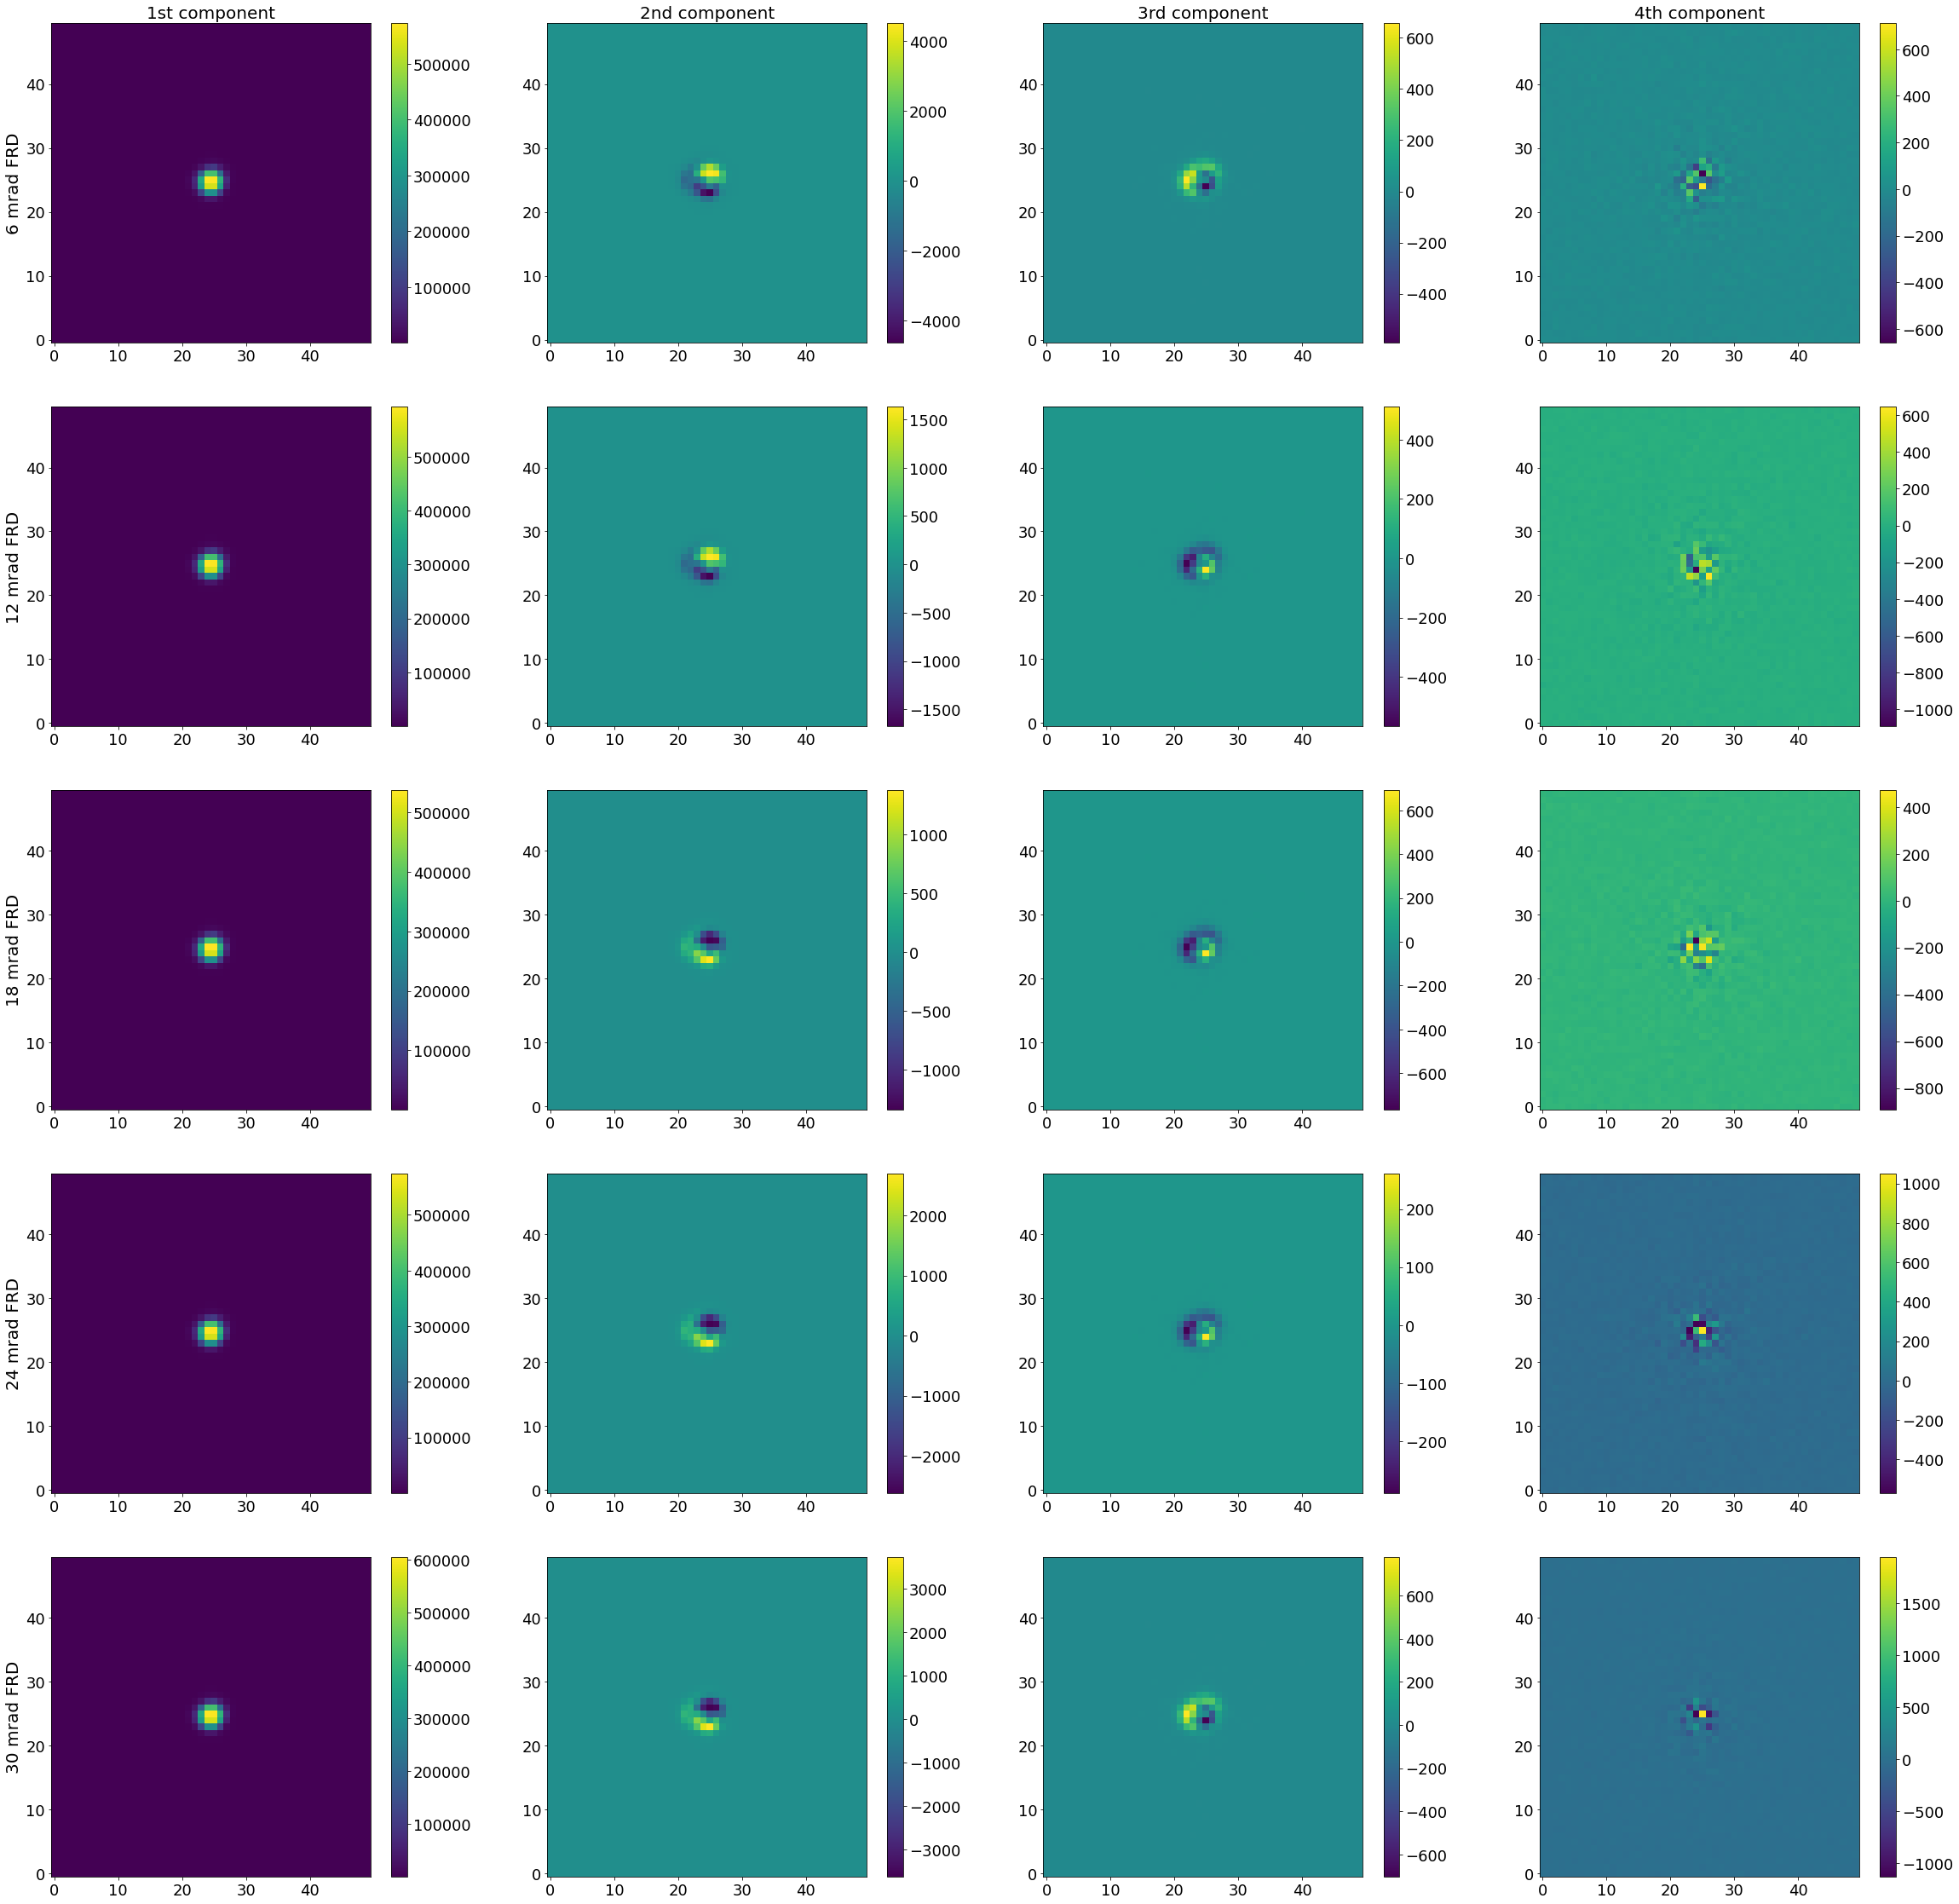

In [344]:
print('First-order Components')

first_component = pd.concat([principalDf['Component1'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component2']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)

approximation1 = pca.inverse_transform(first_component)

second_component = pd.concat([principalDf['Component1'],principalDf['Component2'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)

approximation2 = pca.inverse_transform(second_component)

third_component = pd.concat([principalDf['Component1'],principalDf['Component2'],principalDf['Component3'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)

approximation3 = pca.inverse_transform(third_component)

plt.figure(figsize=(40,40))

plt.subplot(5,4,1)
total = approximation2[10].reshape(50,50)
FRDcomp = approximation1[10].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.ylabel('6 mrad FRD', fontsize = 20)
plt.title('1st component', fontsize = 20);
#plt.show()

plt.subplot(5,4,5)
total = approximation2[70].reshape(50,50)
FRDcomp = approximation1[70].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
plt.ylabel('12 mrad FRD', fontsize = 20)
#plt.xlabel('1st component', fontsize = 14)
#plt.title('2nd component', fontsize = 20);
#plt.show()

plt.subplot(5,4,9)
total = approximation2[100].reshape(50,50)
FRDcomp = approximation1[100].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
plt.ylabel('18 mrad FRD', fontsize = 20)
#plt.show()

plt.subplot(5,4,13)
total = approximation2[130].reshape(50,50)
FRDcomp = approximation1[130].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
plt.ylabel('24 mrad FRD', fontsize = 20)
#plt.show()

plt.subplot(5,4,17)
total = approximation2[40].reshape(50,50)
FRDcomp = approximation1[40].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
plt.ylabel('30 mrad FRD', fontsize = 20)
#plt.show()

print('Second-order Components')

#first_component = pd.concat([principalDf['Component1'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component2']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)

#approximation1 = pca.inverse_transform(first_component)

plt.subplot(5,4,2)
total = approximation2[10].reshape(50,50)
FRDcomp = approximation1[10].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.title('2nd component', fontsize = 20);
#plt.show()

plt.subplot(5,4,6)
total = approximation2[70].reshape(50,50)
FRDcomp = approximation1[70].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,10)
total = approximation2[100].reshape(50,50)
FRDcomp = approximation1[100].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,14)
total = approximation2[130].reshape(50,50)
FRDcomp = approximation1[130].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,18)
total = approximation2[40].reshape(50,50)
FRDcomp = approximation1[40].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
#plt.show()

print('\n\n\n\n\n\n Third-order Components')

#second_component = pd.concat([principalDf['Component1'],principalDf['Component2'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)

#approximation2 = pca.inverse_transform(second_component)

plt.subplot(5,4,3)
total = approximation3[10].reshape(50,50)
FRDcomp = approximation2[10].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.title('3rd component', fontsize = 20);
#plt.show()

plt.subplot(5,4,7)
total = approximation3[70].reshape(50,50)
FRDcomp = approximation2[70].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,11)
total = approximation3[100].reshape(50,50)
FRDcomp = approximation2[100].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,15)
total = approximation3[130].reshape(50,50)
FRDcomp = approximation2[130].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,19)
total = approximation3[40].reshape(50,50)
FRDcomp = approximation2[40].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
#plt.show()

print('\n\n\n\n\n\n Fourth-order Components')

third_component = pd.concat([principalDf['Component1'],principalDf['Component2'],principalDf['Component3'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)

approximation3 = pca.inverse_transform(third_component)

plt.subplot(5,4,4)
total = np.resize(x[10],(50,50))
FRDcomp = approximation3[10].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.title('4th component', fontsize = 20);
#plt.show()

plt.subplot(5,4,8)
total = np.resize(x[70],(50,50))
FRDcomp = approximation3[70].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,12)
total = np.resize(x[100],(50,50))
FRDcomp = approximation3[100].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,16)
total = np.resize(x[130],(50,50))
FRDcomp = approximation3[130].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(5,4,20)
total = np.resize(x[40],(50,50))
FRDcomp = approximation3[40].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);

plt.savefig('4componentPCA_2D.png')
plt.show()



In [ ]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(np.resize(x[10],(50,50)),
              interpolation='nearest');
#plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[1].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

In [ ]:
#At low SNR (E.g. 6000 counts), this goes to naught - pixel variation of ~4 isn't detectable over noise and SNR variation.

In [156]:
2+2

4

In [279]:
#Section 1: Subpixel centroid alignment routine

from scipy.ndimage.measurements import center_of_mass #I did this above, but I want to make this self-contained

def centroid_residual(Image1,Image2):
    if np.shape(Image1) != np.shape(Image2):
        print('Error: Argument 0 has different shape than Argument 1')
        return np.nan
    #print(np.shape(In6))
    x,y = np.mgrid[:(np.shape(Image1)[0]),:(np.shape(Image1)[1])]
    cx1,cy1 = center_of_mass(Image1)
    cx2,cy2 = center_of_mass(Image2)

    dx = np.array([cx1 - x, cx2-x])
    dy = np.array([cy1 - y, cy2-y])
    Images = np.array([Image1, -1*Image2])
    
    bins = np.linspace(-np.round(np.shape(Image1)[0]/2.),np.round(np.shape(Image1)[0]/2.),np.shape(Image1)[0])
    h, xe, ye = np.histogram2d(dx.ravel(),dy.ravel(),bins=bins,weights=Images.ravel())
    
    fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
    pc = ax.pcolormesh(xe, ye, h)
    #ax.axhline(0, ls='--', lw=2, c='w')
    #ax.axvline(0, ls='--', lw=2, c='w')
    fig.colorbar(pc)
    ax.margins(x=0, y=0)
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    plt.show()
    print(np.sum(np.square(h)))
    
    plt.imshow(Image1-Image2,origin='lower')
    plt.colorbar()
    plt.show()
    
    print(np.sum(np.square(Image1-Image2)))

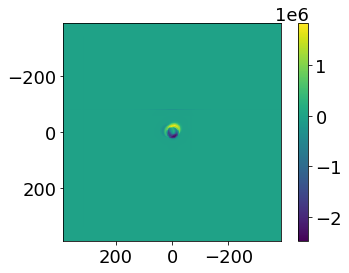

2987635126406162.0


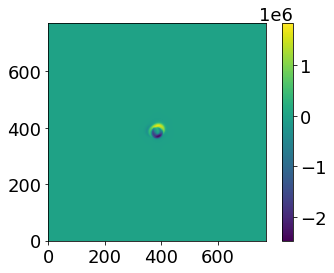

2935110318923217.0




 Now compared to a spectrograph image subtracted by another spectrograph image that is shifted.


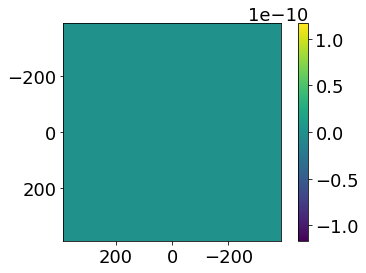

5.33313326210142e-19


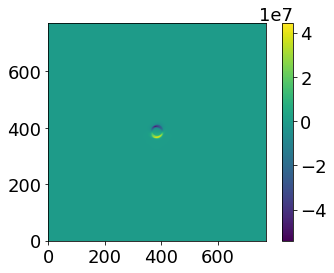

6.609176467674719e+17


In [284]:
centroid_residual(In6_sim,np.max(In6_sim)/np.max(In9_sim)*In9_sim)#np.sum(In6_sim)/np.sum(In9_sim)*
print('\n\n\n\n Now compared to a spectrograph image subtracted by another spectrograph image that is shifted.')
centroid_residual(In6_sim,np.roll(In6_sim,1,axis=0))

In [306]:
print(center_of_mass(In6_sim))
print(center_of_mass(In9_sim))

(386.8595648231938, 384.8366038490235)
(386.79628061393043, 384.8204479856794)


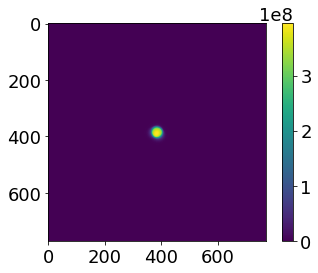

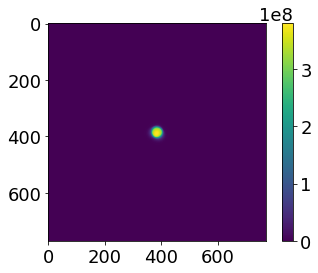

In [283]:
plt.imshow(In6_sim)
plt.colorbar()
plt.show()
plt.imshow(In9_sim)
plt.colorbar()
plt.show()

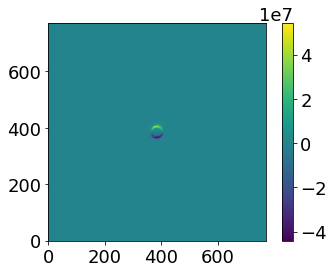

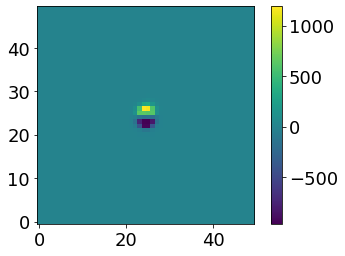

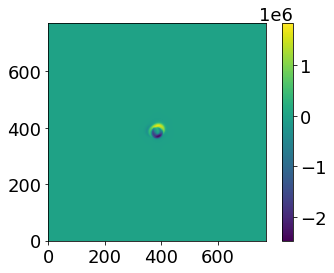

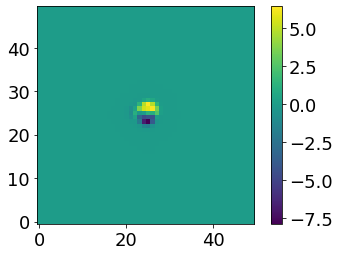

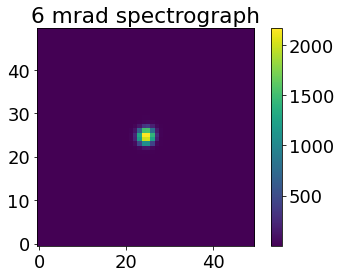

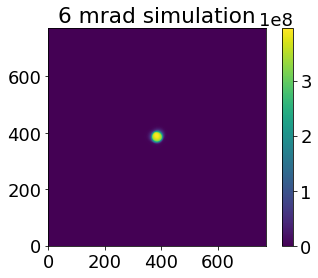

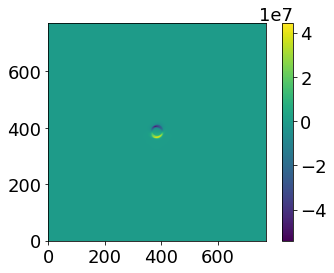

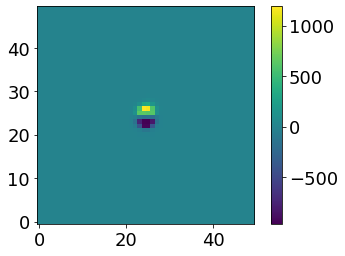

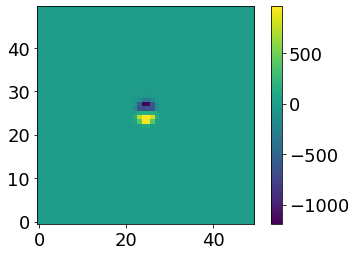

In [331]:
plt.imshow(In6_sim-np.roll(In6_sim,-1,axis=0),origin='lower')
plt.colorbar()
#plt.title('6 mrad simulation minus one pixel \n vertical offset 6 mrad simulation\n')
plt.savefig('One_pixel_offset_simulation.png')
plt.show()

plt.imshow(In6-np.roll(In6,-1,axis=0),origin='lower')
plt.colorbar()
#title = plt.title('6 mrad simulation minus one pixel \n vertical offset 6 mrad spectrograph\n')
plt.savefig('One_pixel_offset_spectrograph.png',Bbox='tight',bbox_extra_artists=title)
plt.show()

plt.imshow(In6_sim-np.max(In6_sim)/np.max(In9_sim)*In9_sim,origin='lower')
plt.colorbar()
#plt.title('6 mrad simulation minus 9 mrad simulation')
plt.savefig('6mrad_9mrad_simulation.png')
plt.show()

plt.imshow(In6-np.max(In6)/np.max(In9)*In9,origin='lower')
plt.colorbar()
#plt.title('6 mrad simulation minus 9 mrad spectrograph')
plt.savefig('6mrad_9mrad_spectrograph.png')
plt.show()

plt.imshow(In6,origin='lower')
plt.colorbar()
plt.title('6 mrad spectrograph')
plt.savefig('6mrad_spectrograph.png')
plt.show()

plt.imshow(In6_sim,origin='lower')
plt.colorbar()
plt.title('6 mrad simulation')
plt.savefig('6mrad_simulation.png')
plt.show()

plt.imshow(In6_sim-np.roll(In6_sim,1,axis=0),origin='lower')
plt.colorbar()
plt.show()

plt.imshow(In6-np.roll(In6,-1,axis=0),origin='lower')
plt.colorbar()
plt.show()

plt.imshow(In6-np.roll(In6,1,axis=0),origin='lower')
plt.colorbar()
plt.show()

In [291]:
def EntryCreate_zero(FRD,position):
    numbervalues = get_PSF_parameters(0.0603,'0',position,1) #The FRD component doesn't affect which data entry is read.
    effective_illum_radius = numbervalues[31]
    #effective_illum_radius = 0.92 #Simulate this effect for now...
    sigma_FRD_code = FRD/(np.sqrt(2))*effective_illum_radius*(2*2.8)
    PSF_params = get_PSF_parameters(sigma_FRD_code,'0',position,1)
    PSF_params[0:19] = 0 #This sets all Zernikes to 0
    res=model2(PSF_params,return_Image=True)
    Out_of_focus = np.load(TESTING_PUPIL_IMAGES_FOLDER+'r_resize.npy') #Technically this is the pupil, not the out-of-focus image
    In_focus = np.load(TESTING_FINAL_IMAGES_FOLDER+"optPsf_cut_fiber_convolved_downsampled.npy") 
    return Out_of_focus,In_focus

In [292]:
Out6_zero,In6_zero = EntryCreate_zero(0.006,64)
Out9_zero,In9_zero = EntryCreate_zero(0.009,64)
Out12_zero,In12_zero = EntryCreate_zero(0.012,64)
Out15_zero,In15_zero = EntryCreate_zero(0.015,64)
Out18_zero,In18_zero = EntryCreate_zero(0.018,64)
Out21_zero,In21_zero = EntryCreate_zero(0.021,64)
Out24_zero,In24_zero = EntryCreate_zero(0.024,64)
Out27_zero,In27_zero = EntryCreate_zero(0.027,64)
Out30_zero,In30_zero = EntryCreate_zero(0.030,64)

<ipython-input-293-a85c9d7af50b>:15: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
<ipython-input-293-a85c9d7af50b>:33: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-293-a85c9d7af50b>:51: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-293-a85c9d7af50b>:69: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNo

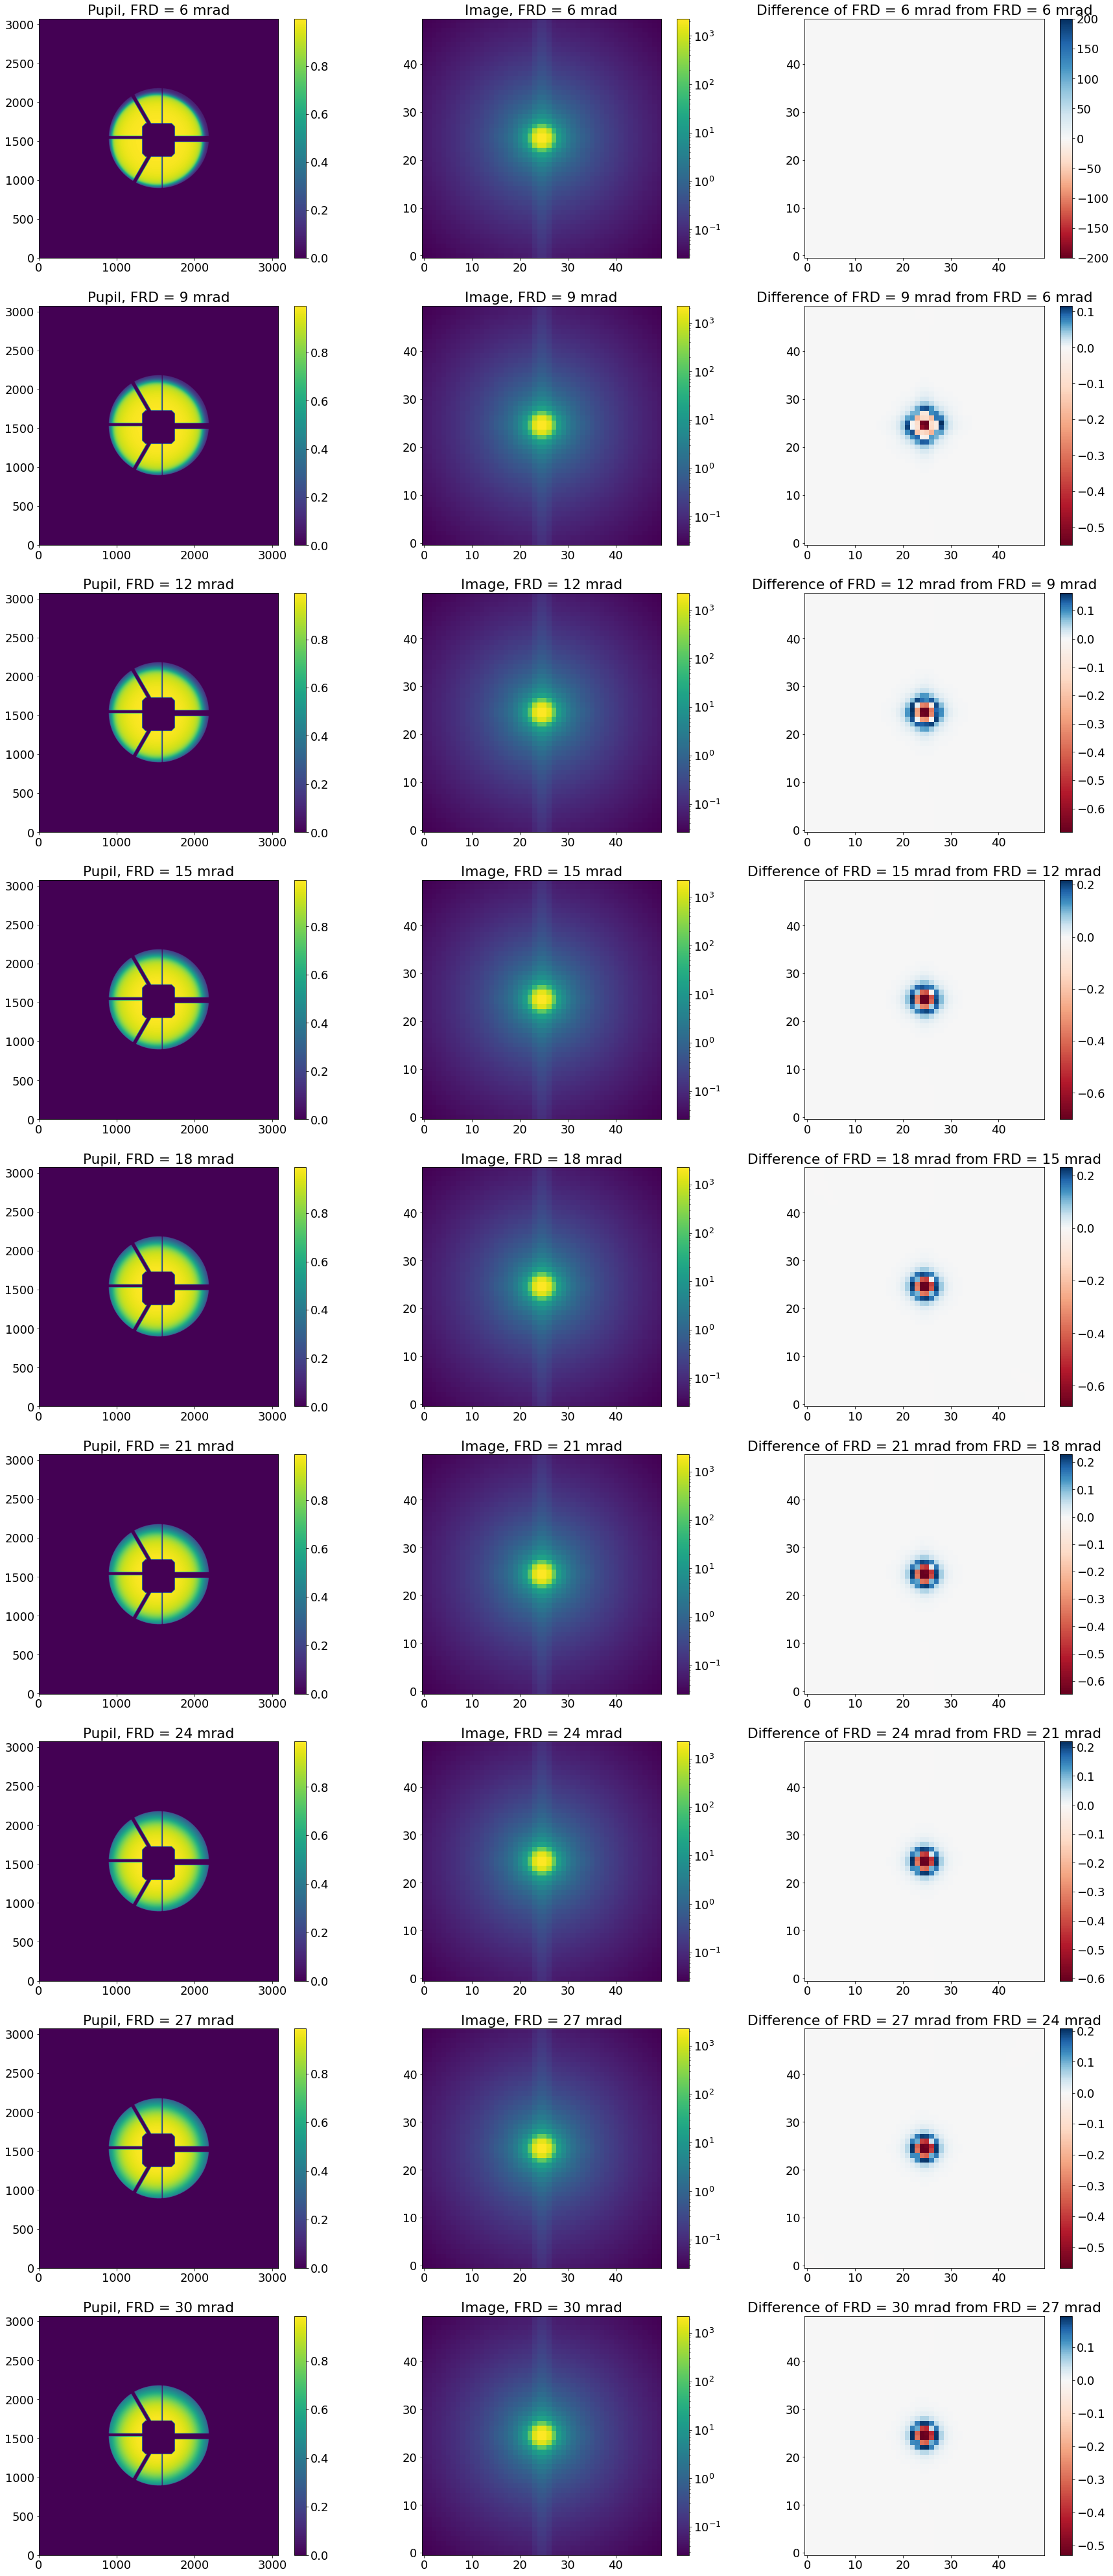

In [293]:
plt.figure(figsize=(30,72))
plt.subplot(9,3,1)
plt.imshow(Out6,origin='lower',vmax=np.max(Out6))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 6 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,2)
plt.imshow(In6_zero,origin='lower',norm=LogNorm(),vmax=np.max(In6_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 6 mrad') 

plt.subplot(9,3,3)
d = In6_zero-In6_zero
norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 6 mrad from FRD = 6 mrad') 

plt.subplot(9,3,4)
plt.imshow(Out9,origin='lower',vmax=np.max(Out9))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 9 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,5)
plt.imshow(In9_zero,origin='lower',norm=LogNorm(),vmax=np.max(In9_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 9 mrad') 

plt.subplot(9,3,6)
d=In9_zero-In6_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 9 mrad from FRD = 6 mrad') 

plt.subplot(9,3,7)
plt.imshow(Out12,origin='lower',vmax=np.max(Out12))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 12 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,8)
plt.imshow(In12_zero,origin='lower',norm=LogNorm(),vmax=np.max(In12_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 12 mrad') 

plt.subplot(9,3,9)
d=In12_zero-In9_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 12 mrad from FRD = 9 mrad') 

plt.subplot(9,3,10)
plt.imshow(Out15,origin='lower',vmax=np.max(Out15))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 15 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,11)
plt.imshow(In15_zero,origin='lower',norm=LogNorm(),vmax=np.max(In15_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 15 mrad') 

plt.subplot(9,3,12)
d=In15_zero-In12_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 15 mrad from FRD = 12 mrad') 

plt.subplot(9,3,13)
plt.imshow(Out18,origin='lower',vmax=np.max(Out18))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 18 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,14)
plt.imshow(In18_zero,origin='lower',norm=LogNorm(),vmax=np.max(In18_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 18 mrad') 

plt.subplot(9,3,15)
d=In18_zero-In15_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 18 mrad from FRD = 15 mrad') 

plt.subplot(9,3,16)
plt.imshow(Out21,origin='lower',vmax=np.max(Out21))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 21 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,17)
plt.imshow(In21_zero,origin='lower',norm=LogNorm(),vmax=np.max(In21_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 21 mrad') 

plt.subplot(9,3,18)
d=In21_zero-In18_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 21 mrad from FRD = 18 mrad') 

plt.subplot(9,3,19)
plt.imshow(Out24,origin='lower',vmax=np.max(Out24))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 24 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,20)
plt.imshow(In24_zero,origin='lower',norm=LogNorm(),vmax=np.max(In24_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 24 mrad') 

plt.subplot(9,3,21)
d=In24_zero-In21_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 24 mrad from FRD = 21 mrad') 

plt.subplot(9,3,22)
plt.imshow(Out27,origin='lower',vmax=np.max(Out27))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 27 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,23)
plt.imshow(In27_zero,origin='lower',norm=LogNorm(),vmax=np.max(In27_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 27 mrad') 

plt.subplot(9,3,24)
d=In27_zero-In24_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 27 mrad from FRD = 24 mrad') 

plt.subplot(9,3,25)
plt.imshow(Out30,origin='lower',vmax=np.max(Out30))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 30 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,26)
plt.imshow(In30_zero,origin='lower',norm=LogNorm(),vmax=np.max(In30_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 30 mrad') 

plt.subplot(9,3,27)
d=In30_zero-In27_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 30 mrad from FRD = 27 mrad') 

<ipython-input-318-5ae553afff4e>:25: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
<ipython-input-318-5ae553afff4e>:43: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-318-5ae553afff4e>:61: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-318-5ae553afff4e>:79: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNo

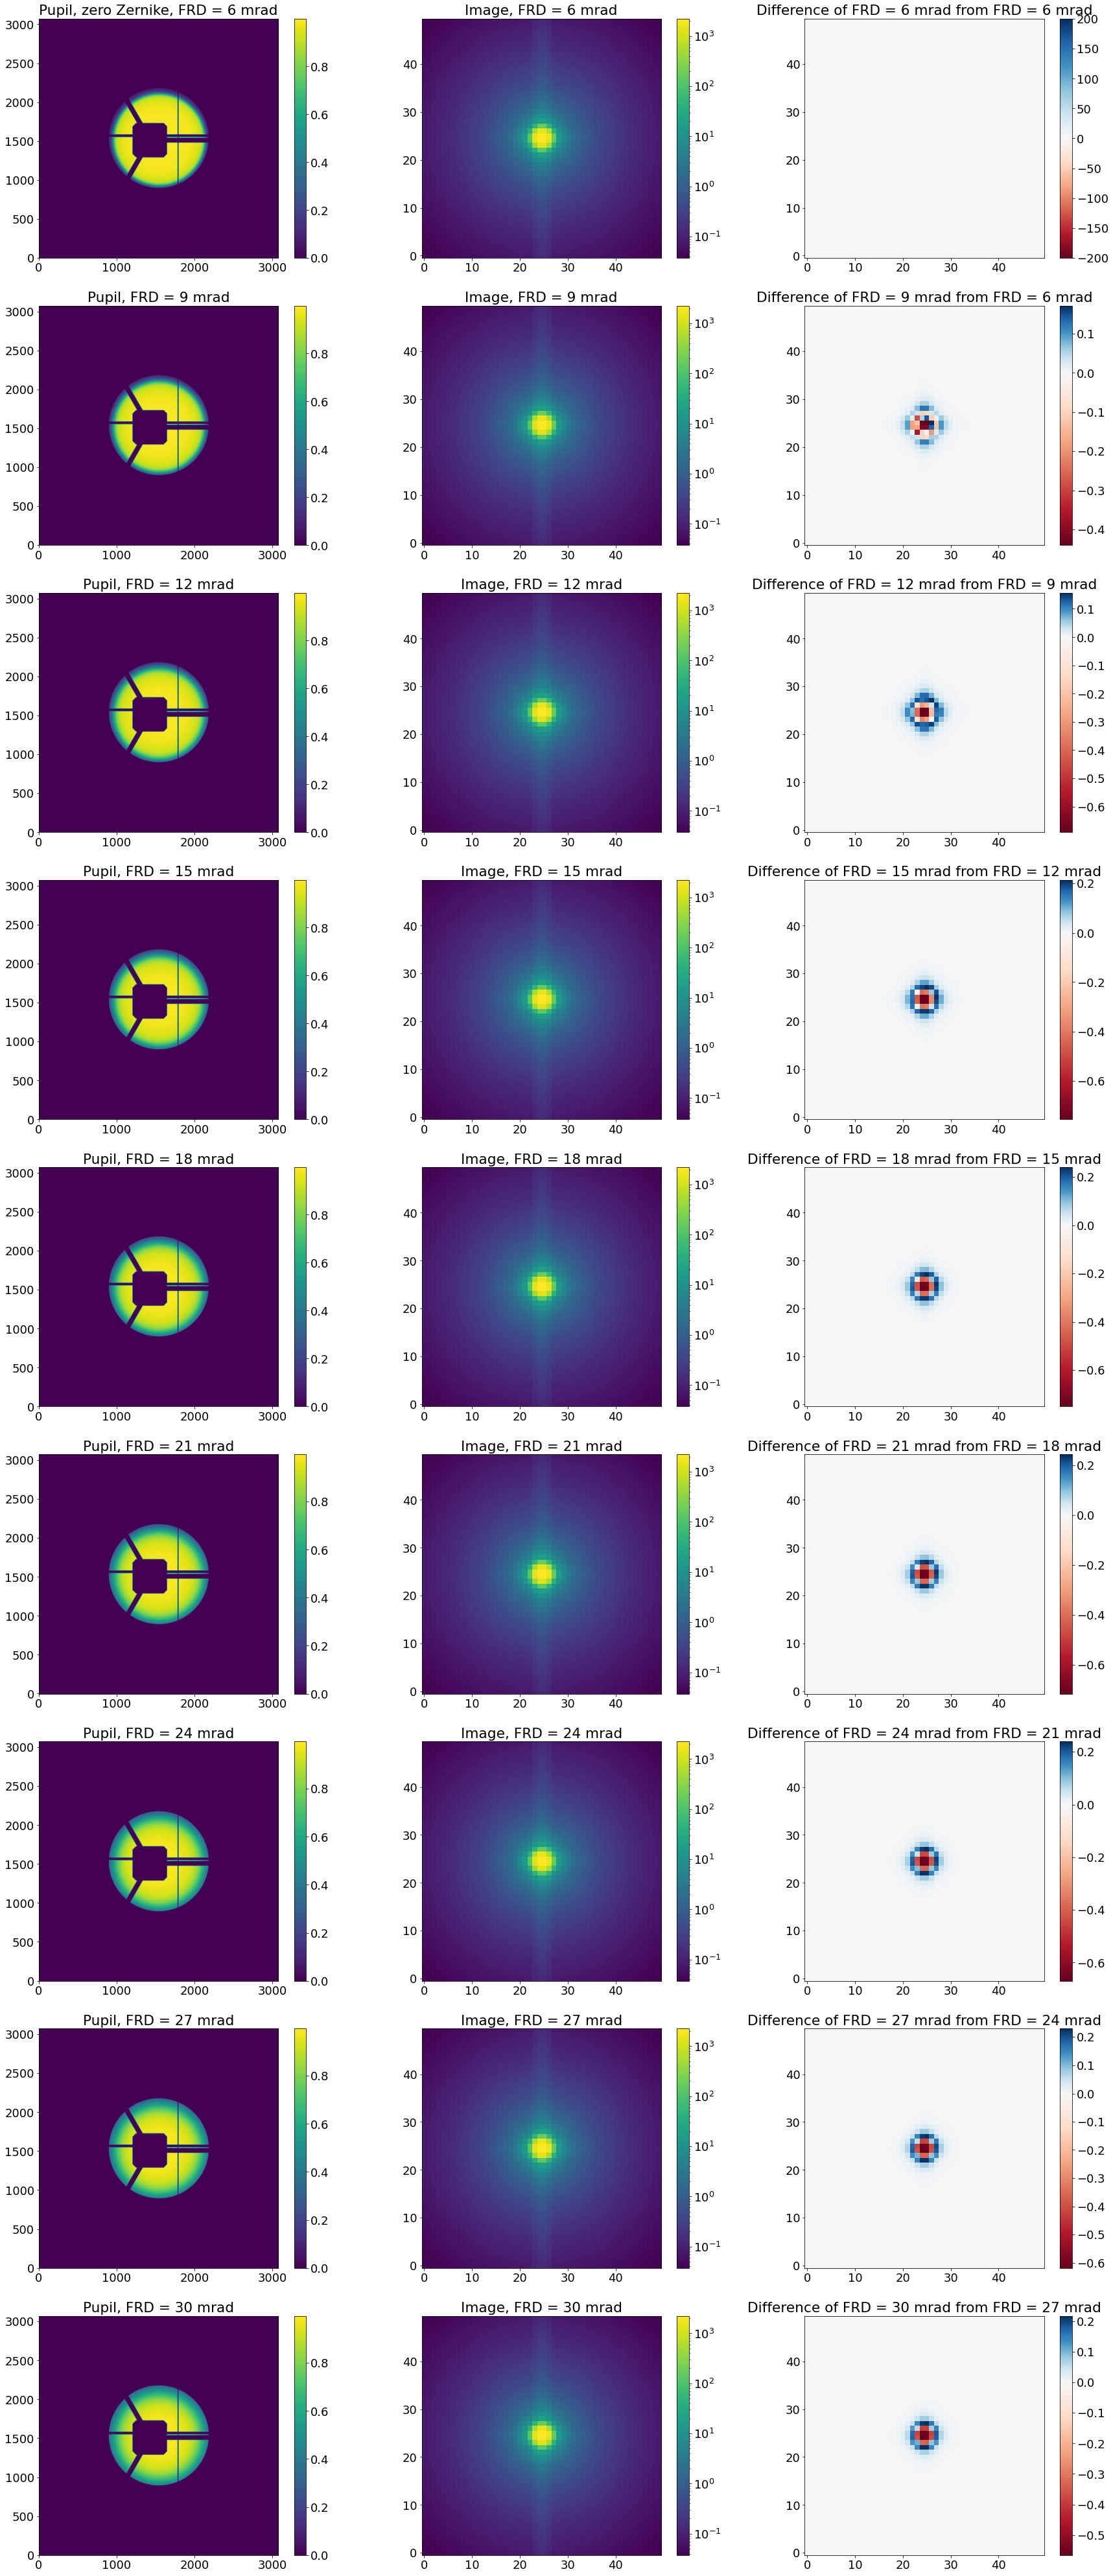

In [318]:
#OutE6_zero,InE6_zero = EntryCreate_zero(0.006,1)
#OutE9_zero,InE9_zero = EntryCreate_zero(0.009,1)
#OutE12_zero,InE12_zero = EntryCreate_zero(0.012,1)
#OutE15_zero,InE15_zero = EntryCreate_zero(0.015,1)
#OutE18_zero,InE18_zero = EntryCreate_zero(0.018,1)
#OutE21_zero,InE21_zero = EntryCreate_zero(0.021,1)
#OutE24_zero,InE24_zero = EntryCreate_zero(0.024,1)
#OutE27_zero,InE27_zero = EntryCreate_zero(0.027,1)
#OutE30_zero,InE30_zero = EntryCreate_zero(0.030,1)

plt.figure(figsize=(30,72))
plt.subplot(9,3,1)
plt.imshow(OutE6,origin='lower',vmax=np.max(OutE6))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, zero Zernike, FRD = 6 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,2)
plt.imshow(InE6_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE6_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 6 mrad') 

plt.subplot(9,3,3)
d = InE6_zero-InE6_zero
norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 6 mrad from FRD = 6 mrad') 

plt.subplot(9,3,4)
plt.imshow(OutE9,origin='lower',vmax=np.max(OutE9))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 9 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,5)
plt.imshow(InE9_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE9_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 9 mrad') 

plt.subplot(9,3,6)
d=InE9_zero-InE6_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 9 mrad from FRD = 6 mrad') 

plt.subplot(9,3,7)
plt.imshow(OutE12,origin='lower',vmax=np.max(OutE12))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 12 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,8)
plt.imshow(InE12_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE12_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 12 mrad') 

plt.subplot(9,3,9)
d=InE12_zero-InE9_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 12 mrad from FRD = 9 mrad') 

plt.subplot(9,3,10)
plt.imshow(OutE15,origin='lower',vmax=np.max(OutE15))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 15 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,11)
plt.imshow(InE15_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE15_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 15 mrad') 

plt.subplot(9,3,12)
d=InE15_zero-InE12_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 15 mrad from FRD = 12 mrad') 

plt.subplot(9,3,13)
plt.imshow(OutE18,origin='lower',vmax=np.max(OutE18))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 18 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,14)
plt.imshow(InE18_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE18_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 18 mrad') 

plt.subplot(9,3,15)
d=InE18_zero-InE15_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 18 mrad from FRD = 15 mrad') 

plt.subplot(9,3,16)
plt.imshow(OutE21,origin='lower',vmax=np.max(OutE21))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 21 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,17)
plt.imshow(InE21_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE21_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 21 mrad') 

plt.subplot(9,3,18)
d=InE21_zero-InE18_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 21 mrad from FRD = 18 mrad') 

plt.subplot(9,3,19)
plt.imshow(OutE24,origin='lower',vmax=np.max(OutE24))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 24 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,20)
plt.imshow(InE24_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE24_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 24 mrad') 

plt.subplot(9,3,21)
d=InE24_zero-InE21_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 24 mrad from FRD = 21 mrad') 

plt.subplot(9,3,22)
plt.imshow(OutE27,origin='lower',vmax=np.max(OutE27))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 27 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,23)
plt.imshow(InE27_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE27_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 27 mrad') 

plt.subplot(9,3,24)
d=InE27_zero-InE24_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 27 mrad from FRD = 24 mrad') 

plt.subplot(9,3,25)
plt.imshow(OutE30,origin='lower',vmax=np.max(OutE30))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 30 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,26)
plt.imshow(InE30_zero,origin='lower',norm=LogNorm(),vmax=np.max(InE30_zero))
cbar=plt.colorbar()
plt.title('Image, FRD = 30 mrad') 

plt.subplot(9,3,27)
d=InE30_zero-InE27_zero
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 30 mrad from FRD = 27 mrad') 

plt.savefig('Zero_Wavefront.png',Bbox='tight')

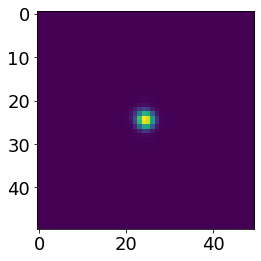

In [297]:
Outtest,Intest = EntryCreate(0.006,119)

plt.imshow(Intest)

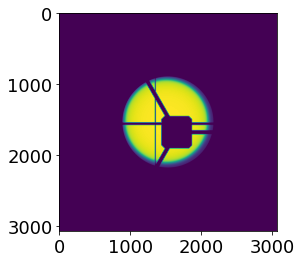

In [298]:
plt.imshow(Outtest)

In [299]:
OutC6,InC6 = EntryCreate(0.006,119)
OutC9,InC9 = EntryCreate(0.009,119)
OutC12,InC12 = EntryCreate(0.012,119)
OutC15,InC15 = EntryCreate(0.015,119)
OutC18,InC18 = EntryCreate(0.018,119)
OutC21,InC21 = EntryCreate(0.021,119)
OutC24,InC24 = EntryCreate(0.024,119)
OutC27,InC27 = EntryCreate(0.027,119)
OutC30,InC30 = EntryCreate(0.030,119)

<ipython-input-301-4aa6de4c15b6>:15: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
<ipython-input-301-4aa6de4c15b6>:33: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-301-4aa6de4c15b6>:51: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
<ipython-input-301-4aa6de4c15b6>:69: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNo

Text(0.5, 1.0, 'Difference of FRD = 30 mrad from FRD = 27 mrad')

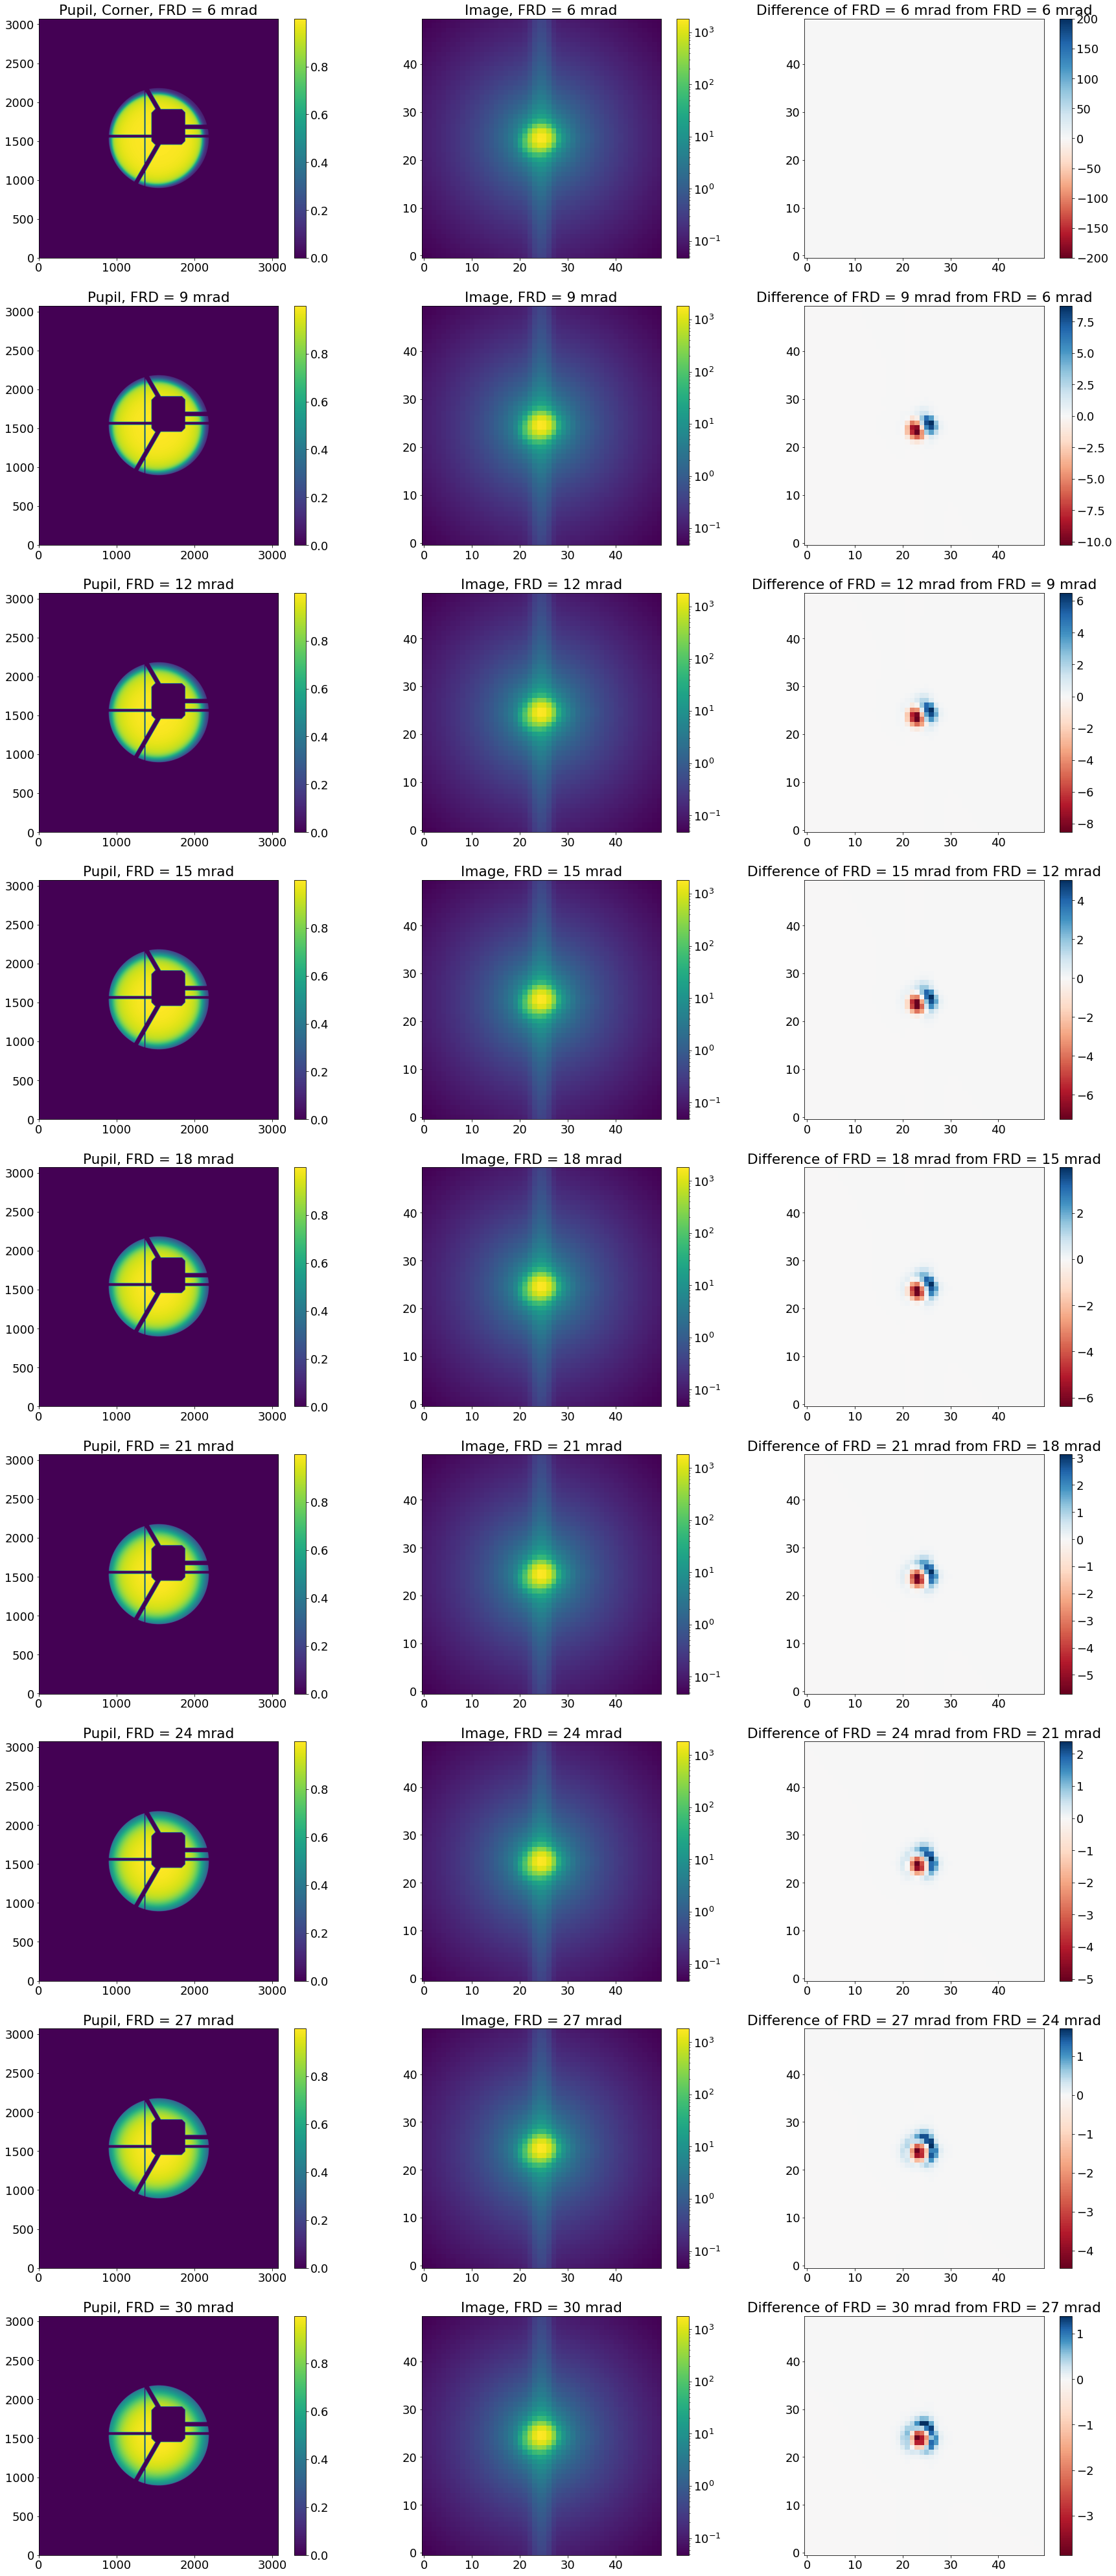

In [301]:
plt.figure(figsize=(30,72))
plt.subplot(9,3,1)
plt.imshow(OutC6,origin='lower',vmax=np.max(OutC6))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, Corner, FRD = 6 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,2)
plt.imshow(InC6,origin='lower',norm=LogNorm(),vmax=np.max(InC6))
cbar=plt.colorbar()
plt.title('Image, FRD = 6 mrad') 

plt.subplot(9,3,3)
d = InC6-InC6
norm = mcolors.DivergingNorm(vmin=d.min()-200, vmax = d.max()+200, vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 6 mrad from FRD = 6 mrad') 

plt.subplot(9,3,4)
plt.imshow(OutC9,origin='lower',vmax=np.max(OutC9))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 9 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,5)
plt.imshow(InC9,origin='lower',norm=LogNorm(),vmax=np.max(InC9))
cbar=plt.colorbar()
plt.title('Image, FRD = 9 mrad') 

plt.subplot(9,3,6)
d=InC9-InC6
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 9 mrad from FRD = 6 mrad') 

plt.subplot(9,3,7)
plt.imshow(OutC12,origin='lower',vmax=np.max(OutC12))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 12 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,8)
plt.imshow(InC12,origin='lower',norm=LogNorm(),vmax=np.max(InC12))
cbar=plt.colorbar()
plt.title('Image, FRD = 12 mrad') 

plt.subplot(9,3,9)
d=InC12-InC9
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 12 mrad from FRD = 9 mrad') 

plt.subplot(9,3,10)
plt.imshow(OutC15,origin='lower',vmax=np.max(OutC15))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 15 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,11)
plt.imshow(InC15,origin='lower',norm=LogNorm(),vmax=np.max(InC15))
cbar=plt.colorbar()
plt.title('Image, FRD = 15 mrad') 

plt.subplot(9,3,12)
d=InC15-InC12
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 15 mrad from FRD = 12 mrad') 

plt.subplot(9,3,13)
plt.imshow(OutC18,origin='lower',vmax=np.max(OutC18))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 18 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,14)
plt.imshow(InC18,origin='lower',norm=LogNorm(),vmax=np.max(InC18))
cbar=plt.colorbar()
plt.title('Image, FRD = 18 mrad') 

plt.subplot(9,3,15)
d=InC18-InC15
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 18 mrad from FRD = 15 mrad') 

plt.subplot(9,3,16)
plt.imshow(OutC21,origin='lower',vmax=np.max(OutC21))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 21 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,17)
plt.imshow(InC21,origin='lower',norm=LogNorm(),vmax=np.max(InC21))
cbar=plt.colorbar()
plt.title('Image, FRD = 21 mrad') 

plt.subplot(9,3,18)
d=InC21-InC18
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 21 mrad from FRD = 18 mrad') 

plt.subplot(9,3,19)
plt.imshow(OutC24,origin='lower',vmax=np.max(OutC24))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 24 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,20)
plt.imshow(InC24,origin='lower',norm=LogNorm(),vmax=np.max(InC24))
cbar=plt.colorbar()
plt.title('Image, FRD = 24 mrad') 

plt.subplot(9,3,21)
d=InC24-InC21
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 24 mrad from FRD = 21 mrad') 

plt.subplot(9,3,22)
plt.imshow(OutC27,origin='lower',vmax=np.max(OutC27))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 27 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,23)
plt.imshow(InC27,origin='lower',norm=LogNorm(),vmax=np.max(InC27))
cbar=plt.colorbar()
plt.title('Image, FRD = 27 mrad') 

plt.subplot(9,3,24)
d=InC27-InC24
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 27 mrad from FRD = 24 mrad') 

plt.subplot(9,3,25)
plt.imshow(OutC30,origin='lower',vmax=np.max(OutC30))
cbar=plt.colorbar()#fraction=0.046, pad=0.04)
plt.title('Pupil, FRD = 30 mrad') #Technically this should be the pupil image
#cbar.set_ticks([10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9,10**10])

plt.subplot(9,3,26)
plt.imshow(InC30,origin='lower',norm=LogNorm(),vmax=np.max(InC30))
cbar=plt.colorbar()
plt.title('Image, FRD = 30 mrad') 

plt.subplot(9,3,27)
d=InC30-InC27
norm = mcolors.DivergingNorm(vmin=d.min(), vmax = d.max(), vcenter=0)
plt.imshow(d,origin='lower',cmap='RdBu',norm=norm)
plt.colorbar()
plt.title('Difference of FRD = 30 mrad from FRD = 27 mrad') 

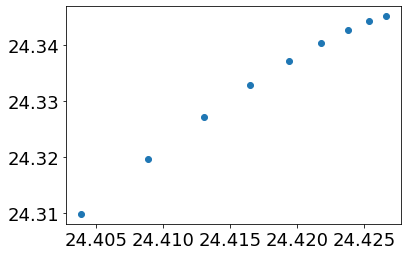

In [303]:
plt.scatter([center_of_mass(InC6)[0],center_of_mass(InC9)[0],center_of_mass(InC12)[0],center_of_mass(InC15)[0],center_of_mass(InC18)[0],center_of_mass(InC21)[0],center_of_mass(InC24)[0],center_of_mass(InC27)[0],center_of_mass(InC30)[0]],[center_of_mass(InC6)[1],center_of_mass(InC9)[1],center_of_mass(InC12)[1],center_of_mass(InC15)[1],center_of_mass(InC18)[1],center_of_mass(InC21)[1],center_of_mass(InC24)[1],center_of_mass(InC27)[1],center_of_mass(InC30)[1]])

In [312]:
#print(center_of_mass(InC6))
2+2

4

In [ ]:
#Test to see if the subpixel alignment is working. Note from solution in https://stackoverflow.com/questions/31713637/stacking-star-psfs-from-an-image-aligning-sub-pixel-centers

x, y = np.mgrid[:100, :100]
# centroids (float)
cx, cy = np.random.rand(2, 9) * 100

# a Gaussian kernel to represent the PSF
def gausskern(x, y, cx, cy, sigma):
    return np.exp(-((x - cx) ** 2 + (y - cy) ** 2) / (2 * sigma ** 2))

# (nstars, ny, nx)
stars = gausskern(x[None, ...], y[None, ...],
                  cx[:, None, None], cy[:, None, None], 10)

# add some noise for extra realism
stars += np.random.randn(*stars.shape) * 0.5

fig, ax = plt.subplots(3, 3, figsize=(5, 5))
for ii in xrange(9):
    ax.flat[ii].imshow(stars[ii], cmap=plt.cm.hot)
    ax.flat[ii].set_axis_off()
fig.tight_layout()

dx = cx[:, None, None] - x[None, ...]
dy = cy[:, None, None] - y[None, ...]

# 2D weighted histogram
bins = np.linspace(-50, 50, 100)
h, xe, ye = np.histogram2d(dx.ravel(), dy.ravel(), bins=bins,
                           weights=stars.ravel())

fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
ax.hold(True)
ax.pcolormesh(xe, ye, h, cmap=plt.cm.hot)
ax.axhline(0, ls='--', lw=2, c='w')
ax.axvline(0, ls='--', lw=2, c='w')
ax.margins(x=0, y=0)

600000.0
        Component1     Component2    Component3   Component4          target
0    -31810.136220  132730.197753  10145.399269   -98.979994           6mrad
1    -98555.353019   31895.678843   8728.895596   481.441794           6mrad
2    -86725.474131   49781.623743   8400.784599  2020.579031           6mrad
3   -119648.820800    1202.274220   8488.379614   564.718113           6mrad
4    -95015.075116   37148.551048   8848.823305  1722.570778           6mrad
..             ...            ...           ...          ...             ...
295   40273.834685  -84774.435575   -341.570264  -750.186111  24mrad zero wf
296  -20429.096242 -156948.319481  -1105.668028   -66.111585  24mrad zero wf
297   39744.388787  -86432.010968     45.856462   589.448055  24mrad zero wf
298   68196.457219  -53043.356445   -193.103896    27.791963  24mrad zero wf
299   88293.563576  -26691.050569    552.969895   -96.535687  24mrad zero wf

[300 rows x 5 columns]


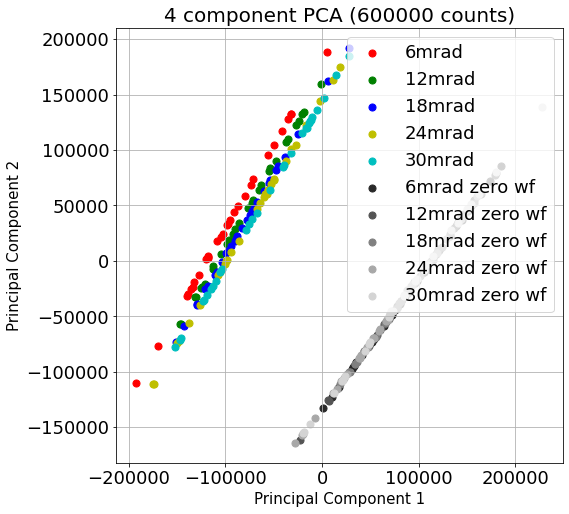

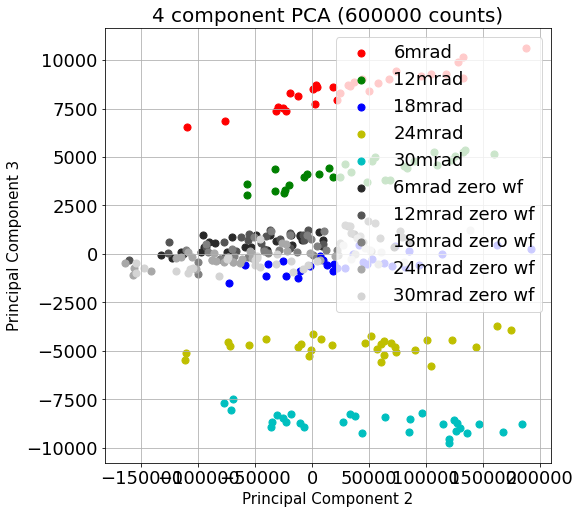

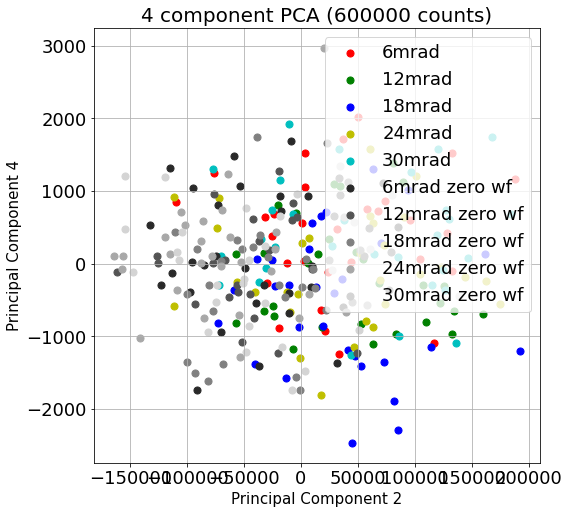

In [333]:
SNR = 600000
x = []
x1 = In6 
x1 = SNR/np.max(x1)*x1 #To get a proper SNR
print(np.max(x1))
y = []

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x1))) #Adding some uncertainty to the SNR
    y.append('6mrad')

x2 = In30 #First I'll try two different populations with wildly varying FRD
x2 = SNR/np.max(x2)*x2 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x2)))
    y.append('30mrad')

x3 = In12 #First I'll try two different populations with wildly varying FRD
x3 = SNR/np.max(x3)*x3 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x3)))
    y.append('12mrad')


x4 = In18 #First I'll try two different populations with wildly varying FRD
x4 = SNR/np.max(x4)*x4 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x4)))
    y.append('18mrad')
    
x5 = In24 #First I'll try two different populations with wildly varying FRD
x5 = SNR/np.max(x5)*x5 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x5)))
    y.append('24mrad')
    
#SNR = 600000
#x = []
x1 = In6_zero 
x1 = SNR/np.max(x1)*x1 #To get a proper SNR
#print(np.max(x1))
#y = []

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x1))) #Adding some uncertainty to the SNR
    y.append('6mrad zero wf')

x2 = In30_zero #First I'll try two different populations with wildly varying FRD
x2 = SNR/np.max(x2)*x2 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x2)))
    y.append('30mrad zero wf')

x3 = In12_zero #First I'll try two different populations with wildly varying FRD
x3 = SNR/np.max(x3)*x3 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x3)))
    y.append('12mrad zero wf')


x4 = In18_zero #First I'll try two different populations with wildly varying FRD
x4 = SNR/np.max(x4)*x4 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x4)))
    y.append('18mrad zero wf')
    
x5 = In24_zero #First I'll try two different populations with wildly varying FRD
x5 = SNR/np.max(x5)*x5 #To get a proper SNR

for index in range(30):
    x.append(np.ndarray.flatten(np.random.normal(loc=1.0,scale=0.05)*addnoise(x5)))
    y.append('24mrad zero wf')
    

    
#from sklearn.decomposition import PCA

#x = StandardScaler().fit_transform(x)
"""pca = PCA()
pca.fit(x)
print(pca.n_components_)
tot = sum(pca.explained_variance_)
print(tot)
var_exp = [(i/tot)*100 for i in sorted(pca.explained_variance_, reverse=True)] 
print(var_exp[0:5])


# Cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
plt.figure(figsize=(10, 5))
plt.step(range(1, 1+pca.n_components_), cum_var_exp, where='mid',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.axhline(y = 90, color='c', linestyle='--', label = '90% Explained Variance')
plt.axhline(y = 85, color='r', linestyle='--', label = '85% Explained Variance')
plt.legend(loc='best')
plt.show()
"""


pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Component1', 'Component2','Component3','Component4'])

principalDf['target'] = y

print(principalDf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('4 component PCA ({} counts)'.format(SNR), fontsize = 20)
targets = ['6mrad','12mrad','18mrad','24mrad','30mrad','6mrad zero wf','12mrad zero wf','18mrad zero wf','24mrad zero wf','30mrad zero wf']
colors = ['r', 'g','b','y','c','0.16','0.33','0.5','0.66','0.83']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'Component1']
               , principalDf.loc[indicesToKeep, 'Component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('4 component PCA ({} counts)'.format(SNR), fontsize = 20)
targets = ['6mrad','12mrad','18mrad','24mrad','30mrad','6mrad zero wf','12mrad zero wf','18mrad zero wf','24mrad zero wf','30mrad zero wf']
colors = ['r', 'g','b','y','c','0.16','0.33','0.5','0.66','0.83']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'Component2']
               , principalDf.loc[indicesToKeep, 'Component3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
#plt.savefig('2nd3rd_Components.png')

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 4', fontsize = 15)
ax.set_title('4 component PCA ({} counts)'.format(SNR), fontsize = 20)
targets = ['6mrad','12mrad','18mrad','24mrad','30mrad','6mrad zero wf','12mrad zero wf','18mrad zero wf','24mrad zero wf','30mrad zero wf']
colors = ['r', 'g','b','y','c','0.16','0.33','0.5','0.66','0.83']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'Component2']
               , principalDf.loc[indicesToKeep, 'Component4']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
#plt.savefig('2nd4th_Components.png')

First-order Components
Second-order Components






 Third-order Components






 Fourth-order Components


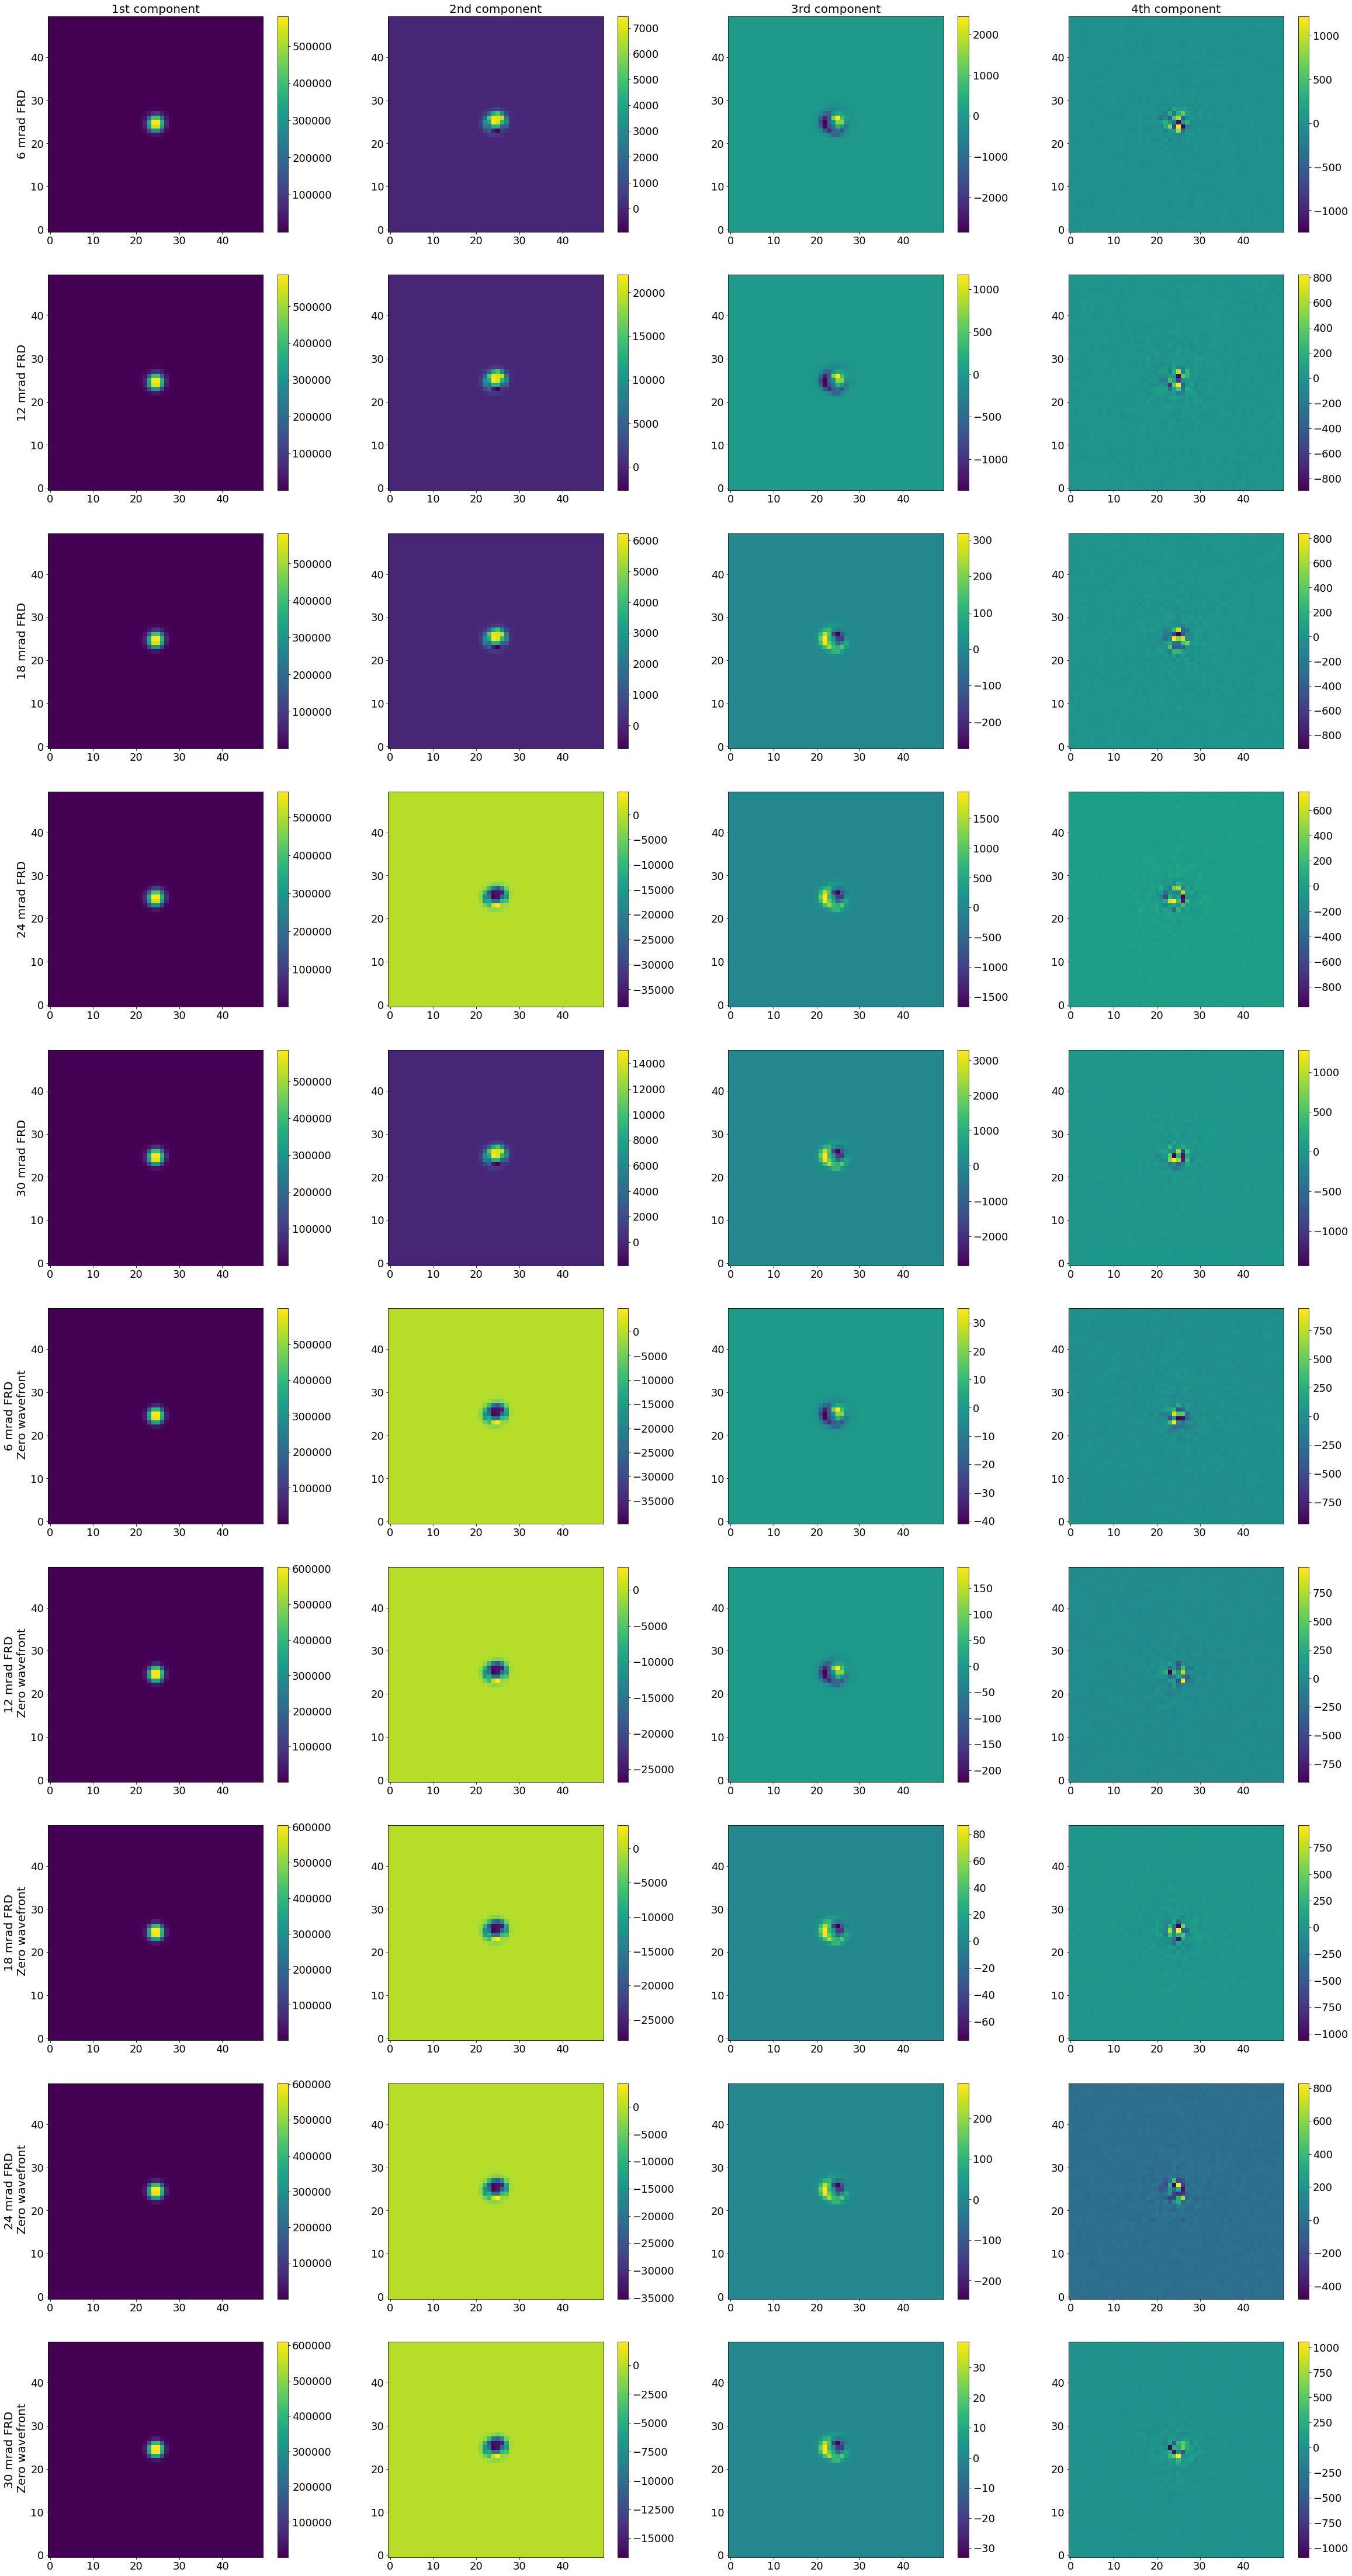

In [337]:
print('First-order Components')

first_component = pd.concat([principalDf['Component1'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component2']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)
second_component = pd.concat([principalDf['Component1'],principalDf['Component2'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)
third_component = pd.concat([principalDf['Component1'],principalDf['Component2'],principalDf['Component3'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)


approximation1 = pca.inverse_transform(first_component)
approximation2 = pca.inverse_transform(second_component)
approximation3 = pca.inverse_transform(third_component)

plt.figure(figsize=(40,80))

plt.subplot(10,4,1)
total = np.resize(x[10],(50,50))
FRDcomp = approximation1[10].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.ylabel('6 mrad FRD', fontsize = 20)
plt.title('1st component', fontsize = 20);
#plt.show()

plt.subplot(10,4,5)
total = np.resize(x[70],(50,50))
FRDcomp = approximation1[70].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
plt.ylabel('12 mrad FRD', fontsize = 20)
#plt.xlabel('1st component', fontsize = 14)
#plt.title('2nd component', fontsize = 20);
#plt.show()

plt.subplot(10,4,9)
total = np.resize(x[100],(50,50))
FRDcomp = approximation1[100].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
plt.ylabel('18 mrad FRD', fontsize = 20)
#plt.show()

plt.subplot(10,4,13)
total = np.resize(x[130],(50,50))
FRDcomp = approximation1[130].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
plt.ylabel('24 mrad FRD', fontsize = 20)
#plt.show()

plt.subplot(10,4,17)
total = np.resize(x[40],(50,50))
FRDcomp = approximation1[40].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
plt.ylabel('30 mrad FRD', fontsize = 20)
#plt.show()

plt.subplot(10,4,21)
total = np.resize(x[160],(50,50))
FRDcomp = approximation1[160].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
plt.ylabel('6 mrad FRD\n Zero wavefront', fontsize = 20)
#plt.show()

plt.subplot(10,4,25)
total = np.resize(x[220],(50,50))
FRDcomp = approximation1[220].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
plt.ylabel('12 mrad FRD\n Zero wavefront', fontsize = 20)
#plt.show()

plt.subplot(10,4,29)
total = np.resize(x[250],(50,50))
FRDcomp = approximation1[250].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
plt.ylabel('18 mrad FRD\n Zero wavefront', fontsize = 20)
#plt.show()

plt.subplot(10,4,33)
total = np.resize(x[280],(50,50))
FRDcomp = approximation1[280].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
plt.ylabel('24 mrad FRD\n Zero wavefront', fontsize = 20)
#plt.show()

plt.subplot(10,4,37)
total = np.resize(x[190],(50,50))
FRDcomp = approximation1[190].reshape(50,50)
plt.imshow(FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
plt.ylabel('30 mrad FRD\n Zero wavefront', fontsize = 20)
#plt.show()

print('Second-order Components')

first_component = pd.concat([principalDf['Component1'],pd.DataFrame(data=np.zeros(len(y)),columns = ['Component2']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component3']),pd.DataFrame(data=np.zeros(len(y)),columns = ['Component4'])],axis = 1)

#approximation1 = pca.inverse_transform(first_component)

plt.subplot(10,4,2)
total = approximation2[10].reshape(50,50)
FRDcomp = approximation1[10].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.title('2nd component', fontsize = 20);
#plt.show()

plt.subplot(10,4,6)
total = approximation2[70].reshape(50,50)
FRDcomp = approximation1[70].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,10)
total = approximation2[100].reshape(50,50)
FRDcomp = approximation1[100].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,14)
total = approximation2[130].reshape(50,50)
FRDcomp = approximation1[130].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,18)
total = approximation2[40].reshape(50,50)
FRDcomp = approximation1[40].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
#plt.show()



plt.subplot(10,4,22)
total = approximation2[160].reshape(50,50)
FRDcomp = approximation1[160].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('2nd component', fontsize = 20);
#plt.show()

plt.subplot(10,4,26)
total = approximation2[220].reshape(50,50)
FRDcomp = approximation1[220].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,30)
total = approximation2[250].reshape(50,50)
FRDcomp = approximation1[250].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,34)
total = approximation2[280].reshape(50,50)
FRDcomp = approximation1[280].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,38)
total = approximation2[190].reshape(50,50)
FRDcomp = approximation1[190].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
#plt.show()


print('\n\n\n\n\n\n Third-order Components')

#approximation2 = pca.inverse_transform(second_component)

plt.subplot(10,4,3)
total = approximation3[10].reshape(50,50)
FRDcomp = approximation2[10].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.title('3rd component', fontsize = 20);
#plt.show()

plt.subplot(10,4,7)
total = approximation3[70].reshape(50,50)
FRDcomp = approximation2[70].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,11)
total = approximation3[100].reshape(50,50)
FRDcomp = approximation2[100].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,15)
total = approximation3[130].reshape(50,50)
FRDcomp = approximation2[130].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,19)
total = approximation3[40].reshape(50,50)
FRDcomp = approximation2[40].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
#plt.show()



plt.subplot(10,4,23)
total = approximation3[160].reshape(50,50)
FRDcomp = approximation2[160].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('3rd component', fontsize = 20);
#plt.show()

plt.subplot(10,4,27)
total = approximation3[220].reshape(50,50)
FRDcomp = approximation2[220].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,31)
total = approximation3[250].reshape(50,50)
FRDcomp = approximation2[250].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,35)
total = approximation3[280].reshape(50,50)
FRDcomp = approximation2[280].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,39)
total = approximation3[190].reshape(50,50)
FRDcomp = approximation2[190].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);
#plt.show()



print('\n\n\n\n\n\n Fourth-order Components')

#approximation3 = pca.inverse_transform(third_component)

plt.subplot(10,4,4)
total = np.resize(x[10],(50,50))
FRDcomp = approximation3[10].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
plt.title('4th component', fontsize = 20);
#plt.show()

plt.subplot(10,4,8)
total = np.resize(x[70],(50,50))
FRDcomp = approximation3[70].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,12)
total = np.resize(x[100],(50,50))
FRDcomp = approximation3[100].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,16)
total = np.resize(x[130],(50,50))
FRDcomp = approximation3[130].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,20)
total = np.resize(x[40],(50,50))
FRDcomp = approximation3[40].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);



plt.subplot(10,4,24)
total = np.resize(x[160],(50,50))
FRDcomp = approximation3[160].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('4th component', fontsize = 20);
#plt.show()

plt.subplot(10,4,28)
total = np.resize(x[220],(50,50))
FRDcomp = approximation3[220].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('12 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,32)
total = np.resize(x[250],(50,50))
FRDcomp = approximation3[250].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('18 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,36)
total = np.resize(x[280],(50,50))
FRDcomp = approximation3[280].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('24 mrad', fontsize = 20);
#plt.show()

plt.subplot(10,4,40)
total = np.resize(x[190],(50,50))
FRDcomp = approximation3[190].reshape(50,50)
plt.imshow(total-FRDcomp,origin='lower')
plt.colorbar()
#plt.xlabel('1st component', fontsize = 14)
#plt.title('30 mrad', fontsize = 20);

plt.savefig('4componentPCA_2D_zero.png')
plt.show()

In [ ]:
def center_at_centroid(image):
    (curcenty,curcentx) = center_of_mass(image)
    (actcenty, actcentx) = 0.5*np.array(np.shape(image))
    (deltashifty, deltashiftx) = (-actcenty+curcenty,-actcentx+curcentx) #This should be easily under a pixel. And luckily, (25,25) is the center of a pixel...
    #So we just want to replace each pixel at (y,x) with the value of the interpolation at (y+curcenty-actcenty,x+curcentx-actcentx)
    #=(y+deltashifty,x+deltashiftx)
    

In [341]:
(a,b) = 0.5*np.array(np.shape(In6))
print(a)

25.0
